# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***

---

---

## Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

## Calibrate camera and undistort

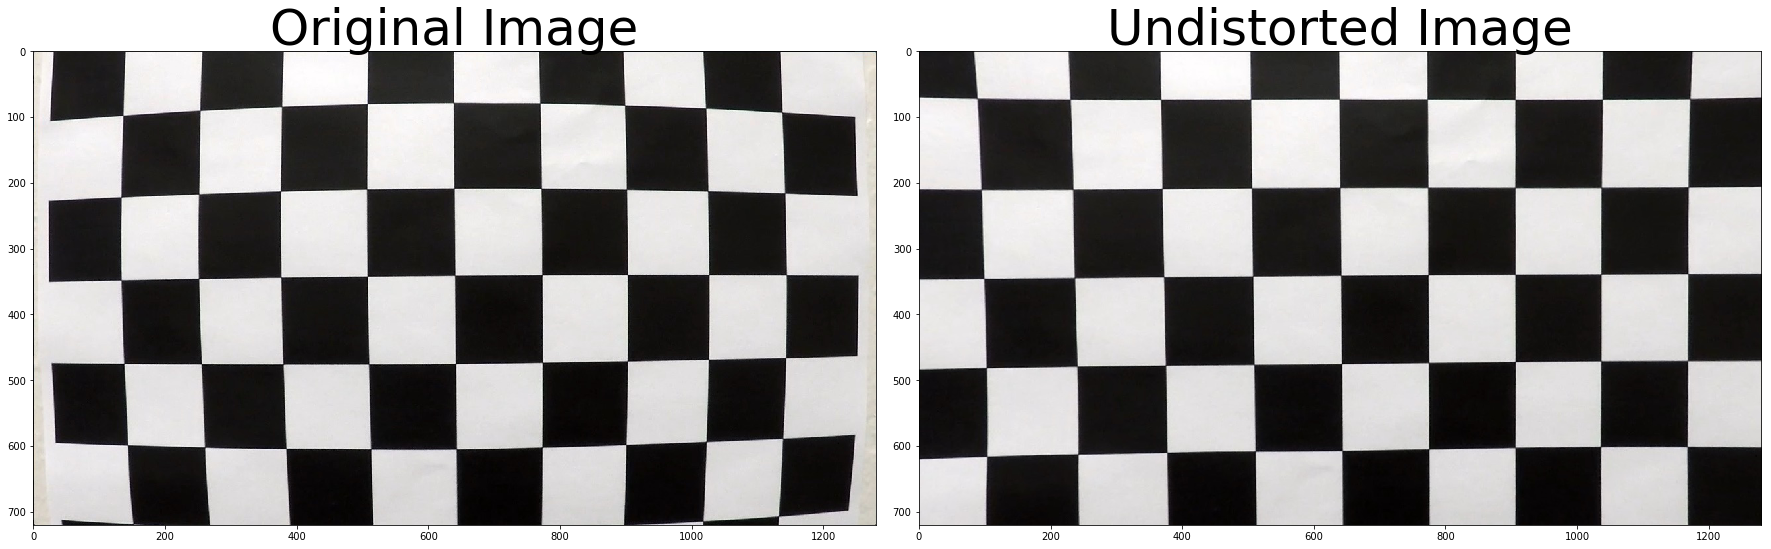

In [2]:
def calibration():

    # Read in an image
    images = glob.glob('camera_cal/calibration*.jpg')

    # prepare object points
    nx = 9
    ny = 6

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points (for example, (3,1,0))
    objp= np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in images:

        # Read in each image
        image = mpimg.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
            # Draw and display the corners
            #cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            #plt.imshow(image)
            #plt.show()

    image_test_calibration = mpimg.imread('test_images/test_image_calibration.jpg')

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, \
                                                       image_test_calibration.shape[1::-1], None, None)

    return mtx, dist, image_test_calibration

mtx, dist, image_test_calibration = calibration()

undistorted = cv2.undistort(image_test_calibration, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test_calibration)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Distortion correction test image

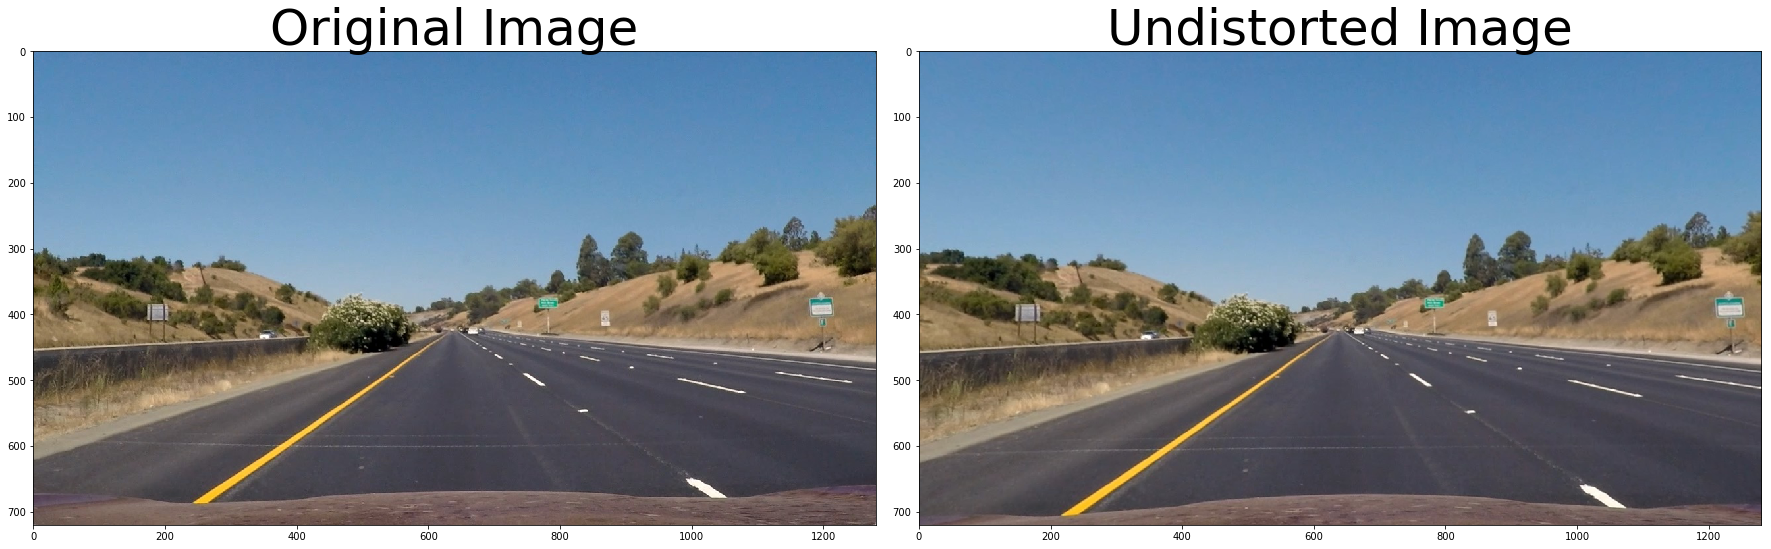

In [3]:
image_test = mpimg.imread('test_images/straight_lines1.jpg')

undistorted_test = cv2.undistort(image_test, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_test)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Color and gradient threshold

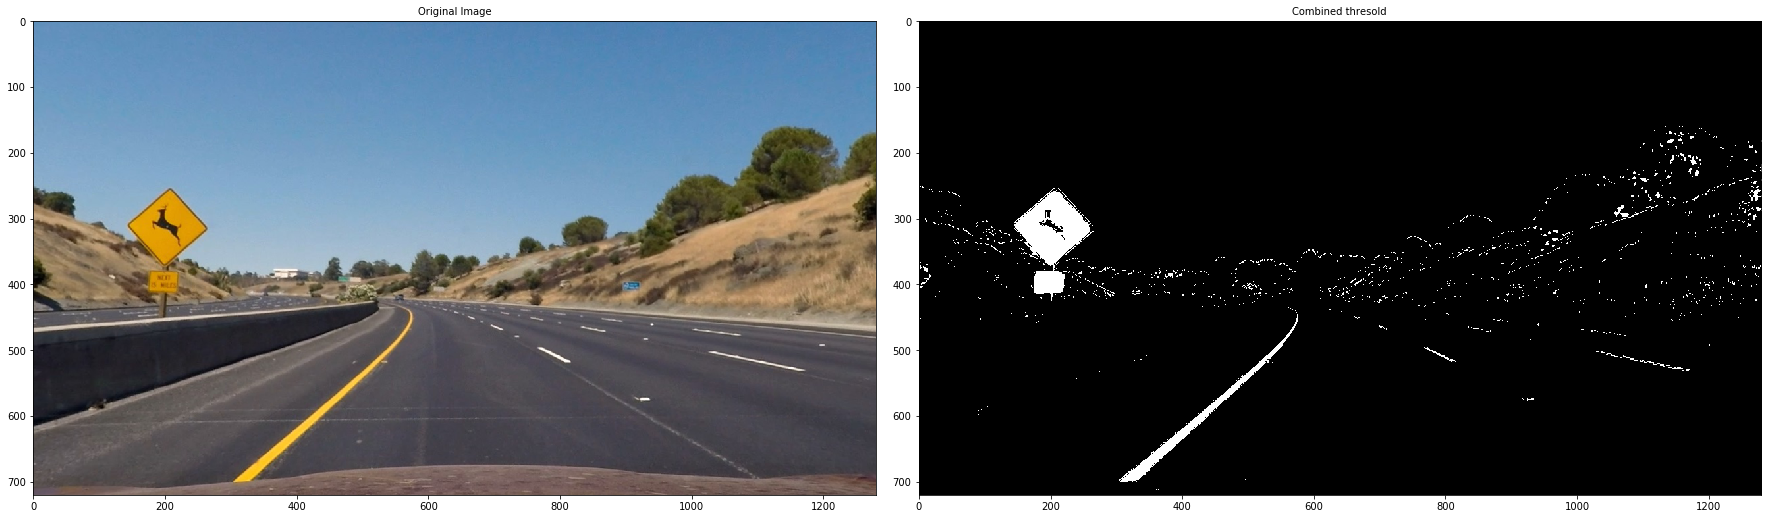

In [28]:
image = mpimg.imread('test_images/test2.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxybinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxybinary = np.zeros_like(dir_grad)
    sxybinary[(dir_grad > thresh[0]) & (dir_grad < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxybinary

def r_threshold(img, h_thresh=(15,100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hls[:,:,2]
	# Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary

def h_threshold(img, h_thresh=(15,100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
	# Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary
	
def s_threshold(img, s_thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
	# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

undist = cv2.undistort(image, mtx, dist, None, mtx)

# Apply each of the thresholding functions
grady = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 90))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
r_binary = r_threshold(undist, h_thresh=(150,255))
h_binary = h_threshold(undist, h_thresh=(15,100))
s_binary = s_threshold(undist, s_thresh=(150,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(dir_binary == 1) & (grady == 1) & (r_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

# Plot the result
f, (ax1, ax6) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=10)
"""
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Directional gradient X', fontsize=10)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Directional gradient Y', fontsize=10)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Gradient magnitude', fontsize=10)
ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Thresholded Grad. Dir.', fontsize=10)
"""
ax6.imshow(combined, cmap='gray')
ax6.set_title('Combined thresold', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Perspective transform


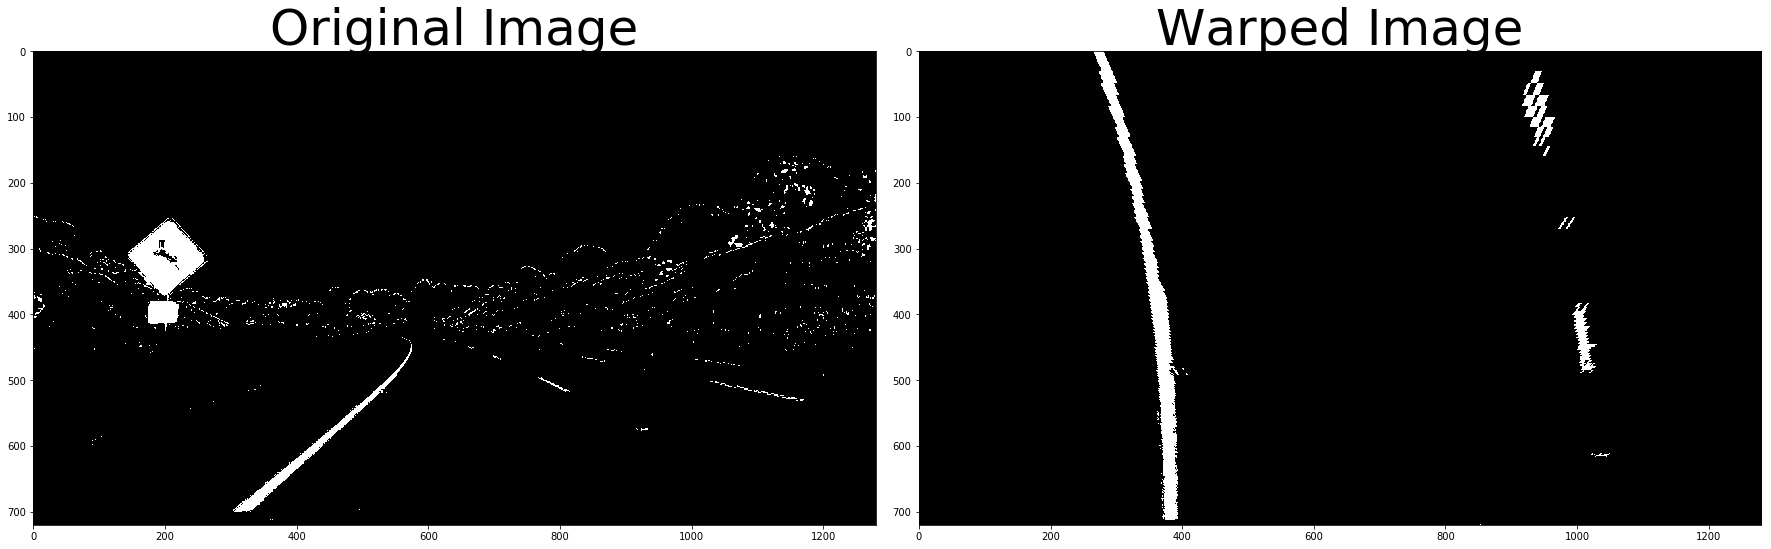

In [29]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, Minv

src = np.float32([[206,720], [1097,720], [580,460], [700,460]])
dst = np.float32([[320,720], [960,720], [320,0], [960,0]])

binary_warped, Minv = warper(combined, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Finding lines

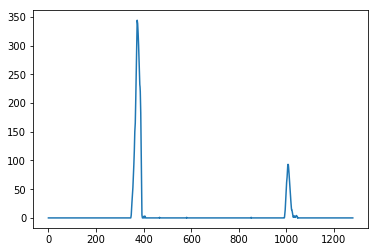

In [30]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Sliding window and fit polynomial

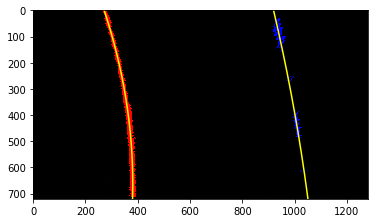

In [31]:
def slid_window_fit_poly(binary_warped, histogram):

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualization

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = \
slid_window_fit_poly(binary_warped, histogram)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## New binary_warped

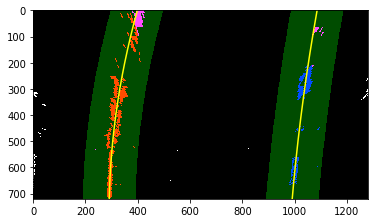

In [32]:
image = mpimg.imread('test_images/test5.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Apply each of the thresholding functions
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
h_binary = h_threshold(undist, h_thresh=(15,100))
s_binary = s_threshold(undist, s_thresh=(170,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(grady == 1) & (dir_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

binary_warped, Minv = warper(combined, src, dst)


def new_slid_window_fit_poly(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = \
new_slid_window_fit_poly(binary_warped, left_fit, right_fit)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Measuring curvature

In [33]:
def meas_curvature(ploty, left_fit, right_fit, leftx, lefty, rightx, righty):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    dist = (right_fitx[359]+left_fitx[359]) / 2
    dist_meters = np.absolute((dist-640)*xm_per_pix)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad, dist_meters

left_meas, right_meas, dist_meters = meas_curvature(ploty, left_fit, right_fit, leftx, lefty, rightx, righty)

926.59353432 m 2561.00334494 m


## View Lines

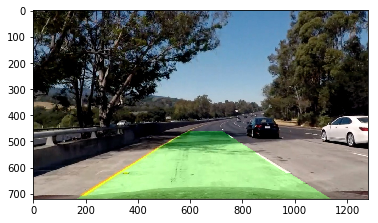

In [34]:
def view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

result = view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, image, undist)

plt.imshow(result)
plt.show()

In [36]:
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements


def pipeline(img):
        
    undist = cv2.undistort(img, pipeline.mtx, pipeline.dist, None, pipeline.mtx)

    # Apply each of the thresholding functions
    grady = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 90))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
    r_binary = r_threshold(undist, h_thresh=(150,255))
    h_binary = h_threshold(undist, h_thresh=(15,100))
    s_binary = s_threshold(undist, s_thresh=(150,255))

    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[(grady == 1) & (dir_binary == 1) & (r_binary == 1)] = 1

    combined_color = np.zeros_like(dir_binary)
    combined_color[(h_binary == 1) & (s_binary == 1)] = 1

    combined = np.zeros_like(combined_gradient)
    combined[(combined_gradient == 1) | (combined_color == 1)] = 1
    
    binary_warped, Minv = warper(combined, src, dst)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if pipeline.first == True:
        out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = slid_window_fit_poly(binary_warped, histogram)
        
        pipeline.left_fit = left_fit
        pipeline.right_fit = right_fit
        pipeline.first = False
    else:
        result, ploty, pipeline.left_fit, pipeline.right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = new_slid_window_fit_poly(binary_warped, pipeline.left_fit, pipeline.right_fit)
    
    pipeline.left_curverad, pipeline.right_curverad, pipeline.dist_meters = meas_curvature\
    (ploty, pipeline.left_fit, pipeline.right_fit, leftx, lefty, rightx, righty)
    
    result = view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of curvature (Left)  = %.2f m' % (pipeline.left_curverad), (10, 40), font, 1,\
                (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature (Right) = %.2f m' % (pipeline.right_curverad), (10, 70), font, 1,\
                (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Distance to center = %.2f m' % (pipeline.dist_meters), (10, 100), font, 1,\
                (255, 255, 255), 2, cv2.LINE_AA)

    return result

img = mpimg.imread('test_images/test2.jpg')

pipeline.first = True
pipeline.mtx = mtx
pipeline.dist = dist
pipeline(img)
    
        

661.50533505 m 2291.74386635 m


array([[[ 96, 145, 188],
        [ 95, 144, 187],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 93, 142, 185],
        ..., 
        [ 78, 130, 179],
        [ 78, 130, 179],
        [ 78, 130, 178]],

       ..., 
       [[ 97,  83,  96],
        [ 98,  84,  97],
        [ 98,  84,  98],
        ..., 
        [122,  98,  88],
        [121,  97,  87],
        [119,  95,  85]],

       [[ 97,  84,  96],
        [ 98,  85,  97],
        [ 99,  86,  98],
        ..., 
        [121,  97,  87],
        [122,  98,  88],
        [120,  96,  86]],

       [[100,  87,  97],
        [100,  87,  97],
        [101,  88,  98],
        ..., 
        [118,  95,  85],
        [120,  96,  86],
        [119,  95,

## Video


In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip('project_video.mp4').subclip(15,50)
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(pipeline)
%time project_clip.write_videofile(project_output, audio=False)

728.925064969 m 910.30531292 m
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

728.925064969 m 910.30531292 m


  0%|                                                                                 | 1/1261 [00:00<06:19,  3.32it/s]

657.4699381 m 1966.00236641 m


  0%|▏                                                                                | 2/1261 [00:00<06:17,  3.34it/s]

654.46903954 m 1742.97646545 m


  0%|▏                                                                                | 3/1261 [00:00<06:21,  3.30it/s]

618.292424628 m 685.656034022 m


  0%|▎                                                                                | 4/1261 [00:01<06:28,  3.24it/s]

611.297475895 m 792.092495933 m


  0%|▎                                                                                | 5/1261 [00:01<06:26,  3.25it/s]

603.595899744 m 825.410765665 m


  0%|▍                                                                                | 6/1261 [00:01<06:26,  3.25it/s]

640.924798226 m 877.7873307 m


  1%|▍                                                                                | 7/1261 [00:02<06:28,  3.23it/s]

651.350835559 m 1530.23958803 m


  1%|▌                                                                                | 8/1261 [00:02<06:22,  3.27it/s]

665.903454488 m 4942.00180253 m


  1%|▌                                                                                | 9/1261 [00:02<06:21,  3.28it/s]

677.702447235 m 3401.4494128 m


  1%|▋                                                                               | 10/1261 [00:03<06:22,  3.27it/s]

709.813969397 m 1257.01011783 m


  1%|▋                                                                               | 11/1261 [00:03<06:29,  3.21it/s]

764.812719989 m 1273.88357585 m


  1%|▊                                                                               | 12/1261 [00:03<06:36,  3.15it/s]

821.541579241 m 2001.89006554 m


  1%|▊                                                                               | 13/1261 [00:04<06:35,  3.16it/s]

849.580211818 m 4684.09281778 m


  1%|▉                                                                               | 14/1261 [00:04<06:34,  3.16it/s]

867.891125936 m 933.464521855 m


  1%|▉                                                                               | 15/1261 [00:04<06:29,  3.20it/s]

909.723503283 m 817.903058316 m


  1%|█                                                                               | 16/1261 [00:04<06:25,  3.23it/s]

906.671578716 m 908.959939038 m


  1%|█                                                                               | 17/1261 [00:05<06:19,  3.28it/s]

977.112781212 m 1026.85489471 m


  1%|█▏                                                                              | 18/1261 [00:05<06:15,  3.31it/s]

1005.70470023 m 1055.74562502 m


  2%|█▏                                                                              | 19/1261 [00:05<06:14,  3.32it/s]

1134.808437 m 1049.85209432 m


  2%|█▎                                                                              | 20/1261 [00:06<06:13,  3.32it/s]

1200.41506447 m 822.258429115 m


  2%|█▎                                                                              | 21/1261 [00:06<06:12,  3.33it/s]

1258.82890112 m 1240.93233492 m


  2%|█▍                                                                              | 22/1261 [00:06<06:11,  3.34it/s]

1352.4808991 m 1427.73442655 m


  2%|█▍                                                                              | 23/1261 [00:07<06:13,  3.32it/s]

1208.44292594 m 1085.62628807 m


  2%|█▌                                                                              | 24/1261 [00:07<06:11,  3.33it/s]

1128.16595589 m 990.396500325 m


  2%|█▌                                                                              | 25/1261 [00:07<06:10,  3.34it/s]

1089.56393998 m 1297.67565725 m


  2%|█▋                                                                              | 26/1261 [00:07<06:15,  3.29it/s]

1034.83846145 m 866.241158763 m


  2%|█▋                                                                              | 27/1261 [00:08<06:15,  3.28it/s]

1029.75461161 m 1457.06918133 m


  2%|█▊                                                                              | 28/1261 [00:08<06:12,  3.31it/s]

928.621820562 m 964.116123651 m


  2%|█▊                                                                              | 29/1261 [00:08<06:14,  3.29it/s]

805.06709257 m 608.49170817 m


  2%|█▉                                                                              | 30/1261 [00:09<06:20,  3.24it/s]

742.634294686 m 705.785226615 m


  2%|█▉                                                                              | 31/1261 [00:09<06:26,  3.18it/s]

656.653268491 m 804.802077154 m


  3%|██                                                                              | 32/1261 [00:09<06:26,  3.18it/s]

678.769073231 m 892.510977345 m


  3%|██                                                                              | 33/1261 [00:10<06:17,  3.25it/s]

652.306196236 m 978.77463842 m


  3%|██▏                                                                             | 34/1261 [00:10<06:17,  3.25it/s]

613.326210533 m 1493.24554855 m


  3%|██▏                                                                             | 35/1261 [00:10<06:21,  3.22it/s]

596.584062969 m 1258.85259259 m


  3%|██▎                                                                             | 36/1261 [00:11<06:14,  3.27it/s]

585.730606676 m 983.006310852 m


  3%|██▎                                                                             | 37/1261 [00:11<06:13,  3.28it/s]

549.050711552 m 1095.18325512 m


  3%|██▍                                                                             | 38/1261 [00:11<06:14,  3.26it/s]

529.555325844 m 701.65341553 m


  3%|██▍                                                                             | 39/1261 [00:11<06:26,  3.16it/s]

519.598697427 m 523.580614914 m


  3%|██▌                                                                             | 40/1261 [00:12<06:30,  3.13it/s]

526.652780885 m 581.609937797 m


  3%|██▌                                                                             | 41/1261 [00:12<06:37,  3.07it/s]

512.014804376 m 588.706186293 m


  3%|██▋                                                                             | 42/1261 [00:12<06:40,  3.04it/s]

502.767579465 m 632.845933791 m


  3%|██▋                                                                             | 43/1261 [00:13<06:42,  3.03it/s]

526.102061116 m 689.817960511 m


  3%|██▊                                                                             | 44/1261 [00:13<06:37,  3.06it/s]

530.528524635 m 730.772882269 m


  4%|██▊                                                                             | 45/1261 [00:13<06:30,  3.12it/s]

546.062952912 m 1832.27152919 m


  4%|██▉                                                                             | 46/1261 [00:14<06:22,  3.18it/s]

566.902881336 m 965.470023528 m


  4%|██▉                                                                             | 47/1261 [00:14<06:20,  3.19it/s]

573.004990336 m 1303.21271127 m


  4%|███                                                                             | 48/1261 [00:14<06:19,  3.20it/s]

616.081918315 m 898.61733153 m


  4%|███                                                                             | 49/1261 [00:15<06:14,  3.23it/s]

648.05957237 m 1051.21367532 m


  4%|███▏                                                                            | 50/1261 [00:15<06:12,  3.25it/s]

701.663811217 m 985.323534012 m


  4%|███▏                                                                            | 51/1261 [00:15<06:09,  3.27it/s]

738.657024287 m 951.420041891 m


  4%|███▎                                                                            | 52/1261 [00:16<06:11,  3.25it/s]

770.403336479 m 656.733736137 m


  4%|███▎                                                                            | 53/1261 [00:16<06:09,  3.27it/s]

859.287094729 m 627.524448128 m


  4%|███▍                                                                            | 54/1261 [00:16<06:13,  3.23it/s]

935.97796634 m 674.450201347 m


  4%|███▍                                                                            | 55/1261 [00:17<06:13,  3.23it/s]

1038.31135843 m 740.466853269 m


  4%|███▌                                                                            | 56/1261 [00:17<06:14,  3.22it/s]

1055.39441508 m 816.29765475 m


  5%|███▌                                                                            | 57/1261 [00:17<06:11,  3.24it/s]

1170.87738762 m 1116.63087286 m


  5%|███▋                                                                            | 58/1261 [00:17<06:26,  3.11it/s]

1048.42356278 m 1611.09825743 m


  5%|███▋                                                                            | 59/1261 [00:18<06:49,  2.93it/s]

1034.45918905 m 889.142640596 m


  5%|███▊                                                                            | 60/1261 [00:18<06:51,  2.92it/s]

969.685688794 m 1093.93282341 m


  5%|███▊                                                                            | 61/1261 [00:19<06:55,  2.89it/s]

895.138669743 m 915.460742225 m


  5%|███▉                                                                            | 62/1261 [00:19<06:51,  2.92it/s]

872.381454001 m 2309.57199581 m


  5%|███▉                                                                            | 63/1261 [00:19<06:36,  3.02it/s]

859.825998771 m 610.876574242 m


  5%|████                                                                            | 64/1261 [00:20<06:37,  3.01it/s]

821.277407898 m 612.446003387 m


  5%|████                                                                            | 65/1261 [00:20<06:45,  2.95it/s]

767.858958424 m 842.407217187 m


  5%|████▏                                                                           | 66/1261 [00:20<06:46,  2.94it/s]

779.929272077 m 968.207967237 m


  5%|████▎                                                                           | 67/1261 [00:21<06:49,  2.92it/s]

735.396091801 m 1026.40350036 m


  5%|████▎                                                                           | 68/1261 [00:21<06:53,  2.88it/s]

734.883507048 m 1068.05940223 m


  5%|████▍                                                                           | 69/1261 [00:21<06:56,  2.86it/s]

754.762701582 m 1217.47678613 m


  6%|████▍                                                                           | 70/1261 [00:22<06:53,  2.88it/s]

779.949483005 m 1297.32316312 m


  6%|████▌                                                                           | 71/1261 [00:22<06:59,  2.84it/s]

938.564947226 m 1715.6686668 m


  6%|████▌                                                                           | 72/1261 [00:22<06:59,  2.84it/s]

1042.35313483 m 1370.4068005 m


  6%|████▋                                                                           | 73/1261 [00:23<07:05,  2.79it/s]

1096.84008172 m 1234.50892468 m


  6%|████▋                                                                           | 74/1261 [00:23<06:52,  2.87it/s]

1082.51444608 m 1320.26815004 m


  6%|████▊                                                                           | 75/1261 [00:23<06:40,  2.96it/s]

1321.05000967 m 2689.43640619 m


  6%|████▊                                                                           | 76/1261 [00:24<06:42,  2.94it/s]

1577.88584991 m 953.62775363 m


  6%|████▉                                                                           | 77/1261 [00:24<06:43,  2.93it/s]

1847.61086972 m 1342.63207692 m


  6%|████▉                                                                           | 78/1261 [00:24<06:45,  2.92it/s]

2037.25447241 m 565.356939673 m


  6%|█████                                                                           | 79/1261 [00:25<06:40,  2.95it/s]

1870.21669806 m 635.812774942 m


  6%|█████                                                                           | 80/1261 [00:25<06:37,  2.97it/s]

2166.4005304 m 716.671563221 m


  6%|█████▏                                                                          | 81/1261 [00:25<06:40,  2.94it/s]

2236.9291471 m 722.575586183 m


  7%|█████▏                                                                          | 82/1261 [00:26<06:42,  2.93it/s]

1850.67643891 m 920.864441847 m


  7%|█████▎                                                                          | 83/1261 [00:26<06:35,  2.98it/s]

1596.61128004 m 1836.58148318 m


  7%|█████▎                                                                          | 84/1261 [00:26<06:27,  3.04it/s]

1262.64202744 m 7600.2879384 m


  7%|█████▍                                                                          | 85/1261 [00:27<06:39,  2.95it/s]

1184.94143048 m 1969.13546899 m


  7%|█████▍                                                                          | 86/1261 [00:27<06:37,  2.95it/s]

1063.33158126 m 1542.48604921 m


  7%|█████▌                                                                          | 87/1261 [00:27<06:31,  3.00it/s]

859.696017987 m 12413.0619111 m


  7%|█████▌                                                                          | 88/1261 [00:28<06:20,  3.08it/s]

817.423819234 m 3197.07898449 m


  7%|█████▋                                                                          | 89/1261 [00:28<06:26,  3.03it/s]

724.31750745 m 783.652726368 m


  7%|█████▋                                                                          | 90/1261 [00:28<06:32,  2.98it/s]

750.139912591 m 708.577719226 m


  7%|█████▊                                                                          | 91/1261 [00:29<06:38,  2.94it/s]

759.96670011 m 849.588580339 m


  7%|█████▊                                                                          | 92/1261 [00:29<06:30,  2.99it/s]

722.911066208 m 862.389664206 m


  7%|█████▉                                                                          | 93/1261 [00:29<06:23,  3.04it/s]

706.694921867 m 1031.64133313 m


  7%|█████▉                                                                          | 94/1261 [00:30<06:15,  3.11it/s]

708.995854962 m 1059.11972503 m


  8%|██████                                                                          | 95/1261 [00:30<06:22,  3.05it/s]

710.021889065 m 1190.51143761 m


  8%|██████                                                                          | 96/1261 [00:30<06:40,  2.91it/s]

720.354729224 m 1423.47351179 m


  8%|██████▏                                                                         | 97/1261 [00:31<06:41,  2.90it/s]

744.049609348 m 1895.53424563 m


  8%|██████▏                                                                         | 98/1261 [00:31<06:37,  2.92it/s]

728.591812419 m 866.156097996 m


  8%|██████▎                                                                         | 99/1261 [00:31<06:29,  2.99it/s]

754.390186207 m 1485.54037852 m


  8%|██████▎                                                                        | 100/1261 [00:32<06:30,  2.98it/s]

766.46477998 m 853.258392855 m


  8%|██████▎                                                                        | 101/1261 [00:32<06:41,  2.89it/s]

797.731026701 m 953.437150371 m


  8%|██████▍                                                                        | 102/1261 [00:32<06:41,  2.89it/s]

799.865540597 m 579.876835716 m


  8%|██████▍                                                                        | 103/1261 [00:33<06:42,  2.88it/s]

825.925016052 m 659.562238044 m


  8%|██████▌                                                                        | 104/1261 [00:33<06:48,  2.83it/s]

857.306178445 m 692.388951119 m


  8%|██████▌                                                                        | 105/1261 [00:34<06:53,  2.79it/s]

919.710107374 m 797.124569994 m


  8%|██████▋                                                                        | 106/1261 [00:34<06:58,  2.76it/s]

909.333768293 m 734.257936533 m


  8%|██████▋                                                                        | 107/1261 [00:34<06:54,  2.79it/s]

814.052613518 m 908.343676743 m


  9%|██████▊                                                                        | 108/1261 [00:35<06:47,  2.83it/s]

797.510838611 m 4910.70683813 m


  9%|██████▊                                                                        | 109/1261 [00:35<06:48,  2.82it/s]

769.670875262 m 1193.74167763 m


  9%|██████▉                                                                        | 110/1261 [00:35<06:49,  2.81it/s]

739.790789727 m 2048.65546952 m


  9%|██████▉                                                                        | 111/1261 [00:36<06:46,  2.83it/s]

773.817412691 m 2330.43220964 m


  9%|███████                                                                        | 112/1261 [00:36<06:30,  2.94it/s]

738.444560668 m 1232.18249842 m


  9%|███████                                                                        | 113/1261 [00:36<06:19,  3.03it/s]

713.781319721 m 6893.90969239 m


  9%|███████▏                                                                       | 114/1261 [00:37<06:07,  3.12it/s]

691.912376236 m 1396.14354747 m


  9%|███████▏                                                                       | 115/1261 [00:37<06:07,  3.12it/s]

676.819710945 m 506.507845302 m


  9%|███████▎                                                                       | 116/1261 [00:37<06:07,  3.12it/s]

669.801413026 m 561.831037115 m


  9%|███████▎                                                                       | 117/1261 [00:38<06:24,  2.98it/s]

653.952570914 m 603.24885709 m


  9%|███████▍                                                                       | 118/1261 [00:38<06:27,  2.95it/s]

648.168042392 m 622.685039405 m


  9%|███████▍                                                                       | 119/1261 [00:38<06:17,  3.02it/s]

633.761049144 m 612.940562479 m


 10%|███████▌                                                                       | 120/1261 [00:39<06:11,  3.07it/s]

646.315784907 m 684.924682256 m


 10%|███████▌                                                                       | 121/1261 [00:39<06:09,  3.08it/s]

639.138943355 m 816.093845483 m


 10%|███████▋                                                                       | 122/1261 [00:39<06:09,  3.08it/s]

611.359713479 m 848.450586199 m


 10%|███████▋                                                                       | 123/1261 [00:40<06:02,  3.14it/s]

614.623769399 m 931.344936584 m


 10%|███████▊                                                                       | 124/1261 [00:40<06:01,  3.14it/s]

617.568957914 m 668.730548987 m


 10%|███████▊                                                                       | 125/1261 [00:40<06:08,  3.08it/s]

643.190232854 m 1147.0596775 m


 10%|███████▉                                                                       | 126/1261 [00:41<06:17,  3.01it/s]

644.52591122 m 1326.4663353 m


 10%|███████▉                                                                       | 127/1261 [00:41<06:15,  3.02it/s]

674.02878406 m 521.898779569 m


 10%|████████                                                                       | 128/1261 [00:41<06:18,  2.99it/s]

664.27686541 m 589.116338549 m


 10%|████████                                                                       | 129/1261 [00:42<06:26,  2.93it/s]

674.873809714 m 639.67034958 m


 10%|████████▏                                                                      | 130/1261 [00:42<06:33,  2.87it/s]

705.262937721 m 689.032659296 m


 10%|████████▏                                                                      | 131/1261 [00:42<06:41,  2.82it/s]

698.86084074 m 707.90279631 m


 10%|████████▎                                                                      | 132/1261 [00:43<06:39,  2.82it/s]

723.285346857 m 698.969353354 m


 11%|████████▎                                                                      | 133/1261 [00:43<06:35,  2.85it/s]

704.869052647 m 1915.10740837 m


 11%|████████▍                                                                      | 134/1261 [00:43<06:21,  2.95it/s]

724.042946135 m 841.441581519 m


 11%|████████▍                                                                      | 135/1261 [00:44<06:09,  3.05it/s]

730.072576825 m 944.683168341 m


 11%|████████▌                                                                      | 136/1261 [00:44<06:01,  3.11it/s]

795.531851033 m 1030.33029236 m


 11%|████████▌                                                                      | 137/1261 [00:44<06:01,  3.11it/s]

841.402147287 m 1730.90633636 m


 11%|████████▋                                                                      | 138/1261 [00:45<05:57,  3.14it/s]

810.107001001 m 1380.45577221 m


 11%|████████▋                                                                      | 139/1261 [00:45<05:51,  3.19it/s]

890.442735157 m 1486.6642819 m


 11%|████████▊                                                                      | 140/1261 [00:45<05:52,  3.18it/s]

927.740753074 m 818.028757654 m


 11%|████████▊                                                                      | 141/1261 [00:46<05:50,  3.19it/s]

933.79578498 m 768.965671504 m


 11%|████████▉                                                                      | 142/1261 [00:46<05:47,  3.22it/s]

862.909797485 m 877.17866506 m


 11%|████████▉                                                                      | 143/1261 [00:46<05:48,  3.20it/s]

866.066049082 m 1005.15637331 m


 11%|█████████                                                                      | 144/1261 [00:46<05:45,  3.24it/s]

881.317876347 m 1010.96701527 m


 11%|█████████                                                                      | 145/1261 [00:47<05:43,  3.25it/s]

906.058995926 m 1180.57420425 m


 12%|█████████▏                                                                     | 146/1261 [00:47<05:45,  3.22it/s]

915.634732075 m 1568.18224016 m


 12%|█████████▏                                                                     | 147/1261 [00:47<05:43,  3.24it/s]

869.345647353 m 1292.35528752 m


 12%|█████████▎                                                                     | 148/1261 [00:48<05:42,  3.25it/s]

918.065148749 m 2858.36191347 m


 12%|█████████▎                                                                     | 149/1261 [00:48<05:49,  3.18it/s]

973.538488064 m 2842.80508493 m


 12%|█████████▍                                                                     | 150/1261 [00:48<05:51,  3.16it/s]

983.281131739 m 1334.6257765 m


 12%|█████████▍                                                                     | 151/1261 [00:49<06:02,  3.06it/s]

1037.77116942 m 775.741322504 m


 12%|█████████▌                                                                     | 152/1261 [00:49<06:03,  3.05it/s]

1046.56531506 m 590.78834027 m


 12%|█████████▌                                                                     | 153/1261 [00:49<06:10,  2.99it/s]

1049.13757729 m 624.488081015 m


 12%|█████████▋                                                                     | 154/1261 [00:50<06:09,  2.99it/s]

995.853214343 m 659.586302204 m


 12%|█████████▋                                                                     | 155/1261 [00:50<06:15,  2.94it/s]

1007.68859506 m 733.860505365 m


 12%|█████████▊                                                                     | 156/1261 [00:50<06:21,  2.89it/s]

987.149274953 m 799.570935326 m


 12%|█████████▊                                                                     | 157/1261 [00:51<06:24,  2.87it/s]

877.506064824 m 819.857494178 m


 13%|█████████▉                                                                     | 158/1261 [00:51<06:21,  2.89it/s]

859.752819435 m 8262.83460407 m


 13%|█████████▉                                                                     | 159/1261 [00:51<06:21,  2.89it/s]

799.706075078 m 2024.95531728 m


 13%|██████████                                                                     | 160/1261 [00:52<06:24,  2.86it/s]

802.132390224 m 1100.99298596 m


 13%|██████████                                                                     | 161/1261 [00:52<06:26,  2.85it/s]

775.414303611 m 2129.48138377 m


 13%|██████████▏                                                                    | 162/1261 [00:52<06:26,  2.85it/s]

791.269163019 m 1555.72530567 m


 13%|██████████▏                                                                    | 163/1261 [00:53<06:38,  2.75it/s]

766.254775098 m 5100.97079773 m


 13%|██████████▎                                                                    | 164/1261 [00:53<06:44,  2.71it/s]

755.791607064 m 687.987594063 m


 13%|██████████▎                                                                    | 165/1261 [00:54<06:50,  2.67it/s]

753.398784098 m 775.892676822 m


 13%|██████████▍                                                                    | 166/1261 [00:54<06:45,  2.70it/s]

696.009745386 m 783.332417771 m


 13%|██████████▍                                                                    | 167/1261 [00:54<06:50,  2.67it/s]

771.474363904 m 972.735922709 m


 13%|██████████▌                                                                    | 168/1261 [00:55<06:42,  2.72it/s]

794.88751478 m 899.382564304 m


 13%|██████████▌                                                                    | 169/1261 [00:55<06:38,  2.74it/s]

850.841764879 m 994.248032069 m


 13%|██████████▋                                                                    | 170/1261 [00:55<06:33,  2.77it/s]

896.22324836 m 1085.07553206 m


 14%|██████████▋                                                                    | 171/1261 [00:56<06:34,  2.76it/s]

940.706633724 m 1150.58729053 m


 14%|██████████▊                                                                    | 172/1261 [00:56<06:31,  2.78it/s]

955.068784138 m 892.432064085 m


 14%|██████████▊                                                                    | 173/1261 [00:57<06:31,  2.78it/s]

978.930741239 m 606.631932851 m


 14%|██████████▉                                                                    | 174/1261 [00:57<06:28,  2.80it/s]

890.325883384 m 562.770683592 m


 14%|██████████▉                                                                    | 175/1261 [00:57<06:26,  2.81it/s]

921.050270253 m 320.995835942 m


 14%|███████████                                                                    | 176/1261 [00:58<06:27,  2.80it/s]

999.463687895 m 350.605782634 m


 14%|███████████                                                                    | 177/1261 [00:58<06:23,  2.82it/s]

991.151671938 m 387.120522809 m


 14%|███████████▏                                                                   | 178/1261 [00:58<06:20,  2.85it/s]

999.276109928 m 420.740420346 m


 14%|███████████▏                                                                   | 179/1261 [00:59<06:21,  2.84it/s]

943.535245305 m 425.105778322 m


 14%|███████████▎                                                                   | 180/1261 [00:59<06:20,  2.84it/s]

807.451769205 m 444.569500303 m


 14%|███████████▎                                                                   | 181/1261 [00:59<06:22,  2.82it/s]

820.996969482 m 475.674606354 m


 14%|███████████▍                                                                   | 182/1261 [01:00<06:19,  2.85it/s]

731.214130089 m 466.416659837 m


 15%|███████████▍                                                                   | 183/1261 [01:00<06:18,  2.85it/s]

653.685275549 m 570.537756068 m


 15%|███████████▌                                                                   | 184/1261 [01:00<06:22,  2.82it/s]

590.408207585 m 673.287176762 m


 15%|███████████▌                                                                   | 185/1261 [01:01<06:21,  2.82it/s]

500.038342973 m 572.323385664 m


 15%|███████████▋                                                                   | 186/1261 [01:01<06:19,  2.83it/s]

484.459683136 m 430.24746105 m


 15%|███████████▋                                                                   | 187/1261 [01:01<06:15,  2.86it/s]

470.046598706 m 497.140893982 m


 15%|███████████▊                                                                   | 188/1261 [01:02<06:15,  2.86it/s]

470.812092273 m 548.559770097 m


 15%|███████████▊                                                                   | 189/1261 [01:02<06:24,  2.79it/s]

479.841927624 m 587.309959735 m


 15%|███████████▉                                                                   | 190/1261 [01:03<06:23,  2.79it/s]

493.990986018 m 585.308038293 m


 15%|███████████▉                                                                   | 191/1261 [01:03<06:21,  2.81it/s]

522.084440004 m 639.700169853 m


 15%|████████████                                                                   | 192/1261 [01:03<06:18,  2.82it/s]

526.838908419 m 626.137147649 m


 15%|████████████                                                                   | 193/1261 [01:04<06:19,  2.81it/s]

554.338001617 m 679.874214927 m


 15%|████████████▏                                                                  | 194/1261 [01:04<06:21,  2.79it/s]

571.01892668 m 690.930285332 m


 15%|████████████▏                                                                  | 195/1261 [01:04<06:16,  2.83it/s]

652.734989629 m 1282.83515884 m


 16%|████████████▎                                                                  | 196/1261 [01:05<06:12,  2.86it/s]

706.976801112 m 1394.28678281 m


 16%|████████████▎                                                                  | 197/1261 [01:05<06:16,  2.83it/s]

775.638672143 m 1150.03025781 m


 16%|████████████▍                                                                  | 198/1261 [01:05<06:14,  2.84it/s]

776.277605357 m 1204.6908103 m


 16%|████████████▍                                                                  | 199/1261 [01:06<06:15,  2.83it/s]

816.237222132 m 1303.59261518 m


 16%|████████████▌                                                                  | 200/1261 [01:06<06:11,  2.86it/s]

838.278522723 m 1682.97094972 m


 16%|████████████▌                                                                  | 201/1261 [01:06<06:12,  2.85it/s]

846.669202365 m 2487.78372145 m


 16%|████████████▋                                                                  | 202/1261 [01:07<06:11,  2.85it/s]

855.125733793 m 825.680280011 m


 16%|████████████▋                                                                  | 203/1261 [01:07<06:11,  2.85it/s]

804.987514559 m 586.919070406 m


 16%|████████████▊                                                                  | 204/1261 [01:07<06:09,  2.86it/s]

775.439871198 m 662.874587348 m


 16%|████████████▊                                                                  | 205/1261 [01:08<06:14,  2.82it/s]

758.374841183 m 684.326316554 m


 16%|████████████▉                                                                  | 206/1261 [01:08<06:08,  2.86it/s]

707.890063608 m 664.224477061 m


 16%|████████████▉                                                                  | 207/1261 [01:09<06:07,  2.87it/s]

690.16252943 m 1315.15588974 m


 16%|█████████████                                                                  | 208/1261 [01:09<06:03,  2.90it/s]

711.233450014 m 1260.25607048 m


 17%|█████████████                                                                  | 209/1261 [01:09<06:08,  2.85it/s]

712.28395 m 891.347786183 m


 17%|█████████████▏                                                                 | 210/1261 [01:10<06:10,  2.84it/s]

735.911280832 m 1028.86970228 m


 17%|█████████████▏                                                                 | 211/1261 [01:10<06:17,  2.78it/s]

696.29131678 m 986.288089933 m


 17%|█████████████▎                                                                 | 212/1261 [01:10<06:13,  2.81it/s]

696.32706168 m 996.663749034 m


 17%|█████████████▎                                                                 | 213/1261 [01:11<06:13,  2.80it/s]

647.464042748 m 1127.84432559 m


 17%|█████████████▍                                                                 | 214/1261 [01:11<06:05,  2.87it/s]

616.329848094 m 670.414834025 m


 17%|█████████████▍                                                                 | 215/1261 [01:11<06:02,  2.88it/s]

626.242005592 m 614.824165918 m


 17%|█████████████▌                                                                 | 216/1261 [01:12<06:04,  2.87it/s]

632.055193451 m 711.799279119 m


 17%|█████████████▌                                                                 | 217/1261 [01:12<06:08,  2.83it/s]

634.338397305 m 818.620813393 m


 17%|█████████████▋                                                                 | 218/1261 [01:12<06:06,  2.85it/s]

616.337052417 m 882.701345173 m


 17%|█████████████▋                                                                 | 219/1261 [01:13<06:04,  2.86it/s]

664.359963215 m 1011.25648927 m


 17%|█████████████▊                                                                 | 220/1261 [01:13<06:00,  2.88it/s]

690.531616293 m 3448.56535445 m


 18%|█████████████▊                                                                 | 221/1261 [01:13<05:59,  2.89it/s]

731.925591092 m 13655.5196674 m


 18%|█████████████▉                                                                 | 222/1261 [01:14<05:57,  2.91it/s]

777.717042154 m 2705.55680665 m


 18%|█████████████▉                                                                 | 223/1261 [01:14<06:03,  2.86it/s]

759.647572393 m 1790.21254767 m


 18%|██████████████                                                                 | 224/1261 [01:15<06:09,  2.81it/s]

776.001634974 m 3916.19124654 m


 18%|██████████████                                                                 | 225/1261 [01:15<06:08,  2.81it/s]

790.319381251 m 1261.68788558 m


 18%|██████████████▏                                                                | 226/1261 [01:15<06:11,  2.79it/s]

814.054215816 m 661.101404528 m


 18%|██████████████▏                                                                | 227/1261 [01:16<06:06,  2.82it/s]

858.197575894 m 644.452789438 m


 18%|██████████████▎                                                                | 228/1261 [01:16<06:09,  2.80it/s]

831.292880105 m 860.601456144 m


 18%|██████████████▎                                                                | 229/1261 [01:16<06:05,  2.83it/s]

890.758557296 m 796.943437854 m


 18%|██████████████▍                                                                | 230/1261 [01:17<06:06,  2.81it/s]

902.293535616 m 900.328789598 m


 18%|██████████████▍                                                                | 231/1261 [01:17<06:02,  2.84it/s]

983.340006613 m 909.910948293 m


 18%|██████████████▌                                                                | 232/1261 [01:17<05:57,  2.88it/s]

959.903652248 m 2590.05769032 m


 18%|██████████████▌                                                                | 233/1261 [01:18<05:42,  3.00it/s]

941.593329059 m 1720.01004069 m


 19%|██████████████▋                                                                | 234/1261 [01:18<05:40,  3.01it/s]

1046.74184862 m 990.568592293 m


 19%|██████████████▋                                                                | 235/1261 [01:18<05:41,  3.01it/s]

961.955895013 m 938.845112875 m


 19%|██████████████▊                                                                | 236/1261 [01:19<05:45,  2.97it/s]

902.965727944 m 1304.55478117 m


 19%|██████████████▊                                                                | 237/1261 [01:19<05:50,  2.92it/s]

909.557769282 m 1162.75865775 m


 19%|██████████████▉                                                                | 238/1261 [01:19<05:45,  2.96it/s]

922.144868946 m 482.098114472 m


 19%|██████████████▉                                                                | 239/1261 [01:20<05:46,  2.95it/s]

928.739595786 m 518.840909466 m


 19%|███████████████                                                                | 240/1261 [01:20<05:43,  2.97it/s]

876.933662527 m 569.247393295 m


 19%|███████████████                                                                | 241/1261 [01:20<05:41,  2.99it/s]

872.020785985 m 599.798120655 m


 19%|███████████████▏                                                               | 242/1261 [01:21<05:44,  2.96it/s]

790.995524304 m 635.935704485 m


 19%|███████████████▏                                                               | 243/1261 [01:21<05:56,  2.86it/s]

790.652635707 m 652.520733198 m


 19%|███████████████▎                                                               | 244/1261 [01:21<05:46,  2.94it/s]

741.391333379 m 686.495432566 m


 19%|███████████████▎                                                               | 245/1261 [01:22<05:37,  3.01it/s]

687.697451899 m 711.237063584 m


 20%|███████████████▍                                                               | 246/1261 [01:22<05:29,  3.08it/s]

710.52992211 m 735.514360982 m


 20%|███████████████▍                                                               | 247/1261 [01:22<05:25,  3.12it/s]

686.54419176 m 520.470698767 m


 20%|███████████████▌                                                               | 248/1261 [01:23<05:21,  3.15it/s]

727.108107255 m 571.988605269 m


 20%|███████████████▌                                                               | 249/1261 [01:23<05:15,  3.20it/s]

752.537831591 m 496.278129782 m


 20%|███████████████▋                                                               | 250/1261 [01:23<05:13,  3.22it/s]

813.354038293 m 541.322174951 m


 20%|███████████████▋                                                               | 251/1261 [01:24<05:15,  3.20it/s]

817.084210547 m 651.064408074 m


 20%|███████████████▊                                                               | 252/1261 [01:24<05:21,  3.14it/s]

797.37898327 m 690.918329611 m


 20%|███████████████▊                                                               | 253/1261 [01:24<05:33,  3.02it/s]

884.87583909 m 708.761929282 m


 20%|███████████████▉                                                               | 254/1261 [01:25<05:31,  3.03it/s]

865.327355157 m 741.097312752 m


 20%|███████████████▉                                                               | 255/1261 [01:25<05:27,  3.07it/s]

824.818491117 m 727.659792883 m


 20%|████████████████                                                               | 256/1261 [01:25<05:21,  3.12it/s]

821.749369727 m 962.223687705 m


 20%|████████████████                                                               | 257/1261 [01:25<05:23,  3.11it/s]

806.781695961 m 867.839214579 m


 20%|████████████████▏                                                              | 258/1261 [01:26<05:30,  3.04it/s]

771.782386549 m 603.419808597 m


 21%|████████████████▏                                                              | 259/1261 [01:26<05:35,  2.99it/s]

825.009820641 m 1037.7297096 m


 21%|████████████████▎                                                              | 260/1261 [01:27<05:39,  2.95it/s]

855.584516762 m 1608.28274521 m


 21%|████████████████▎                                                              | 261/1261 [01:27<05:26,  3.06it/s]

941.324233474 m 597.936225506 m


 21%|████████████████▍                                                              | 262/1261 [01:27<05:28,  3.04it/s]

932.022423336 m 505.139666247 m


 21%|████████████████▍                                                              | 263/1261 [01:28<05:36,  2.97it/s]

922.298909473 m 540.128093228 m


 21%|████████████████▌                                                              | 264/1261 [01:28<05:42,  2.91it/s]

912.472763792 m 601.241105451 m


 21%|████████████████▌                                                              | 265/1261 [01:28<05:38,  2.95it/s]

907.583160808 m 686.678868734 m


 21%|████████████████▋                                                              | 266/1261 [01:29<05:40,  2.93it/s]

840.943431833 m 731.907135154 m


 21%|████████████████▋                                                              | 267/1261 [01:29<05:42,  2.91it/s]

877.985126582 m 756.550988541 m


 21%|████████████████▊                                                              | 268/1261 [01:29<05:34,  2.97it/s]

860.718095666 m 776.930703049 m


 21%|████████████████▊                                                              | 269/1261 [01:30<05:26,  3.04it/s]

906.852456132 m 3258.11554269 m


 21%|████████████████▉                                                              | 270/1261 [01:30<05:26,  3.03it/s]

857.197243688 m 933.883570418 m


 21%|████████████████▉                                                              | 271/1261 [01:30<05:26,  3.03it/s]

836.182302155 m 898.770530142 m


 22%|█████████████████                                                              | 272/1261 [01:31<05:26,  3.03it/s]

841.247669942 m 789.835878712 m


 22%|█████████████████                                                              | 273/1261 [01:31<05:17,  3.11it/s]

875.643239413 m 600.516086505 m


 22%|█████████████████▏                                                             | 274/1261 [01:31<05:17,  3.11it/s]

901.727770218 m 682.71451052 m


 22%|█████████████████▏                                                             | 275/1261 [01:31<05:09,  3.19it/s]

915.567486777 m 702.411515419 m


 22%|█████████████████▎                                                             | 276/1261 [01:32<05:11,  3.16it/s]

885.73460784 m 863.756146088 m


 22%|█████████████████▎                                                             | 277/1261 [01:32<05:13,  3.14it/s]

965.537643356 m 851.315480755 m


 22%|█████████████████▍                                                             | 278/1261 [01:32<05:23,  3.03it/s]

981.103648774 m 947.01356977 m


 22%|█████████████████▍                                                             | 279/1261 [01:33<05:27,  2.99it/s]

1106.97367607 m 978.963364644 m


 22%|█████████████████▌                                                             | 280/1261 [01:33<05:33,  2.95it/s]

1058.61033377 m 3449.30681532 m


 22%|█████████████████▌                                                             | 281/1261 [01:33<05:20,  3.06it/s]

1081.14927764 m 2636.48396303 m


 22%|█████████████████▋                                                             | 282/1261 [01:34<05:21,  3.04it/s]

1207.6805248 m 2337.38273595 m


 22%|█████████████████▋                                                             | 283/1261 [01:34<05:27,  2.99it/s]

1213.95989157 m 1716.38407881 m


 23%|█████████████████▊                                                             | 284/1261 [01:34<05:35,  2.91it/s]

1380.97500051 m 2372.84500241 m


 23%|█████████████████▊                                                             | 285/1261 [01:35<05:37,  2.89it/s]

1469.07052245 m 8767.92308494 m


 23%|█████████████████▉                                                             | 286/1261 [01:35<05:41,  2.86it/s]

1443.13931001 m 1186.56516112 m


 23%|█████████████████▉                                                             | 287/1261 [01:36<05:33,  2.92it/s]

1613.85813318 m 942.364710124 m


 23%|██████████████████                                                             | 288/1261 [01:36<05:23,  3.01it/s]

1405.00662205 m 916.140062235 m


 23%|██████████████████                                                             | 289/1261 [01:36<05:18,  3.05it/s]

1511.9188765 m 1138.04189627 m


 23%|██████████████████▏                                                            | 290/1261 [01:36<05:11,  3.12it/s]

1395.13654982 m 1123.29208123 m


 23%|██████████████████▏                                                            | 291/1261 [01:37<05:09,  3.13it/s]

1499.43736028 m 1179.63131009 m


 23%|██████████████████▎                                                            | 292/1261 [01:37<05:09,  3.13it/s]

1578.55732217 m 4923.33722984 m


 23%|██████████████████▎                                                            | 293/1261 [01:37<05:26,  2.97it/s]

1499.51641962 m 2238.09040615 m


 23%|██████████████████▍                                                            | 294/1261 [01:38<05:16,  3.05it/s]

1609.92069933 m 7144.58568281 m


 23%|██████████████████▍                                                            | 295/1261 [01:38<05:09,  3.12it/s]

1550.46872542 m 2083.19512837 m


 23%|██████████████████▌                                                            | 296/1261 [01:38<05:02,  3.19it/s]

1657.90386127 m 1412.96692507 m


 24%|██████████████████▌                                                            | 297/1261 [01:39<05:05,  3.15it/s]

1715.55718494 m 2322.66263741 m


 24%|██████████████████▋                                                            | 298/1261 [01:39<05:16,  3.04it/s]

1916.03824864 m 878.70251173 m


 24%|██████████████████▋                                                            | 299/1261 [01:39<05:18,  3.02it/s]

2157.8660515 m 875.271228368 m


 24%|██████████████████▊                                                            | 300/1261 [01:40<05:17,  3.02it/s]

1876.68318729 m 1083.70488357 m


 24%|██████████████████▊                                                            | 301/1261 [01:40<05:19,  3.01it/s]

2000.23350688 m 1201.14959292 m


 24%|██████████████████▉                                                            | 302/1261 [01:40<05:20,  2.99it/s]

1902.23626315 m 1236.85088972 m


 24%|██████████████████▉                                                            | 303/1261 [01:41<05:15,  3.03it/s]

2336.56271901 m 1439.95176634 m


 24%|███████████████████                                                            | 304/1261 [01:41<05:22,  2.97it/s]

2573.46903606 m 1644.75881474 m


 24%|███████████████████                                                            | 305/1261 [01:41<05:23,  2.96it/s]

2348.14216598 m 1480.75919996 m


 24%|███████████████████▏                                                           | 306/1261 [01:42<05:22,  2.96it/s]

2454.60798591 m 2750.24968954 m


 24%|███████████████████▏                                                           | 307/1261 [01:42<05:21,  2.97it/s]

2935.27470148 m 10390.017256 m


 24%|███████████████████▎                                                           | 308/1261 [01:42<05:19,  2.98it/s]

3234.25892047 m 3405.04173623 m


 25%|███████████████████▎                                                           | 309/1261 [01:43<05:18,  2.99it/s]

3544.87438783 m 1543.11210633 m


 25%|███████████████████▍                                                           | 310/1261 [01:43<05:20,  2.96it/s]

4462.32048858 m 2944.83882636 m


 25%|███████████████████▍                                                           | 311/1261 [01:43<05:22,  2.95it/s]

8422.18766818 m 5557.6621163 m


 25%|███████████████████▌                                                           | 312/1261 [01:44<05:22,  2.95it/s]

10384.2091399 m 13529.8281457 m


 25%|███████████████████▌                                                           | 313/1261 [01:44<05:22,  2.94it/s]

15068.4851379 m 8645.93374952 m


 25%|███████████████████▋                                                           | 314/1261 [01:44<05:26,  2.90it/s]

12776.6306618 m 7846.55604536 m


 25%|███████████████████▋                                                           | 315/1261 [01:45<05:27,  2.89it/s]

12302.7677326 m 138791.806905 m


 25%|███████████████████▊                                                           | 316/1261 [01:45<05:22,  2.93it/s]

12481.8967587 m 3045.66650314 m


 25%|███████████████████▊                                                           | 317/1261 [01:46<05:26,  2.89it/s]

12469.0625135 m 5173.83862771 m


 25%|███████████████████▉                                                           | 318/1261 [01:46<05:21,  2.93it/s]

17766.7551876 m 3337.36898329 m


 25%|███████████████████▉                                                           | 319/1261 [01:46<05:19,  2.95it/s]

31737.6459921 m 1615.7602622 m


 25%|████████████████████                                                           | 320/1261 [01:47<05:17,  2.96it/s]

31676.2924665 m 1076.79466801 m


 25%|████████████████████                                                           | 321/1261 [01:47<05:20,  2.93it/s]

12696.6862881 m 944.050091655 m


 26%|████████████████████▏                                                          | 322/1261 [01:47<05:19,  2.94it/s]

6175.68379337 m 1146.08885883 m


 26%|████████████████████▏                                                          | 323/1261 [01:48<05:20,  2.93it/s]

7298.49471394 m 1296.13191003 m


 26%|████████████████████▎                                                          | 324/1261 [01:48<05:17,  2.95it/s]

6986.77401665 m 1622.29282615 m


 26%|████████████████████▎                                                          | 325/1261 [01:48<05:19,  2.93it/s]

6432.43422736 m 1695.25480059 m


 26%|████████████████████▍                                                          | 326/1261 [01:49<05:21,  2.91it/s]

7227.28390046 m 2222.33424964 m


 26%|████████████████████▍                                                          | 327/1261 [01:49<05:22,  2.90it/s]

7626.30283405 m 2202.36464483 m


 26%|████████████████████▌                                                          | 328/1261 [01:49<05:19,  2.92it/s]

9719.92310866 m 7519.60361127 m


 26%|████████████████████▌                                                          | 329/1261 [01:50<05:17,  2.93it/s]

11920.692519 m 2046.640869 m


 26%|████████████████████▋                                                          | 330/1261 [01:50<05:14,  2.96it/s]

20354.3127109 m 3573.79082142 m


 26%|████████████████████▋                                                          | 331/1261 [01:50<05:06,  3.03it/s]

11284.0363961 m 5998.52607736 m


 26%|████████████████████▊                                                          | 332/1261 [01:51<05:07,  3.02it/s]

22493.2331117 m 2011.95036463 m


 26%|████████████████████▊                                                          | 333/1261 [01:51<05:10,  2.99it/s]

15790.9812031 m 1978.87548856 m


 26%|████████████████████▉                                                          | 334/1261 [01:51<05:02,  3.06it/s]

24339.4492429 m 2670.06125964 m


 27%|████████████████████▉                                                          | 335/1261 [01:52<05:02,  3.07it/s]

23900.4222661 m 3672.46084817 m


 27%|█████████████████████                                                          | 336/1261 [01:52<05:03,  3.05it/s]

57409.9051808 m 2953.52875913 m


 27%|█████████████████████                                                          | 337/1261 [01:52<05:09,  2.99it/s]

15867.7890242 m 6378.56554829 m


 27%|█████████████████████▏                                                         | 338/1261 [01:53<05:09,  2.98it/s]

17944.6140149 m 22724.5981523 m


 27%|█████████████████████▏                                                         | 339/1261 [01:53<05:08,  2.99it/s]

23943.2327303 m 10636.4510133 m


 27%|█████████████████████▎                                                         | 340/1261 [01:53<05:08,  2.99it/s]

15880.1708737 m 14794.5510706 m


 27%|█████████████████████▎                                                         | 341/1261 [01:54<05:13,  2.94it/s]

8926.8709762 m 1763.52521619 m


 27%|█████████████████████▍                                                         | 342/1261 [01:54<05:11,  2.95it/s]

6213.1219408 m 1436.02775981 m


 27%|█████████████████████▍                                                         | 343/1261 [01:54<05:09,  2.96it/s]

4738.0535114 m 3409.06254431 m


 27%|█████████████████████▌                                                         | 344/1261 [01:55<05:06,  2.99it/s]

5330.98424767 m 2836.87338878 m


 27%|█████████████████████▌                                                         | 345/1261 [01:55<05:10,  2.95it/s]

4592.05004913 m 6367.16823956 m


 27%|█████████████████████▋                                                         | 346/1261 [01:55<05:11,  2.94it/s]

4776.09085505 m 3107.59573174 m


 28%|█████████████████████▋                                                         | 347/1261 [01:56<05:19,  2.86it/s]

4748.24464141 m 3070.68025324 m


 28%|█████████████████████▊                                                         | 348/1261 [01:56<05:17,  2.88it/s]

5178.81568022 m 5284.35614969 m


 28%|█████████████████████▊                                                         | 349/1261 [01:56<05:13,  2.91it/s]

5739.75611101 m 5080.11584482 m


 28%|█████████████████████▉                                                         | 350/1261 [01:57<05:09,  2.94it/s]

372045.638036 m 11967.0180457 m


 28%|█████████████████████▉                                                         | 351/1261 [01:57<05:14,  2.90it/s]

16321.0503413 m 38780.0534043 m


 28%|██████████████████████                                                         | 352/1261 [01:57<05:11,  2.92it/s]

7374.57905778 m 11996.7283746 m


 28%|██████████████████████                                                         | 353/1261 [01:58<05:10,  2.92it/s]

3570.14034524 m 3607.03417229 m


 28%|██████████████████████▏                                                        | 354/1261 [01:58<05:09,  2.93it/s]

2899.1566104 m 8498.46127972 m


 28%|██████████████████████▏                                                        | 355/1261 [01:58<05:12,  2.90it/s]

2416.70619749 m 8161.90635742 m


 28%|██████████████████████▎                                                        | 356/1261 [01:59<05:09,  2.92it/s]

2377.45802164 m 5997.2612699 m


 28%|██████████████████████▎                                                        | 357/1261 [01:59<05:09,  2.92it/s]

2723.99068981 m 30091.5552616 m


 28%|██████████████████████▍                                                        | 358/1261 [01:59<05:08,  2.92it/s]

5593.91691455 m 1511.17026928 m


 28%|██████████████████████▍                                                        | 359/1261 [02:00<05:08,  2.92it/s]

8789.56203746 m 1711.65432472 m


 29%|██████████████████████▌                                                        | 360/1261 [02:00<05:05,  2.95it/s]

49144.2967016 m 2586.17762126 m


 29%|██████████████████████▌                                                        | 361/1261 [02:00<04:58,  3.02it/s]

4833.15887605 m 3230.05342691 m


 29%|██████████████████████▋                                                        | 362/1261 [02:01<04:59,  3.00it/s]

3273.94193792 m 3685.91947472 m


 29%|██████████████████████▋                                                        | 363/1261 [02:01<04:59,  3.00it/s]

2069.74623758 m 4903.63125584 m


 29%|██████████████████████▊                                                        | 364/1261 [02:01<05:01,  2.98it/s]

1773.25011312 m 3290.7360044 m


 29%|██████████████████████▊                                                        | 365/1261 [02:02<05:01,  2.97it/s]

1514.39778778 m 6167.60192138 m


 29%|██████████████████████▉                                                        | 366/1261 [02:02<04:52,  3.06it/s]

1311.22783625 m 6459.9577652 m


 29%|██████████████████████▉                                                        | 367/1261 [02:02<04:55,  3.03it/s]

1144.26239252 m 29864.3945416 m


 29%|███████████████████████                                                        | 368/1261 [02:03<04:47,  3.10it/s]

1153.46906497 m 2056.44260928 m


 29%|███████████████████████                                                        | 369/1261 [02:03<04:42,  3.16it/s]

1162.12939215 m 1832.6240768 m


 29%|███████████████████████▏                                                       | 370/1261 [02:03<04:41,  3.17it/s]

1128.90488933 m 2517.14575441 m


 29%|███████████████████████▏                                                       | 371/1261 [02:04<04:48,  3.08it/s]

1135.4739626 m 3763.08190842 m


 30%|███████████████████████▎                                                       | 372/1261 [02:04<04:46,  3.11it/s]

1355.45447397 m 4356.1714892 m


 30%|███████████████████████▎                                                       | 373/1261 [02:04<04:43,  3.14it/s]

1569.60566589 m 13275.4569115 m


 30%|███████████████████████▍                                                       | 374/1261 [02:05<04:43,  3.13it/s]

2168.57487624 m 55503.174432 m


 30%|███████████████████████▍                                                       | 375/1261 [02:05<04:41,  3.15it/s]

5177.06738818 m 12644.9733871 m


 30%|███████████████████████▌                                                       | 376/1261 [02:05<04:45,  3.10it/s]

12263.6041933 m 1496.63434596 m


 30%|███████████████████████▌                                                       | 377/1261 [02:06<04:52,  3.02it/s]

17053.9789502 m 3515.66477969 m


 30%|███████████████████████▋                                                       | 378/1261 [02:06<04:59,  2.95it/s]

8334.7095835 m 18778.4617289 m


 30%|███████████████████████▋                                                       | 379/1261 [02:06<05:01,  2.93it/s]

6399.51889834 m 5229.52644133 m


 30%|███████████████████████▊                                                       | 380/1261 [02:07<05:00,  2.93it/s]

6063.95924046 m 20422.0593357 m


 30%|███████████████████████▊                                                       | 381/1261 [02:07<04:52,  3.01it/s]

5392.39738984 m 4590.91365539 m


 30%|███████████████████████▉                                                       | 382/1261 [02:07<04:48,  3.04it/s]

4664.37050729 m 3680.38701665 m


 30%|███████████████████████▉                                                       | 383/1261 [02:08<04:52,  3.00it/s]

5075.09658501 m 7618.52416386 m


 30%|████████████████████████                                                       | 384/1261 [02:08<04:56,  2.96it/s]

7635.62292154 m 7684.97953018 m


 31%|████████████████████████                                                       | 385/1261 [02:08<05:01,  2.91it/s]

8388.99666198 m 17389.0678204 m


 31%|████████████████████████▏                                                      | 386/1261 [02:09<04:58,  2.93it/s]

6376.67353608 m 69928.5498465 m


 31%|████████████████████████▏                                                      | 387/1261 [02:09<04:50,  3.01it/s]

6846.84172067 m 21362.6694997 m


 31%|████████████████████████▎                                                      | 388/1261 [02:09<04:50,  3.01it/s]

10130.9391889 m 7495.64762839 m


 31%|████████████████████████▎                                                      | 389/1261 [02:10<04:49,  3.01it/s]

28060.3421721 m 1482.82473998 m


 31%|████████████████████████▍                                                      | 390/1261 [02:10<04:48,  3.02it/s]

11314.9320541 m 6218.98609244 m


 31%|████████████████████████▍                                                      | 391/1261 [02:10<04:49,  3.00it/s]

10124.6564518 m 3244.45169959 m


 31%|████████████████████████▌                                                      | 392/1261 [02:11<04:53,  2.97it/s]

9996.81510221 m 4681.46989976 m


 31%|████████████████████████▌                                                      | 393/1261 [02:11<04:58,  2.91it/s]

37592.4935494 m 1724.19524875 m


 31%|████████████████████████▋                                                      | 394/1261 [02:11<05:03,  2.86it/s]

8860.66813688 m 2407.0916083 m


 31%|████████████████████████▋                                                      | 395/1261 [02:12<05:05,  2.84it/s]

9393.24141396 m 2272.19550381 m


 31%|████████████████████████▊                                                      | 396/1261 [02:12<05:05,  2.83it/s]

5201.3735236 m 12401.9784405 m


 31%|████████████████████████▊                                                      | 397/1261 [02:12<05:08,  2.80it/s]

4450.76308823 m 8300.08811993 m


 32%|████████████████████████▉                                                      | 398/1261 [02:13<05:08,  2.80it/s]

3843.06437705 m 20146.9196406 m


 32%|████████████████████████▉                                                      | 399/1261 [02:13<05:07,  2.80it/s]

3550.46062132 m 16689.2021087 m


 32%|█████████████████████████                                                      | 400/1261 [02:14<05:09,  2.78it/s]

3241.92595419 m 7123.931321 m


 32%|█████████████████████████                                                      | 401/1261 [02:14<05:07,  2.80it/s]

3555.75921811 m 2322.42591206 m


 32%|█████████████████████████▏                                                     | 402/1261 [02:14<05:08,  2.79it/s]

5926.33468892 m 2124.89624676 m


 32%|█████████████████████████▏                                                     | 403/1261 [02:15<05:09,  2.77it/s]

6802.62111314 m 3690.49738091 m


 32%|█████████████████████████▎                                                     | 404/1261 [02:15<05:05,  2.80it/s]

15389.1324367 m 1702.4688569 m


 32%|█████████████████████████▎                                                     | 405/1261 [02:15<05:05,  2.81it/s]

52366.709307 m 2500.98768571 m


 32%|█████████████████████████▍                                                     | 406/1261 [02:16<05:06,  2.79it/s]

75182.2282978 m 2904.48469687 m


 32%|█████████████████████████▍                                                     | 407/1261 [02:16<05:06,  2.79it/s]

8735.69857203 m 12717.3744998 m


 32%|█████████████████████████▌                                                     | 408/1261 [02:16<04:58,  2.85it/s]

9492.400622 m 1616.7178588 m


 32%|█████████████████████████▌                                                     | 409/1261 [02:17<04:51,  2.92it/s]

5194.33113672 m 10683.4095713 m


 33%|█████████████████████████▋                                                     | 410/1261 [02:17<04:52,  2.91it/s]

5594.59557699 m 11056.3717252 m


 33%|█████████████████████████▋                                                     | 411/1261 [02:17<04:59,  2.84it/s]

7242.7606423 m 13302.7784964 m


 33%|█████████████████████████▊                                                     | 412/1261 [02:18<04:58,  2.84it/s]

10820.1376745 m 8170.56040984 m


 33%|█████████████████████████▊                                                     | 413/1261 [02:18<04:57,  2.85it/s]

96458.9852764 m 3162.63169595 m


 33%|█████████████████████████▉                                                     | 414/1261 [02:18<05:06,  2.77it/s]

16589.0600997 m 3681.33046169 m


 33%|█████████████████████████▉                                                     | 415/1261 [02:19<05:06,  2.76it/s]

12390.3271077 m 15844.4144162 m


 33%|██████████████████████████                                                     | 416/1261 [02:19<05:03,  2.78it/s]

6453.95234956 m 9189.83566197 m


 33%|██████████████████████████                                                     | 417/1261 [02:20<05:04,  2.77it/s]

6075.13916996 m 4849.24222976 m


 33%|██████████████████████████▏                                                    | 418/1261 [02:20<05:07,  2.74it/s]

6516.15975137 m 2204.69841765 m


 33%|██████████████████████████▏                                                    | 419/1261 [02:20<05:06,  2.74it/s]

4708.25791131 m 2237.97834501 m


 33%|██████████████████████████▎                                                    | 420/1261 [02:21<05:03,  2.77it/s]

6538.35135808 m 4365.87214712 m


 33%|██████████████████████████▍                                                    | 421/1261 [02:21<05:03,  2.77it/s]

4382.17575919 m 13327.6487768 m


 33%|██████████████████████████▍                                                    | 422/1261 [02:21<05:04,  2.76it/s]

4231.19872374 m 22467.6981584 m


 34%|██████████████████████████▌                                                    | 423/1261 [02:22<05:06,  2.73it/s]

4670.06747244 m 45151.740107 m


 34%|██████████████████████████▌                                                    | 424/1261 [02:22<05:00,  2.79it/s]

4270.40294196 m 4741.46661055 m


 34%|██████████████████████████▋                                                    | 425/1261 [02:22<04:50,  2.88it/s]

6436.29914256 m 5639.44060287 m


 34%|██████████████████████████▋                                                    | 426/1261 [02:23<04:42,  2.96it/s]

5777.80831339 m 3115.25564886 m


 34%|██████████████████████████▊                                                    | 427/1261 [02:23<04:36,  3.01it/s]

6831.55635984 m 7756.67475071 m


 34%|██████████████████████████▊                                                    | 428/1261 [02:23<04:29,  3.10it/s]

10303.6947099 m 14402.3015371 m


 34%|██████████████████████████▉                                                    | 429/1261 [02:24<04:34,  3.03it/s]

13800.0915653 m 1582.08574584 m


 34%|██████████████████████████▉                                                    | 430/1261 [02:24<04:39,  2.97it/s]

9674.91875729 m 2611.96971262 m


 34%|███████████████████████████                                                    | 431/1261 [02:24<04:45,  2.91it/s]

18942.3068126 m 3550.87977816 m


 34%|███████████████████████████                                                    | 432/1261 [02:25<04:48,  2.87it/s]

39776.5169294 m 2252.45909599 m


 34%|███████████████████████████▏                                                   | 433/1261 [02:25<04:55,  2.80it/s]

115524.897999 m 3914.13420246 m


 34%|███████████████████████████▏                                                   | 434/1261 [02:26<04:58,  2.77it/s]

28236.5092469 m 4374.66981925 m


 34%|███████████████████████████▎                                                   | 435/1261 [02:26<04:59,  2.76it/s]

11151.1633142 m 6533.84284522 m


 35%|███████████████████████████▎                                                   | 436/1261 [02:26<04:54,  2.80it/s]

5998.2220452 m 111368.507104 m


 35%|███████████████████████████▍                                                   | 437/1261 [02:27<04:58,  2.76it/s]

5758.75829994 m 4328.7825969 m


 35%|███████████████████████████▍                                                   | 438/1261 [02:27<04:56,  2.78it/s]

4448.29241904 m 6636.6832793 m


 35%|███████████████████████████▌                                                   | 439/1261 [02:27<04:58,  2.75it/s]

3424.38498388 m 30451.1180891 m


 35%|███████████████████████████▌                                                   | 440/1261 [02:28<04:55,  2.78it/s]

2975.91431016 m 8149.79377101 m


 35%|███████████████████████████▋                                                   | 441/1261 [02:28<04:49,  2.83it/s]

2914.61793108 m 5625.47299449 m


 35%|███████████████████████████▋                                                   | 442/1261 [02:28<04:37,  2.95it/s]

3028.13911549 m 4286.60838572 m


 35%|███████████████████████████▊                                                   | 443/1261 [02:29<04:33,  2.99it/s]

3271.23370788 m 2284.74457989 m


 35%|███████████████████████████▊                                                   | 444/1261 [02:29<04:25,  3.08it/s]

2917.2775816 m 2821.53808807 m


 35%|███████████████████████████▉                                                   | 445/1261 [02:29<04:23,  3.10it/s]

3017.75443201 m 3525.74277059 m


 35%|███████████████████████████▉                                                   | 446/1261 [02:30<04:24,  3.08it/s]

2826.7315247 m 3667.81456302 m


 35%|████████████████████████████                                                   | 447/1261 [02:30<04:28,  3.03it/s]

3336.54270184 m 6172.71534963 m


 36%|████████████████████████████                                                   | 448/1261 [02:30<04:30,  3.01it/s]

3476.93354295 m 9948.72907244 m


 36%|████████████████████████████▏                                                  | 449/1261 [02:31<04:35,  2.95it/s]

3750.85724661 m 3999.71491251 m


 36%|████████████████████████████▏                                                  | 450/1261 [02:31<04:34,  2.96it/s]

3916.69204081 m 2770.93719799 m


 36%|████████████████████████████▎                                                  | 451/1261 [02:31<04:36,  2.93it/s]

4072.32465854 m 4598.90553235 m


 36%|████████████████████████████▎                                                  | 452/1261 [02:32<04:35,  2.94it/s]

4767.44527098 m 3174.29400364 m


 36%|████████████████████████████▍                                                  | 453/1261 [02:32<04:35,  2.93it/s]

5748.83861153 m 2905.13757713 m


 36%|████████████████████████████▍                                                  | 454/1261 [02:32<04:35,  2.92it/s]

7174.5380091 m 2627.822731 m


 36%|████████████████████████████▌                                                  | 455/1261 [02:33<04:34,  2.93it/s]

6411.9866921 m 2790.87608509 m


 36%|████████████████████████████▌                                                  | 456/1261 [02:33<04:37,  2.90it/s]

7034.59346552 m 2741.46608975 m


 36%|████████████████████████████▋                                                  | 457/1261 [02:33<04:40,  2.87it/s]

7465.03890457 m 5042.73858809 m


 36%|████████████████████████████▋                                                  | 458/1261 [02:34<04:35,  2.92it/s]

69289.5126638 m 7444.49316068 m


 36%|████████████████████████████▊                                                  | 459/1261 [02:34<04:33,  2.94it/s]

33135.1287885 m 11016.2367837 m


 36%|████████████████████████████▊                                                  | 460/1261 [02:34<04:36,  2.90it/s]

8390.56252825 m 33572.8696153 m


 37%|████████████████████████████▉                                                  | 461/1261 [02:35<04:38,  2.87it/s]

10070.9797102 m 4613.60283032 m


 37%|████████████████████████████▉                                                  | 462/1261 [02:35<04:38,  2.87it/s]

5328.68020059 m 7226.66338206 m


 37%|█████████████████████████████                                                  | 463/1261 [02:35<04:35,  2.89it/s]

3910.91299325 m 10406.6995918 m


 37%|█████████████████████████████                                                  | 464/1261 [02:36<04:32,  2.92it/s]

3102.29141799 m 1978.73325542 m


 37%|█████████████████████████████▏                                                 | 465/1261 [02:36<04:36,  2.88it/s]

2834.6878284 m 2166.14557817 m


 37%|█████████████████████████████▏                                                 | 466/1261 [02:37<04:36,  2.88it/s]

2244.0709377 m 1971.19251192 m


 37%|█████████████████████████████▎                                                 | 467/1261 [02:37<04:36,  2.88it/s]

2692.42853365 m 14564.4943933 m


 37%|█████████████████████████████▎                                                 | 468/1261 [02:37<04:30,  2.93it/s]

2841.2901795 m 13411.5347232 m


 37%|█████████████████████████████▍                                                 | 469/1261 [02:38<04:29,  2.94it/s]

2655.12323699 m 9795.62481846 m


 37%|█████████████████████████████▍                                                 | 470/1261 [02:38<04:31,  2.92it/s]

3575.14934724 m 2959.13333244 m


 37%|█████████████████████████████▌                                                 | 471/1261 [02:38<04:32,  2.90it/s]

3779.93857001 m 2466.84746896 m


 37%|█████████████████████████████▌                                                 | 472/1261 [02:39<04:30,  2.92it/s]

5581.35791035 m 3503.06634583 m


 38%|█████████████████████████████▋                                                 | 473/1261 [02:39<04:29,  2.93it/s]

10023.3537099 m 1343.61804886 m


 38%|█████████████████████████████▋                                                 | 474/1261 [02:39<04:28,  2.93it/s]

8594.12884316 m 2894.1578754 m


 38%|█████████████████████████████▊                                                 | 475/1261 [02:40<04:30,  2.91it/s]

12573.0293769 m 1578.77658956 m


 38%|█████████████████████████████▊                                                 | 476/1261 [02:40<04:35,  2.85it/s]

84889.388738 m 2078.12415016 m


 38%|█████████████████████████████▉                                                 | 477/1261 [02:40<04:33,  2.87it/s]

37891.9664244 m 4849.44443503 m


 38%|█████████████████████████████▉                                                 | 478/1261 [02:41<04:31,  2.88it/s]

13184.5094671 m 3243.97989151 m


 38%|██████████████████████████████                                                 | 479/1261 [02:41<04:39,  2.80it/s]

8106.20511523 m 2567.99435855 m


 38%|██████████████████████████████                                                 | 480/1261 [02:41<04:35,  2.83it/s]

8801.41793608 m 2765.75011653 m


 38%|██████████████████████████████▏                                                | 481/1261 [02:42<04:31,  2.88it/s]

6038.79408637 m 7761.80858912 m


 38%|██████████████████████████████▏                                                | 482/1261 [02:42<04:35,  2.83it/s]

5909.76306789 m 3361.43821972 m


 38%|██████████████████████████████▎                                                | 483/1261 [02:42<04:36,  2.81it/s]

7039.27286855 m 6424.00287436 m


 38%|██████████████████████████████▎                                                | 484/1261 [02:43<04:31,  2.87it/s]

7336.94727141 m 53733.9707571 m


 38%|██████████████████████████████▍                                                | 485/1261 [02:43<04:28,  2.89it/s]

12649.7339315 m 9169.05100095 m


 39%|██████████████████████████████▍                                                | 486/1261 [02:43<04:23,  2.94it/s]

19925.2885701 m 7457.10016981 m


 39%|██████████████████████████████▌                                                | 487/1261 [02:44<04:29,  2.88it/s]

19274.8420781 m 14424.8106711 m


 39%|██████████████████████████████▌                                                | 488/1261 [02:44<04:25,  2.91it/s]

68709.9583095 m 7121.50006892 m


 39%|██████████████████████████████▋                                                | 489/1261 [02:44<04:24,  2.92it/s]

41961.0690121 m 4547.67316249 m


 39%|██████████████████████████████▋                                                | 490/1261 [02:45<04:25,  2.90it/s]

42206.7022277 m 2179.04891337 m


 39%|██████████████████████████████▊                                                | 491/1261 [02:45<04:27,  2.88it/s]

98015.0436024 m 9401.39588724 m


 39%|██████████████████████████████▊                                                | 492/1261 [02:46<04:31,  2.83it/s]

62608.0828387 m 2392.70365483 m


 39%|██████████████████████████████▉                                                | 493/1261 [02:46<04:22,  2.92it/s]

31657.4138545 m 2346.73024992 m


 39%|██████████████████████████████▉                                                | 494/1261 [02:46<04:23,  2.91it/s]

17776.7019255 m 3794.58040574 m


 39%|███████████████████████████████                                                | 495/1261 [02:47<04:27,  2.87it/s]

15072.4305474 m 4617.89079984 m


 39%|███████████████████████████████                                                | 496/1261 [02:47<04:23,  2.90it/s]

17341.2450872 m 2174.18982235 m


 39%|███████████████████████████████▏                                               | 497/1261 [02:47<04:23,  2.90it/s]

33461.8705357 m 7217.21292699 m


 39%|███████████████████████████████▏                                               | 498/1261 [02:48<04:16,  2.97it/s]

23067.5466517 m 4102.15583682 m


 40%|███████████████████████████████▎                                               | 499/1261 [02:48<04:14,  2.99it/s]

383223.43826 m 6758.1418366 m


 40%|███████████████████████████████▎                                               | 500/1261 [02:48<04:19,  2.93it/s]

518099.354498 m 2899.68381008 m


 40%|███████████████████████████████▍                                               | 501/1261 [02:49<04:23,  2.88it/s]

392878.531409 m 3430.52638575 m


 40%|███████████████████████████████▍                                               | 502/1261 [02:49<04:21,  2.90it/s]

121842.581935 m 12111.3428489 m


 40%|███████████████████████████████▌                                               | 503/1261 [02:49<04:20,  2.91it/s]

48925.9061086 m 2087.48001932 m


 40%|███████████████████████████████▌                                               | 504/1261 [02:50<04:17,  2.93it/s]

9213.84609648 m 4081.10859199 m


 40%|███████████████████████████████▋                                               | 505/1261 [02:50<04:22,  2.88it/s]

10034.5262564 m 5776.92860311 m


 40%|███████████████████████████████▋                                               | 506/1261 [02:50<04:24,  2.85it/s]

9133.08524329 m 5205.77730454 m


 40%|███████████████████████████████▊                                               | 507/1261 [02:51<04:33,  2.75it/s]

7569.79644718 m 7066.36220867 m


 40%|███████████████████████████████▊                                               | 508/1261 [02:51<04:31,  2.78it/s]

7877.0390272 m 7001.45083532 m


 40%|███████████████████████████████▉                                               | 509/1261 [02:51<04:22,  2.86it/s]

8031.37591541 m 2877.78761251 m


 40%|███████████████████████████████▉                                               | 510/1261 [02:52<04:18,  2.91it/s]

8093.00508625 m 4023.35590724 m


 41%|████████████████████████████████                                               | 511/1261 [02:52<04:24,  2.84it/s]

8896.25197556 m 8297.35259124 m


 41%|████████████████████████████████                                               | 512/1261 [02:52<04:20,  2.87it/s]

5911.12866289 m 16426.9302863 m


 41%|████████████████████████████████▏                                              | 513/1261 [02:53<04:29,  2.77it/s]

7085.74639646 m 6765.43979371 m


 41%|████████████████████████████████▏                                              | 514/1261 [02:53<04:27,  2.80it/s]

5724.92664431 m 2841.33075376 m


 41%|████████████████████████████████▎                                              | 515/1261 [02:54<04:28,  2.78it/s]

43254.9458708 m 4771.35400814 m


 41%|████████████████████████████████▎                                              | 516/1261 [02:54<04:29,  2.77it/s]

9561.40065716 m 35296.1321868 m


 41%|████████████████████████████████▍                                              | 517/1261 [02:54<04:34,  2.71it/s]

12287.1585154 m 4965.38745466 m


 41%|████████████████████████████████▍                                              | 518/1261 [02:55<04:33,  2.72it/s]

16412.3512131 m 1961.61308005 m


 41%|████████████████████████████████▌                                              | 519/1261 [02:55<04:34,  2.71it/s]

12751.8038172 m 2980.15565288 m


 41%|████████████████████████████████▌                                              | 520/1261 [02:55<04:29,  2.75it/s]

4284.33279191 m 154999.470539 m


 41%|████████████████████████████████▋                                              | 521/1261 [02:56<04:31,  2.73it/s]

4966.03157712 m 1560.00311214 m


 41%|████████████████████████████████▋                                              | 522/1261 [02:56<04:29,  2.75it/s]

18401.0934374 m 2475.04541279 m


 41%|████████████████████████████████▊                                              | 523/1261 [02:57<04:34,  2.69it/s]

11932.8010102 m 3380.93375525 m


 42%|████████████████████████████████▊                                              | 524/1261 [02:57<04:34,  2.69it/s]

8597.14635086 m 2329.84167207 m


 42%|████████████████████████████████▉                                              | 525/1261 [02:57<04:34,  2.68it/s]

10913.1704378 m 1752.44261779 m


 42%|████████████████████████████████▉                                              | 526/1261 [02:58<04:36,  2.66it/s]

5151.20909047 m 109132.293889 m


 42%|█████████████████████████████████                                              | 527/1261 [02:58<04:38,  2.64it/s]

4331.65497966 m 4751.97351881 m


 42%|█████████████████████████████████                                              | 528/1261 [02:58<04:36,  2.65it/s]

10762.748861 m 2401.83984535 m


 42%|█████████████████████████████████▏                                             | 529/1261 [02:59<04:33,  2.67it/s]

3350.11223144 m 14791.3854276 m


 42%|█████████████████████████████████▏                                             | 530/1261 [02:59<04:34,  2.66it/s]

4660.74344565 m 31573.3111118 m


 42%|█████████████████████████████████▎                                             | 531/1261 [03:00<04:32,  2.68it/s]

6673.69115007 m 23595.3909021 m


 42%|█████████████████████████████████▎                                             | 532/1261 [03:00<04:28,  2.72it/s]

6739.52424338 m 1739.28272983 m


 42%|█████████████████████████████████▍                                             | 533/1261 [03:00<04:19,  2.81it/s]

5431.04841503 m 547.809963258 m


 42%|█████████████████████████████████▍                                             | 534/1261 [03:01<04:07,  2.93it/s]

4386.33973155 m 366.748002132 m


 42%|█████████████████████████████████▌                                             | 535/1261 [03:01<04:07,  2.93it/s]

2267.64844266 m 245.871299122 m


 43%|█████████████████████████████████▌                                             | 536/1261 [03:01<04:03,  2.98it/s]

5418.10858037 m 804.223145871 m


 43%|█████████████████████████████████▋                                             | 537/1261 [03:01<04:00,  3.02it/s]

57851.0570423 m 416.757304587 m


 43%|█████████████████████████████████▋                                             | 538/1261 [03:02<03:59,  3.02it/s]

652.545717066 m 17614.5953534 m


 43%|█████████████████████████████████▊                                             | 539/1261 [03:02<04:04,  2.95it/s]

1612.9569282 m 2156.6005587 m


 43%|█████████████████████████████████▊                                             | 540/1261 [03:03<04:06,  2.92it/s]

1085.54978336 m 3581.72755207 m


 43%|█████████████████████████████████▉                                             | 541/1261 [03:03<04:06,  2.92it/s]

3387.29383327 m 3687.87852547 m


 43%|█████████████████████████████████▉                                             | 542/1261 [03:03<04:04,  2.94it/s]

5521.82780813 m 3137.38354814 m


 43%|██████████████████████████████████                                             | 543/1261 [03:04<04:08,  2.89it/s]

3266.31935152 m 7243.06172971 m


 43%|██████████████████████████████████                                             | 544/1261 [03:04<04:09,  2.87it/s]

1838.45977279 m 1027.16696565 m


 43%|██████████████████████████████████▏                                            | 545/1261 [03:04<04:14,  2.82it/s]

1674.91741428 m 454.146092183 m


 43%|██████████████████████████████████▏                                            | 546/1261 [03:05<04:11,  2.85it/s]

1086.79180583 m 528.440304708 m


 43%|██████████████████████████████████▎                                            | 547/1261 [03:05<04:07,  2.88it/s]

1057.85322821 m 709.865693705 m


 43%|██████████████████████████████████▎                                            | 548/1261 [03:05<04:09,  2.86it/s]

1464.06083901 m 1053.01048665 m


 44%|██████████████████████████████████▍                                            | 549/1261 [03:06<04:04,  2.91it/s]

2195.16763016 m 659.639941942 m


 44%|██████████████████████████████████▍                                            | 550/1261 [03:06<04:03,  2.92it/s]

2139.83976558 m 24867.4188806 m


 44%|██████████████████████████████████▌                                            | 551/1261 [03:06<04:00,  2.95it/s]

2528.74256363 m 31738.159329 m


 44%|██████████████████████████████████▌                                            | 552/1261 [03:07<03:58,  2.97it/s]

3861.52764261 m 296514.986023 m


 44%|██████████████████████████████████▋                                            | 553/1261 [03:07<04:02,  2.91it/s]

4206.1312836 m 102306.423805 m


 44%|██████████████████████████████████▋                                            | 554/1261 [03:07<04:08,  2.85it/s]

9538.37209074 m 1463.8449451 m


 44%|██████████████████████████████████▊                                            | 555/1261 [03:08<04:08,  2.84it/s]

5565.16501181 m 1859.62501002 m


 44%|██████████████████████████████████▊                                            | 556/1261 [03:08<04:10,  2.81it/s]

5410.8420931 m 2993.8977994 m


 44%|██████████████████████████████████▉                                            | 557/1261 [03:08<04:11,  2.79it/s]

6172.61573122 m 3728.55816646 m


 44%|██████████████████████████████████▉                                            | 558/1261 [03:09<04:11,  2.80it/s]

12114.1173774 m 2231.16761236 m


 44%|███████████████████████████████████                                            | 559/1261 [03:09<04:08,  2.83it/s]

53820.7096691 m 1237.11280647 m


 44%|███████████████████████████████████                                            | 560/1261 [03:10<04:12,  2.78it/s]

5893.45274842 m 1227.03038211 m


 44%|███████████████████████████████████▏                                           | 561/1261 [03:10<04:12,  2.77it/s]

3860.61656795 m 1067.27209096 m


 45%|███████████████████████████████████▏                                           | 562/1261 [03:10<04:12,  2.77it/s]

2378.65582015 m 1052.40611353 m


 45%|███████████████████████████████████▎                                           | 563/1261 [03:11<04:10,  2.78it/s]

3525.01814792 m 884.653759736 m


 45%|███████████████████████████████████▎                                           | 564/1261 [03:11<04:09,  2.79it/s]

2497.95584509 m 3336.02635529 m


 45%|███████████████████████████████████▍                                           | 565/1261 [03:11<04:08,  2.80it/s]

1261.23399372 m 4690.0472266 m


 45%|███████████████████████████████████▍                                           | 566/1261 [03:12<04:09,  2.79it/s]

14380.2991554 m 3124.65819366 m


 45%|███████████████████████████████████▌                                           | 567/1261 [03:12<04:05,  2.83it/s]

10646.293632 m 18681.6096451 m


 45%|███████████████████████████████████▌                                           | 568/1261 [03:12<04:08,  2.79it/s]

4041.87028244 m 7099.84851294 m


 45%|███████████████████████████████████▋                                           | 569/1261 [03:13<04:07,  2.80it/s]

4796.98059304 m 993.420515716 m


 45%|███████████████████████████████████▋                                           | 570/1261 [03:13<04:07,  2.79it/s]

47832.102385 m 2828.53427286 m


 45%|███████████████████████████████████▊                                           | 571/1261 [03:13<04:02,  2.85it/s]

6256.57158088 m 2336.04966751 m


 45%|███████████████████████████████████▊                                           | 572/1261 [03:14<04:03,  2.83it/s]

6019.52394742 m 38925.9286759 m


 45%|███████████████████████████████████▉                                           | 573/1261 [03:14<04:05,  2.81it/s]

3004.46137398 m 798.019995422 m


 46%|███████████████████████████████████▉                                           | 574/1261 [03:15<04:05,  2.79it/s]

2206.52755583 m 912.602541891 m


 46%|████████████████████████████████████                                           | 575/1261 [03:15<04:01,  2.84it/s]

6515.87055847 m 2161.11010001 m


 46%|████████████████████████████████████                                           | 576/1261 [03:15<04:02,  2.83it/s]

11950.9929584 m 1471.00539954 m


 46%|████████████████████████████████████▏                                          | 577/1261 [03:16<04:05,  2.79it/s]

2844.54556804 m 1938.80255609 m


 46%|████████████████████████████████████▏                                          | 578/1261 [03:16<04:03,  2.80it/s]

2582.45163173 m 4600.84051748 m


 46%|████████████████████████████████████▎                                          | 579/1261 [03:16<04:05,  2.78it/s]

1731.85719083 m 4397.17830721 m


 46%|████████████████████████████████████▎                                          | 580/1261 [03:17<04:05,  2.78it/s]

2381.33784005 m 5610.89049401 m


 46%|████████████████████████████████████▍                                          | 581/1261 [03:17<04:04,  2.79it/s]

4262.27822175 m 9469.48193572 m


 46%|████████████████████████████████████▍                                          | 582/1261 [03:17<04:04,  2.78it/s]

3172.0719748 m 1614.17978569 m


 46%|████████████████████████████████████▌                                          | 583/1261 [03:18<04:05,  2.76it/s]

3108.4512185 m 7909.4890683 m


 46%|████████████████████████████████████▌                                          | 584/1261 [03:18<03:58,  2.84it/s]

313492.396013 m 27863.8528785 m


 46%|████████████████████████████████████▋                                          | 585/1261 [03:18<03:51,  2.92it/s]

5594.07742241 m 2126.98753042 m


 46%|████████████████████████████████████▋                                          | 586/1261 [03:19<03:44,  3.01it/s]

4500.56394283 m 1576.86933571 m


 47%|████████████████████████████████████▊                                          | 587/1261 [03:19<03:39,  3.07it/s]

2556.01950038 m 898.925119208 m


 47%|████████████████████████████████████▊                                          | 588/1261 [03:19<03:36,  3.11it/s]

2973.34558902 m 412.595196325 m


 47%|████████████████████████████████████▉                                          | 589/1261 [03:20<03:35,  3.11it/s]

705.346755023 m 477.74020691 m


 47%|████████████████████████████████████▉                                          | 590/1261 [03:20<03:36,  3.10it/s]

14091.6734438 m 561.181331265 m


 47%|█████████████████████████████████████                                          | 591/1261 [03:20<03:32,  3.15it/s]

1343.99212421 m 486.072039602 m


 47%|█████████████████████████████████████                                          | 592/1261 [03:21<03:31,  3.16it/s]

1113.84514391 m 781.31048626 m


 47%|█████████████████████████████████████▏                                         | 593/1261 [03:21<03:30,  3.18it/s]

1421.25510832 m 3657.45544023 m


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:21<03:28,  3.19it/s]

1541.68009178 m 1638.37382419 m


 47%|█████████████████████████████████████▎                                         | 595/1261 [03:22<03:28,  3.19it/s]

2729.33251262 m 1041.53390481 m


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:22<03:30,  3.16it/s]

9642.99967369 m 1674.40937232 m


 47%|█████████████████████████████████████▍                                         | 597/1261 [03:22<03:28,  3.19it/s]

1544.80504822 m 1937.96597024 m


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:23<03:28,  3.18it/s]

1031.3828964 m 1485.72168983 m


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:23<03:26,  3.20it/s]

1424.09282375 m 1462.04390189 m


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:23<03:27,  3.18it/s]

1567.71995833 m 3609.35991265 m


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:23<03:28,  3.17it/s]

3503.67776388 m 3090.44747391 m


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:24<03:29,  3.15it/s]

23926.6326679 m 2794.81985916 m


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:24<03:35,  3.05it/s]

6932.65656066 m 6317.95402443 m


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:24<03:39,  2.99it/s]

1205.49004282 m 1446.3971648 m


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:25<03:40,  2.97it/s]

678.164456747 m 788.090473318 m


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:25<03:36,  3.02it/s]

570.072923601 m 593.155061067 m


 48%|██████████████████████████████████████                                         | 607/1261 [03:25<03:37,  3.01it/s]

705.733294048 m 704.848050978 m


 48%|██████████████████████████████████████                                         | 608/1261 [03:26<03:37,  3.01it/s]

752.400811935 m 876.187770011 m


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:26<03:38,  2.99it/s]

749.089973507 m 1197.49834397 m


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:26<03:40,  2.95it/s]

668.752563361 m 608.049054509 m


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:27<03:40,  2.95it/s]

678.017003672 m 524.4921253 m


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:27<03:41,  2.93it/s]

679.56310078 m 816.193571997 m


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:27<03:35,  3.01it/s]

638.372735964 m 668.310200656 m


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:28<03:33,  3.04it/s]

656.384216661 m 849.00478703 m


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:28<03:33,  3.03it/s]

608.300648311 m 772.332894596 m


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:28<03:34,  3.01it/s]

592.089077278 m 663.486049139 m


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:29<03:33,  3.02it/s]

565.231816315 m 954.233950286 m


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:29<03:30,  3.06it/s]

571.702794835 m 632.921718396 m


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:29<03:28,  3.08it/s]

622.650337086 m 633.17657617 m


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:30<03:30,  3.05it/s]

603.027427 m 1606.78751883 m


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:30<03:26,  3.10it/s]

622.461520668 m 966.586933003 m


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:30<03:25,  3.11it/s]

603.852245637 m 2296.27077525 m


 49%|███████████████████████████████████████                                        | 623/1261 [03:31<03:26,  3.09it/s]

606.132503999 m 856.389516695 m


 49%|███████████████████████████████████████                                        | 624/1261 [03:31<03:24,  3.12it/s]

533.011459187 m 1422.74989001 m


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:31<03:26,  3.08it/s]

519.157021234 m 1243.48044047 m


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:32<03:30,  3.01it/s]

497.473423442 m 1307.48583205 m


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:32<03:31,  3.00it/s]

504.74910241 m 1287.1515345 m


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:32<03:27,  3.05it/s]

577.75772653 m 675.729291303 m


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:33<03:28,  3.04it/s]

721.203835761 m 821.07985939 m


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:33<03:25,  3.07it/s]

892.155199243 m 822.335709474 m


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:33<03:24,  3.08it/s]

983.91362729 m 833.521156144 m


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:34<03:22,  3.11it/s]

1079.73219569 m 869.52071811 m


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:34<03:22,  3.10it/s]

956.914509703 m 704.574538226 m


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:34<03:22,  3.10it/s]

862.363305064 m 967.097700199 m


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:35<03:22,  3.10it/s]

781.141257415 m 830.990732791 m


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:35<03:22,  3.08it/s]

780.521328643 m 684.785047042 m


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:35<03:22,  3.09it/s]

835.942884267 m 658.094528664 m


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:36<03:19,  3.12it/s]

871.558017245 m 761.739537687 m


 51%|████████████████████████████████████████                                       | 639/1261 [03:36<03:20,  3.11it/s]

1031.86033369 m 846.706974572 m


 51%|████████████████████████████████████████                                       | 640/1261 [03:36<03:18,  3.13it/s]

1205.68737985 m 936.217770384 m


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:37<03:18,  3.13it/s]

1358.70180356 m 821.87244656 m


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:37<03:16,  3.15it/s]

1475.70984285 m 638.529231621 m


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:37<03:16,  3.14it/s]

1483.94566132 m 866.931934001 m


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:38<03:16,  3.15it/s]

1494.18713742 m 776.03297017 m


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:38<03:17,  3.12it/s]

1365.03478267 m 824.716150557 m


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:38<03:17,  3.12it/s]

1293.14896107 m 603.020513436 m


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:38<03:17,  3.11it/s]

1382.88252526 m 738.68443438 m


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:39<03:17,  3.11it/s]

1363.16859727 m 857.28015959 m


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:39<03:24,  2.99it/s]

1463.79760434 m 926.387291659 m


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:40<03:27,  2.95it/s]

1295.39869528 m 863.871625714 m


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:40<03:27,  2.94it/s]

1130.85748543 m 875.842108122 m


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:40<03:23,  2.99it/s]

1070.03600926 m 841.346602005 m


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:41<03:21,  3.02it/s]

984.1252202 m 853.273231842 m


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:41<03:16,  3.09it/s]

894.382289544 m 764.293056914 m


 52%|█████████████████████████████████████████                                      | 655/1261 [03:41<03:15,  3.10it/s]

809.933486108 m 999.540319585 m


 52%|█████████████████████████████████████████                                      | 656/1261 [03:41<03:16,  3.07it/s]

778.298423039 m 864.380818903 m


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:42<03:17,  3.06it/s]

735.134979717 m 921.213488485 m


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:42<03:15,  3.09it/s]

702.183521636 m 835.142091491 m


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:42<03:13,  3.10it/s]

687.53624333 m 1204.75750699 m


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:43<03:12,  3.12it/s]

697.554810661 m 1236.4914104 m


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:43<03:12,  3.12it/s]

703.836320151 m 1758.15695174 m


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:43<03:11,  3.12it/s]

721.749138045 m 1331.2870357 m


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:44<03:12,  3.10it/s]

692.453234721 m 1435.87114318 m


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:44<03:11,  3.12it/s]

704.230553419 m 1342.97179492 m


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:44<03:10,  3.12it/s]

720.934150535 m 1186.38539669 m


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:45<03:10,  3.12it/s]

786.503227613 m 793.046499646 m


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:45<03:11,  3.11it/s]

819.798283566 m 1557.14748009 m


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:45<03:15,  3.03it/s]

928.203381772 m 1058.90515526 m


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:46<03:20,  2.95it/s]

969.129741141 m 970.557566626 m


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:46<03:21,  2.93it/s]

955.740934937 m 790.158499238 m


 53%|██████████████████████████████████████████                                     | 671/1261 [03:46<03:21,  2.92it/s]

986.511836294 m 1070.09637826 m


 53%|██████████████████████████████████████████                                     | 672/1261 [03:47<03:18,  2.97it/s]

1152.10363672 m 2233.87364434 m


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:47<03:16,  2.99it/s]

1172.92683228 m 1572.20861527 m


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:47<03:13,  3.04it/s]

1138.07425002 m 1252.73689233 m


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:48<03:14,  3.02it/s]

1155.79057776 m 1062.49818755 m


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:48<03:11,  3.05it/s]

1089.71810924 m 1194.23841697 m


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:48<03:10,  3.07it/s]

1189.42818209 m 1101.46007296 m


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:49<03:07,  3.11it/s]

1247.24367118 m 556.96432591 m


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:49<03:07,  3.10it/s]

1301.31401847 m 687.7124744 m


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:49<03:08,  3.08it/s]

1257.44801759 m 1026.76783349 m


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:50<03:09,  3.06it/s]

1288.93891253 m 820.352756705 m


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:50<03:06,  3.10it/s]

1373.150916 m 717.751630891 m


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:50<03:05,  3.11it/s]

1419.55670165 m 532.78352847 m


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:51<03:06,  3.10it/s]

1344.44797745 m 1061.95838612 m


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:51<03:06,  3.08it/s]

1237.85054736 m 1245.98225039 m


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:51<03:04,  3.11it/s]

1124.16745272 m 1047.4264265 m


 54%|███████████████████████████████████████████                                    | 687/1261 [03:52<03:11,  3.00it/s]

1040.58339832 m 1183.72989627 m


 55%|███████████████████████████████████████████                                    | 688/1261 [03:52<03:12,  2.97it/s]

1090.96820229 m 1188.33178932 m


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:52<03:12,  2.97it/s]

916.328170383 m 1170.48423477 m


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:53<03:08,  3.03it/s]

924.098442647 m 1156.58167492 m


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:53<03:06,  3.06it/s]

853.668833064 m 1200.32295327 m


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:53<03:05,  3.07it/s]

765.614583263 m 1401.85619427 m


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:54<03:04,  3.08it/s]

768.531730536 m 1489.65720935 m


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:54<03:05,  3.06it/s]

734.665428103 m 1361.58768346 m


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:54<03:03,  3.08it/s]

728.714990501 m 990.543912337 m


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:55<03:06,  3.02it/s]

701.821006323 m 1784.14327343 m


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:55<03:07,  3.01it/s]

680.33424921 m 1289.69708921 m


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:55<03:07,  3.01it/s]

686.351476105 m 1142.18526227 m


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:56<03:04,  3.05it/s]

671.718615143 m 1032.30541337 m


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:56<03:01,  3.09it/s]

632.8358544 m 981.573699244 m


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:56<02:59,  3.12it/s]

639.301876172 m 1077.44808975 m


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:56<02:59,  3.11it/s]

702.987856193 m 964.390807125 m


 56%|████████████████████████████████████████████                                   | 703/1261 [03:57<02:59,  3.12it/s]

719.228011683 m 725.361433907 m


 56%|████████████████████████████████████████████                                   | 704/1261 [03:57<03:08,  2.96it/s]

750.731058329 m 942.424065949 m


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:58<03:07,  2.96it/s]

789.681667062 m 858.488005421 m


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:58<03:04,  3.00it/s]

835.453046585 m 800.95985886 m


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:58<03:01,  3.06it/s]

857.135826429 m 591.858980199 m


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:59<03:03,  3.01it/s]

844.183829249 m 817.286142476 m


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:59<02:59,  3.07it/s]

840.178530398 m 869.912655909 m


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:59<02:58,  3.09it/s]

900.668454535 m 793.742866646 m


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:59<02:56,  3.12it/s]

882.260690319 m 888.679957556 m


 56%|████████████████████████████████████████████▌                                  | 712/1261 [04:00<02:56,  3.11it/s]

863.289699836 m 842.755613331 m


 57%|████████████████████████████████████████████▋                                  | 713/1261 [04:00<02:55,  3.12it/s]

888.39980539 m 819.093272231 m


 57%|████████████████████████████████████████████▋                                  | 714/1261 [04:00<02:54,  3.14it/s]

912.654361906 m 811.214666443 m


 57%|████████████████████████████████████████████▊                                  | 715/1261 [04:01<02:52,  3.17it/s]

903.305273123 m 723.233718425 m


 57%|████████████████████████████████████████████▊                                  | 716/1261 [04:01<02:52,  3.17it/s]

933.44564427 m 721.651974548 m


 57%|████████████████████████████████████████████▉                                  | 717/1261 [04:01<02:52,  3.16it/s]

1006.9685898 m 667.102926911 m


 57%|████████████████████████████████████████████▉                                  | 718/1261 [04:02<02:51,  3.16it/s]

990.391788751 m 1001.76438405 m


 57%|█████████████████████████████████████████████                                  | 719/1261 [04:02<02:50,  3.17it/s]

971.838134054 m 549.487632356 m


 57%|█████████████████████████████████████████████                                  | 720/1261 [04:02<02:51,  3.16it/s]

957.558405686 m 579.210585968 m


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [04:03<02:50,  3.17it/s]

997.048875183 m 867.161329297 m


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [04:03<02:49,  3.17it/s]

924.172876969 m 980.266653652 m


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [04:03<02:49,  3.17it/s]

926.631384647 m 1009.1266108 m


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [04:04<02:50,  3.15it/s]

908.082779921 m 1154.67809906 m


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [04:04<02:48,  3.17it/s]

895.735732582 m 1046.60125143 m


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [04:04<02:48,  3.17it/s]

891.912368935 m 991.740910571 m


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [04:05<02:48,  3.17it/s]

829.414424611 m 894.082759561 m


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [04:05<02:47,  3.18it/s]

774.176272734 m 1050.53373104 m


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [04:05<02:46,  3.19it/s]

780.521402388 m 1114.26994517 m


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [04:05<02:48,  3.15it/s]

773.546047943 m 990.105392127 m


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [04:06<02:48,  3.15it/s]

750.754566501 m 1151.24580749 m


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [04:06<02:49,  3.11it/s]

719.846155149 m 956.796443613 m


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [04:06<02:48,  3.14it/s]

737.388457661 m 905.36608825 m


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [04:07<02:46,  3.16it/s]

760.427517065 m 1157.40174867 m


 58%|██████████████████████████████████████████████                                 | 735/1261 [04:07<02:45,  3.17it/s]

722.069521462 m 998.396936973 m


 58%|██████████████████████████████████████████████                                 | 736/1261 [04:07<02:45,  3.18it/s]

760.487977225 m 1012.46761758 m


 58%|██████████████████████████████████████████████▏                                | 737/1261 [04:08<02:47,  3.12it/s]

736.400849134 m 873.326090913 m


 59%|██████████████████████████████████████████████▏                                | 738/1261 [04:08<02:46,  3.13it/s]

769.103166159 m 908.675184041 m


 59%|██████████████████████████████████████████████▎                                | 739/1261 [04:08<02:46,  3.14it/s]

770.69714794 m 699.866118889 m


 59%|██████████████████████████████████████████████▎                                | 740/1261 [04:09<02:44,  3.16it/s]

795.651930425 m 630.883763925 m


 59%|██████████████████████████████████████████████▍                                | 741/1261 [04:09<02:45,  3.15it/s]

801.427459697 m 689.707077932 m


 59%|██████████████████████████████████████████████▍                                | 742/1261 [04:09<02:44,  3.15it/s]

805.549676426 m 766.370487543 m


 59%|██████████████████████████████████████████████▌                                | 743/1261 [04:10<02:43,  3.17it/s]

781.652168788 m 714.207544137 m


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:10<02:43,  3.16it/s]

858.860918519 m 829.458325424 m


 59%|██████████████████████████████████████████████▋                                | 745/1261 [04:10<02:42,  3.17it/s]

853.966724992 m 809.612853381 m


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:11<02:45,  3.11it/s]

908.744096002 m 879.486235788 m


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:11<02:43,  3.14it/s]

938.531636007 m 906.403486016 m


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:11<02:43,  3.13it/s]

969.64715207 m 903.629031918 m


 59%|██████████████████████████████████████████████▉                                | 749/1261 [04:12<02:46,  3.08it/s]

1003.03399517 m 821.27860271 m


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:12<02:51,  2.98it/s]

973.255991036 m 791.377268432 m


 60%|███████████████████████████████████████████████                                | 751/1261 [04:12<02:54,  2.93it/s]

1043.94679366 m 765.704353712 m


 60%|███████████████████████████████████████████████                                | 752/1261 [04:13<02:57,  2.86it/s]

1062.2763949 m 671.971547369 m


 60%|███████████████████████████████████████████████▏                               | 753/1261 [04:13<02:54,  2.92it/s]

1035.46899596 m 635.329592621 m


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:13<02:51,  2.95it/s]

1059.9883069 m 703.57036871 m


 60%|███████████████████████████████████████████████▎                               | 755/1261 [04:14<02:48,  3.01it/s]

1094.4979715 m 656.122764257 m


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:14<02:53,  2.92it/s]

1126.4116906 m 789.473786198 m


 60%|███████████████████████████████████████████████▍                               | 757/1261 [04:14<02:49,  2.98it/s]

1151.12593417 m 752.292876988 m


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:15<02:47,  3.00it/s]

1056.22501366 m 918.119404783 m


 60%|███████████████████████████████████████████████▌                               | 759/1261 [04:15<02:52,  2.91it/s]

1024.61324158 m 1218.3515369 m


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:15<02:54,  2.86it/s]

946.002329464 m 1257.55217753 m


 60%|███████████████████████████████████████████████▋                               | 761/1261 [04:16<02:51,  2.91it/s]

972.70117647 m 1202.00719253 m


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:16<02:48,  2.96it/s]

923.626133593 m 1059.78193311 m


 61%|███████████████████████████████████████████████▊                               | 763/1261 [04:16<02:45,  3.01it/s]

858.038515032 m 1311.67846509 m


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:17<02:46,  2.98it/s]

832.471781676 m 1052.9599956 m


 61%|███████████████████████████████████████████████▉                               | 765/1261 [04:17<02:44,  3.02it/s]

737.628073659 m 947.148761687 m


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:17<02:45,  2.98it/s]

751.306201114 m 1417.26935382 m


 61%|████████████████████████████████████████████████                               | 767/1261 [04:18<02:44,  3.00it/s]

705.793026331 m 837.582781951 m


 61%|████████████████████████████████████████████████                               | 768/1261 [04:18<02:42,  3.03it/s]

667.972153859 m 831.074904675 m


 61%|████████████████████████████████████████████████▏                              | 769/1261 [04:18<02:41,  3.04it/s]

654.979960531 m 1750.06595802 m


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:19<02:41,  3.04it/s]

649.667814617 m 2047.23735354 m


 61%|████████████████████████████████████████████████▎                              | 771/1261 [04:19<02:41,  3.04it/s]

718.360126178 m 1973.92562863 m


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:19<02:39,  3.06it/s]

722.297424467 m 1503.40094522 m


 61%|████████████████████████████████████████████████▍                              | 773/1261 [04:20<02:39,  3.07it/s]

770.488572793 m 1447.25396104 m


 61%|████████████████████████████████████████████████▍                              | 774/1261 [04:20<02:40,  3.03it/s]

790.050178085 m 1177.70995867 m


 61%|████████████████████████████████████████████████▌                              | 775/1261 [04:20<02:44,  2.95it/s]

835.833244424 m 1253.97795439 m


 62%|████████████████████████████████████████████████▌                              | 776/1261 [04:21<02:47,  2.89it/s]

848.762766441 m 679.986849109 m


 62%|████████████████████████████████████████████████▋                              | 777/1261 [04:21<02:48,  2.88it/s]

844.598356643 m 990.049196559 m


 62%|████████████████████████████████████████████████▋                              | 778/1261 [04:21<02:47,  2.88it/s]

859.373429308 m 1032.7820139 m


 62%|████████████████████████████████████████████████▊                              | 779/1261 [04:22<02:46,  2.89it/s]

909.596531685 m 791.011407959 m


 62%|████████████████████████████████████████████████▊                              | 780/1261 [04:22<02:42,  2.96it/s]

954.645859038 m 649.567581121 m


 62%|████████████████████████████████████████████████▉                              | 781/1261 [04:22<02:40,  2.99it/s]

1035.47366443 m 672.155832694 m


 62%|████████████████████████████████████████████████▉                              | 782/1261 [04:23<02:38,  3.02it/s]

1053.64283637 m 1242.0295853 m


 62%|█████████████████████████████████████████████████                              | 783/1261 [04:23<02:37,  3.03it/s]

1093.90544579 m 1217.76159076 m


 62%|█████████████████████████████████████████████████                              | 784/1261 [04:23<02:35,  3.06it/s]

1067.51371288 m 1307.50982599 m


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [04:24<02:34,  3.08it/s]

1018.00525347 m 916.875140027 m


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [04:24<02:32,  3.11it/s]

1052.10864156 m 906.932478993 m


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [04:24<02:32,  3.11it/s]

1032.31722805 m 777.880716622 m


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [04:25<02:33,  3.09it/s]

984.937847774 m 565.17468124 m


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [04:25<02:33,  3.07it/s]

1027.17042594 m 553.063969199 m


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [04:25<02:33,  3.07it/s]

1071.88434474 m 624.183441842 m


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [04:26<02:34,  3.05it/s]

1134.45013673 m 509.566173328 m


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [04:26<02:34,  3.03it/s]

1199.47146988 m 612.104518038 m


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [04:26<02:34,  3.04it/s]

1264.51094466 m 1297.98303218 m


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [04:27<02:33,  3.05it/s]

1493.22016172 m 1416.01825534 m


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [04:27<02:31,  3.07it/s]

1594.01293053 m 1121.09714752 m


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [04:27<02:32,  3.05it/s]

1614.78539577 m 1150.46152824 m


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [04:28<02:33,  3.03it/s]

1654.92765183 m 1113.32109417 m


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [04:28<02:36,  2.96it/s]

1935.44303828 m 1204.41730116 m


 63%|██████████████████████████████████████████████████                             | 799/1261 [04:28<02:37,  2.94it/s]

2174.50881366 m 802.022643953 m


 63%|██████████████████████████████████████████████████                             | 800/1261 [04:29<02:34,  2.99it/s]

2241.0601175 m 855.809790644 m


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [04:29<02:32,  3.01it/s]

2111.15641189 m 1092.89047042 m


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [04:29<02:30,  3.04it/s]

2182.44445154 m 1083.76971119 m


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [04:30<02:28,  3.09it/s]

1995.9900493 m 1624.16938491 m


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [04:30<02:28,  3.07it/s]

1609.61559113 m 3765.61355824 m


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [04:30<02:26,  3.12it/s]

1404.77949705 m 3681.60651263 m


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [04:31<02:26,  3.10it/s]

1325.13657435 m 2703.95972974 m


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [04:31<02:25,  3.12it/s]

1085.96383293 m 2376.35950623 m


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [04:31<02:25,  3.12it/s]

1014.18767584 m 2410.87631884 m


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [04:31<02:24,  3.13it/s]

950.240072017 m 2347.88020174 m


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [04:32<02:24,  3.12it/s]

905.382987381 m 2041.25850288 m


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [04:32<02:23,  3.14it/s]

912.35799699 m 835.385746432 m


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [04:32<02:23,  3.12it/s]

873.699261738 m 1305.09717955 m


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [04:33<02:23,  3.13it/s]

892.132687924 m 963.066373693 m


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [04:33<02:22,  3.13it/s]

875.554317423 m 1007.87867705 m


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:33<02:23,  3.12it/s]

823.642183402 m 818.393567744 m


 65%|███████████████████████████████████████████████████                            | 816/1261 [04:34<02:22,  3.12it/s]

833.121460398 m 964.126946689 m


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [04:34<02:20,  3.16it/s]

870.004319988 m 962.573598448 m


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [04:34<02:21,  3.14it/s]

898.465172296 m 904.839481803 m


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [04:35<02:22,  3.11it/s]

925.922049708 m 837.813190964 m


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [04:35<02:22,  3.10it/s]

920.091875963 m 836.287811618 m


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:35<02:19,  3.14it/s]

1091.1561004 m 815.146859512 m


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:36<02:20,  3.13it/s]

1159.78041004 m 918.54167167 m


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:36<02:20,  3.11it/s]

1268.69256972 m 686.767460791 m


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:36<02:21,  3.09it/s]

1469.98204355 m 771.671950639 m


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:37<02:21,  3.09it/s]

1335.73429222 m 761.171197894 m


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:37<02:20,  3.10it/s]

1356.13392223 m 749.398948742 m


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:37<02:18,  3.13it/s]

1388.27700565 m 562.362536451 m


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:38<02:20,  3.09it/s]

1313.45720802 m 789.181953075 m


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:38<02:20,  3.08it/s]

1261.17556251 m 924.742103351 m


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:38<02:19,  3.09it/s]

1177.10524972 m 905.619449167 m


 66%|████████████████████████████████████████████████████                           | 831/1261 [04:39<02:18,  3.11it/s]

1141.93039141 m 897.449104124 m


 66%|████████████████████████████████████████████████████                           | 832/1261 [04:39<02:17,  3.11it/s]

1094.57068769 m 828.874642965 m


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:39<02:16,  3.13it/s]

1119.05410435 m 848.008406091 m


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:39<02:17,  3.11it/s]

991.874383352 m 765.106740064 m


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:40<02:14,  3.16it/s]

946.121229019 m 702.77884586 m


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:40<02:15,  3.14it/s]

929.399927514 m 571.410369073 m


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:40<02:14,  3.14it/s]

855.084714344 m 651.16504124 m


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:41<02:15,  3.12it/s]

853.145087952 m 677.395453745 m


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:41<02:15,  3.12it/s]

821.616285265 m 580.590814586 m


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:41<02:14,  3.13it/s]

804.88109227 m 700.464567187 m


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:42<02:13,  3.14it/s]

785.056661661 m 612.802479594 m


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:42<02:13,  3.14it/s]

778.789748325 m 554.242907299 m


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:42<02:13,  3.14it/s]

804.940361958 m 594.524738901 m


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:43<02:13,  3.12it/s]

778.817792423 m 1135.10083685 m


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:43<02:12,  3.13it/s]

744.735153329 m 1099.15989535 m


 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:43<02:14,  3.09it/s]

762.600489035 m 957.85117858 m


 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:44<02:13,  3.09it/s]

771.858222485 m 1114.47425843 m


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:44<02:13,  3.09it/s]

810.273365224 m 999.754843483 m


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [04:44<02:13,  3.09it/s]

853.27027642 m 916.163975452 m


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [04:45<02:16,  3.01it/s]

908.917916694 m 931.995397664 m


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [04:45<02:19,  2.95it/s]

1010.08903139 m 1052.74616148 m


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [04:45<02:21,  2.90it/s]

1161.95061491 m 1058.60014275 m


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [04:46<02:20,  2.90it/s]

1294.08808278 m 1147.66183737 m


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [04:46<02:19,  2.92it/s]

1461.7120145 m 1388.43468941 m


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [04:46<02:16,  2.98it/s]

1419.1179821 m 901.67049062 m


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [04:47<02:15,  2.99it/s]

1517.82113032 m 1598.60566829 m


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [04:47<02:13,  3.03it/s]

1698.29730371 m 1184.20627827 m


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:47<02:12,  3.04it/s]

1451.78555413 m 862.686798849 m


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:48<02:11,  3.05it/s]

1361.81515056 m 754.531736469 m


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:48<02:12,  3.03it/s]

1518.157096 m 730.612632764 m


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:48<02:10,  3.06it/s]

1438.54560806 m 780.975369847 m


 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:49<02:10,  3.06it/s]

1425.05965865 m 600.216711796 m


 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:49<02:08,  3.09it/s]

1386.18814438 m 933.402802498 m


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:49<02:08,  3.09it/s]

1381.77653865 m 910.005169956 m


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:50<02:08,  3.08it/s]

1448.66636395 m 854.932785856 m


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:50<02:09,  3.04it/s]

1518.23135685 m 699.754790513 m


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:50<02:08,  3.07it/s]

1432.218174 m 692.907313668 m


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:51<02:07,  3.08it/s]

1404.73634684 m 1015.0031823 m


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:51<02:06,  3.10it/s]

1477.50225817 m 1016.96051251 m


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:51<02:06,  3.09it/s]

1390.7595754 m 943.877069708 m


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:52<02:05,  3.11it/s]

1432.78138321 m 889.567355268 m


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:52<02:05,  3.09it/s]

1340.02353024 m 1050.45277245 m


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:52<02:04,  3.11it/s]

1393.44438742 m 856.970348591 m


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:53<02:04,  3.10it/s]

1193.94226574 m 761.428552053 m


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:53<02:06,  3.06it/s]

1117.53674073 m 936.887567677 m


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:53<02:05,  3.07it/s]

1127.83369469 m 725.24562391 m


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:54<02:05,  3.06it/s]

1014.033483 m 1507.28826763 m


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:54<02:07,  3.01it/s]

962.027625227 m 956.910116072 m


 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:54<02:06,  3.03it/s]

890.279242857 m 1075.81295179 m


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:55<02:06,  3.01it/s]

835.262685699 m 1537.41844228 m


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:55<02:07,  2.97it/s]

957.409471368 m 55204.2400189 m


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:55<02:07,  2.98it/s]

964.632741476 m 1776.23804532 m


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:56<02:06,  2.99it/s]

988.223985517 m 1285.5122674 m


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:56<02:06,  2.98it/s]

1014.42040573 m 1067.8150459 m


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:56<02:03,  3.04it/s]

1066.23488452 m 1011.00126572 m


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:57<02:02,  3.06it/s]

1194.06359835 m 1052.70367269 m


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:57<02:03,  3.04it/s]

1274.27907164 m 1169.85260849 m


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:57<02:03,  3.03it/s]

1404.60625278 m 658.985677449 m


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:57<02:02,  3.04it/s]

1651.52821981 m 869.895500562 m


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:58<02:01,  3.06it/s]

1994.94404518 m 742.424498057 m


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:58<01:59,  3.10it/s]

2297.00898805 m 1046.73800328 m


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:58<01:59,  3.09it/s]

2496.76997204 m 1671.64089663 m


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:59<01:59,  3.08it/s]

3157.0911548 m 1924.02625591 m


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:59<01:59,  3.08it/s]

2510.33774339 m 1656.41857573 m


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:59<01:57,  3.13it/s]

2356.60588431 m 1069.07441611 m


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [05:00<01:58,  3.09it/s]

2171.54601376 m 898.853697462 m


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [05:00<01:58,  3.08it/s]

1822.22287769 m 1218.52915177 m


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [05:00<01:59,  3.05it/s]

1740.79139264 m 1057.76360368 m


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [05:01<02:00,  3.01it/s]

1662.07805058 m 1092.28319855 m


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [05:01<02:01,  2.97it/s]

1704.07647701 m 1335.24143924 m


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [05:01<02:00,  2.99it/s]

1732.30131486 m 1089.10967481 m


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [05:02<01:59,  3.00it/s]

1661.54618432 m 1145.79522318 m


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [05:02<01:58,  3.02it/s]

1832.07386432 m 1364.48377058 m


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [05:02<01:58,  3.02it/s]

1736.0088793 m 1299.16242069 m


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [05:03<01:59,  2.99it/s]

1691.64743592 m 875.324886095 m


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [05:03<01:59,  2.97it/s]

1828.56200011 m 706.937753025 m


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [05:03<02:00,  2.95it/s]

1572.94672005 m 645.626543612 m


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [05:04<02:01,  2.90it/s]

1369.66086151 m 694.963670631 m


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [05:04<02:02,  2.88it/s]

1242.8297526 m 520.097161005 m


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [05:05<02:02,  2.86it/s]

1127.74612564 m 622.708010809 m


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [05:05<02:01,  2.89it/s]

1120.75464041 m 791.377872813 m


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [05:05<01:59,  2.93it/s]

1023.05018745 m 636.440522265 m


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [05:06<01:56,  2.98it/s]

991.961479489 m 564.454129559 m


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [05:06<01:56,  2.97it/s]

968.715283658 m 849.829962494 m


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [05:06<01:55,  2.99it/s]

890.437135742 m 921.567807361 m


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [05:07<01:54,  3.01it/s]

918.43745056 m 989.389680126 m


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [05:07<01:54,  3.02it/s]

884.089309335 m 1174.81895269 m


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [05:07<01:54,  3.00it/s]

809.179918619 m 1062.93994415 m


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [05:07<01:53,  3.01it/s]

786.17302281 m 831.468297276 m


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [05:08<01:53,  3.01it/s]

782.139176212 m 810.651480772 m


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [05:08<01:51,  3.05it/s]

820.92077973 m 918.358919714 m


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [05:09<01:54,  2.95it/s]

854.770388972 m 946.634944583 m


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [05:09<01:55,  2.93it/s]

924.848853367 m 838.127836043 m


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [05:09<01:55,  2.92it/s]

934.40511223 m 1051.66605012 m


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [05:10<01:53,  2.95it/s]

990.686973271 m 1514.62254609 m


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [05:10<01:52,  2.99it/s]

1073.66288315 m 1457.35713255 m


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [05:10<01:51,  2.99it/s]

1124.39083418 m 1507.4203431 m


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [05:11<01:50,  3.02it/s]

1424.39428835 m 1354.41654349 m


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [05:11<01:49,  3.03it/s]

1362.1530689 m 1246.46729511 m


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [05:11<01:49,  3.03it/s]

1413.59087104 m 870.50208881 m


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [05:12<01:51,  2.96it/s]

1746.00775227 m 737.078102781 m


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [05:12<01:56,  2.83it/s]

1808.61459212 m 860.360240394 m


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [05:12<01:57,  2.78it/s]

1977.04785787 m 788.369095743 m


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [05:13<02:01,  2.69it/s]

1991.45729685 m 587.222695929 m


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [05:13<02:05,  2.61it/s]

1852.01330983 m 716.687444501 m


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [05:14<02:07,  2.55it/s]

1647.85850272 m 697.217840424 m


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [05:14<02:08,  2.52it/s]

1408.01042275 m 701.376822031 m


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [05:14<02:07,  2.53it/s]

1193.47282825 m 828.602465956 m


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [05:15<02:01,  2.66it/s]

1102.98237711 m 780.360132281 m


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [05:15<01:55,  2.79it/s]

1017.40858313 m 767.15633545 m


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [05:15<01:52,  2.85it/s]

888.023353618 m 649.833739149 m


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [05:16<01:49,  2.90it/s]

909.290554645 m 604.506490562 m


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [05:16<01:47,  2.95it/s]

902.747045526 m 544.799469452 m


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [05:16<01:45,  3.00it/s]

847.561031121 m 618.649415298 m


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [05:17<01:44,  3.03it/s]

884.923802716 m 513.581293671 m


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [05:17<01:43,  3.06it/s]

900.125720715 m 814.371879996 m


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [05:17<01:43,  3.04it/s]

944.475369523 m 620.137213384 m


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [05:18<01:43,  3.03it/s]

979.550349721 m 804.575235826 m


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [05:18<01:42,  3.03it/s]

1036.41804807 m 1025.29568729 m


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [05:18<01:41,  3.05it/s]

1126.04077034 m 1169.05705696 m


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [05:19<01:42,  3.04it/s]

1241.67588583 m 1268.767713 m


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [05:19<01:42,  3.03it/s]

1272.48388198 m 1354.93642864 m


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [05:19<01:41,  3.04it/s]

1401.97290809 m 1323.81406816 m


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [05:20<01:41,  3.03it/s]

1302.04759172 m 975.290247184 m


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [05:20<01:40,  3.04it/s]

1258.49822233 m 1031.97342515 m


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [05:20<01:40,  3.03it/s]

1265.35161019 m 829.042134672 m


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [05:21<01:39,  3.05it/s]

1389.65347383 m 814.34833788 m


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [05:21<01:39,  3.05it/s]

1241.75287511 m 1953.33804775 m


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [05:21<01:39,  3.03it/s]

1192.78132082 m 1193.87425453 m


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [05:22<01:40,  3.00it/s]

1489.07057086 m 2782.80464904 m


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [05:22<01:40,  2.98it/s]

1387.27269068 m 2461.53374101 m


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [05:22<01:39,  3.01it/s]

1659.84155655 m 1862.23892937 m


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [05:23<01:40,  2.96it/s]

1794.30686348 m 1663.20929565 m


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [05:23<01:39,  2.98it/s]

1496.0440262 m 941.431332001 m


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [05:23<01:40,  2.94it/s]

1223.46759271 m 647.59977529 m


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [05:24<01:38,  3.01it/s]

1239.23484283 m 958.35432669 m


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [05:24<01:37,  3.02it/s]

1663.98247077 m 858.241305946 m


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [05:24<01:36,  3.05it/s]

1942.86978453 m 508.311713491 m


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [05:25<01:36,  3.03it/s]

2760.98724551 m 1233.07960646 m


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [05:25<01:35,  3.04it/s]

2170.75096174 m 702.986933677 m


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [05:25<01:35,  3.04it/s]

2151.04082895 m 859.546728684 m


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [05:26<01:34,  3.05it/s]

2453.92318085 m 1369.77532661 m


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [05:26<01:35,  3.02it/s]

3330.24798828 m 2461.35006816 m


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [05:26<01:34,  3.04it/s]

3061.811051 m 3333.00591896 m


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [05:27<01:35,  2.99it/s]

1718.19057393 m 2863.40491069 m


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [05:27<01:33,  3.05it/s]

81790.3776447 m 1185.57603368 m


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [05:27<01:33,  3.03it/s]

3895.51519624 m 3470.10954548 m


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [05:28<01:34,  3.01it/s]

4251.66999245 m 1814.39484653 m


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [05:28<01:34,  2.99it/s]

1836.41446701 m 1059.96148404 m


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [05:28<01:34,  2.97it/s]

2187.19844328 m 261.06132863 m


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [05:29<01:36,  2.90it/s]

2264.78436142 m 815.127054709 m


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [05:29<01:36,  2.90it/s]

1884.99064711 m 3613.30050105 m


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [05:29<01:36,  2.87it/s]

2128.69357397 m 841.673464518 m


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [05:30<01:37,  2.85it/s]

2351.36447762 m 606.82482805 m


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [05:30<01:36,  2.87it/s]

6665.86868442 m 733.50139189 m


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [05:30<01:34,  2.92it/s]

14663.6142625 m 588.6007987 m


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [05:31<01:32,  2.95it/s]

9312.15897638 m 1167.61179594 m


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [05:31<01:32,  2.96it/s]

8910.87308642 m 469.246754776 m


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [05:31<01:31,  2.96it/s]

4240.73702714 m 532.67504963 m


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [05:32<01:33,  2.90it/s]

1924.95272645 m 342.259182058 m


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [05:32<01:31,  2.95it/s]

1654.42628972 m 382.894875622 m


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [05:32<01:29,  3.01it/s]

2041.39230467 m 395.942632421 m


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [05:33<01:29,  3.00it/s]

1059.22887768 m 303.530480994 m


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [05:33<01:28,  3.00it/s]

901.248177324 m 356.269648384 m


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [05:33<01:28,  3.00it/s]

708.18876962 m 588.91672744 m


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [05:34<01:28,  3.01it/s]

538.282752881 m 825.48991668 m


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [05:34<01:27,  3.02it/s]

577.586628871 m 347.562489875 m


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [05:34<01:26,  3.04it/s]

637.23997025 m 447.165756125 m


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [05:35<01:28,  2.96it/s]

707.615218688 m 2761.65988392 m


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [05:35<01:28,  2.96it/s]

913.008168288 m 1160.09165681 m


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [05:35<01:28,  2.94it/s]

1111.27312925 m 1071.43528456 m


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [05:36<01:27,  2.95it/s]

1763.59548376 m 1263.386737 m


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [05:36<01:25,  3.00it/s]

2188.11203912 m 1668.97782538 m


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [05:36<01:25,  2.99it/s]

2564.24267246 m 1687.67776053 m


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [05:37<01:25,  3.01it/s]

1865.50568294 m 416.356986125 m


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [05:37<01:24,  3.02it/s]

2722.30412161 m 343.574669854 m


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [05:37<01:23,  3.03it/s]

1319.64263262 m 314.169896016 m


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [05:38<01:24,  3.01it/s]

1463.39471487 m 353.144823097 m


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [05:38<01:22,  3.04it/s]

1404.947553 m 406.640408761 m


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [05:38<01:22,  3.04it/s]

1614.75226079 m 364.21978152 m


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [05:39<01:22,  3.04it/s]

19705.8724044 m 439.139995406 m


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [05:39<01:22,  3.03it/s]

2521.44043946 m 379.187180361 m


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [05:39<01:20,  3.07it/s]

3396.55108201 m 1396.6255877 m


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [05:40<01:20,  3.07it/s]

2465.48781361 m 1654.3341511 m


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [05:40<01:19,  3.08it/s]

2288.28861298 m 1296.23136562 m


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [05:40<01:21,  3.02it/s]

1944.32055263 m 645.241098627 m


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [05:41<01:20,  3.05it/s]

1062.1676272 m 563.641173574 m


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [05:41<01:19,  3.06it/s]

1688.26014737 m 516.714116832 m


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [05:41<01:18,  3.07it/s]

1530.71804301 m 400.081546125 m


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [05:42<01:19,  3.05it/s]

1114.01541957 m 1228.30191226 m


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [05:42<01:18,  3.06it/s]

2037.94323159 m 1420.36275997 m


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [05:42<01:18,  3.04it/s]

682.162581535 m 1350.81232298 m


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [05:43<01:17,  3.07it/s]

911.312139532 m 1157.75512858 m


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [05:43<01:17,  3.05it/s]

3211.31962749 m 1151.62696713 m


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [05:43<01:16,  3.07it/s]

1049.84335781 m 1494.65295771 m


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [05:44<01:16,  3.07it/s]

1816.24042206 m 1590.26912997 m


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [05:44<01:15,  3.09it/s]

636.916660464 m 1853.77473791 m


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [05:44<01:16,  3.06it/s]

1684.34308147 m 1234.96185221 m


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [05:44<01:15,  3.07it/s]

548.216469734 m 1604.80432311 m


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [05:45<01:15,  3.08it/s]

605.854361271 m 2370.78291011 m


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [05:45<01:14,  3.09it/s]

649.251516972 m 2414.10350251 m


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [05:45<01:16,  3.00it/s]

545.863526475 m 5869.57731325 m


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [05:46<01:15,  3.03it/s]

711.57986581 m 822.55356811 m


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [05:46<01:14,  3.06it/s]

3325.93403739 m 789.297408563 m


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [05:46<01:12,  3.10it/s]

7018.18226563 m 597.86412536 m


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [05:47<01:13,  3.07it/s]

10178.5292518 m 624.165648484 m


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [05:47<01:12,  3.08it/s]

7875.39182811 m 479.937098908 m


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [05:47<01:12,  3.08it/s]

4503.29956058 m 371.929394101 m


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [05:48<01:11,  3.09it/s]

294818.594732 m 394.270045461 m


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [05:48<01:11,  3.08it/s]

4291.4675573 m 345.195746321 m


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [05:48<01:11,  3.06it/s]

1322.03296511 m 548.386206261 m


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [05:49<01:11,  3.07it/s]

767.331644932 m 587.638763351 m


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [05:49<01:10,  3.09it/s]

769.013037364 m 364.31552359 m


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [05:49<01:10,  3.08it/s]

778.736605107 m 829.295109428 m


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [05:50<01:10,  3.08it/s]

534.114809788 m 973.277405862 m


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [05:50<01:09,  3.11it/s]

509.169774208 m 1310.4224214 m


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [05:50<01:09,  3.09it/s]

491.72594856 m 1909.44362151 m


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [05:51<01:09,  3.07it/s]

581.275009054 m 75401.3108761 m


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [05:51<01:08,  3.08it/s]

626.849650777 m 2102.11874118 m


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [05:51<01:08,  3.07it/s]

756.54480352 m 1159.37192974 m


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [05:52<01:08,  3.07it/s]

901.807804953 m 790.426220797 m


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [05:52<01:08,  3.06it/s]

1178.96804155 m 842.283980018 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [05:52<01:07,  3.06it/s]

1364.82005667 m 1603.68755682 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [05:53<01:07,  3.05it/s]

1617.25248191 m 1136.10693758 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [05:53<01:06,  3.09it/s]

1672.37669819 m 1614.72790632 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [05:53<01:06,  3.07it/s]

1542.92669561 m 1364.10227053 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [05:54<01:06,  3.08it/s]

1608.7257297 m 1112.24377019 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [05:54<01:06,  3.04it/s]

1314.19031091 m 1045.93187734 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [05:54<01:06,  3.05it/s]

1252.02286357 m 770.372089037 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [05:55<01:06,  3.01it/s]

1206.68287116 m 439.332664655 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [05:55<01:06,  3.02it/s]

1149.42738286 m 946.905427175 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [05:55<01:06,  3.00it/s]

1103.00117109 m 1004.03405384 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [05:56<01:06,  2.98it/s]

1297.11478636 m 759.032307414 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [05:56<01:06,  2.98it/s]

1386.38667236 m 644.860312137 m


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [05:56<01:04,  3.02it/s]

1563.20435509 m 796.505597733 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [05:57<01:04,  3.01it/s]

1606.25459727 m 836.255744145 m


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [05:57<01:04,  3.00it/s]

1786.12705169 m 668.626245556 m


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [05:57<01:05,  2.96it/s]

1881.06923634 m 563.345238263 m


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [05:58<01:04,  2.98it/s]

2039.63432895 m 1004.82573177 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [05:58<01:05,  2.91it/s]

2390.8237435 m 1029.16977813 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [05:58<01:05,  2.91it/s]

1990.87998755 m 1425.30795486 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:59<01:05,  2.87it/s]

2363.13201329 m 748.164525641 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:59<01:05,  2.89it/s]

2227.54601022 m 764.127622623 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:59<01:04,  2.91it/s]

1919.63095601 m 958.964460905 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [06:00<01:04,  2.90it/s]

2058.4846287 m 827.967589316 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [06:00<01:05,  2.82it/s]

1632.35776348 m 1255.14197758 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [06:00<01:04,  2.87it/s]

1495.1532133 m 886.282069717 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [06:01<01:04,  2.85it/s]

1345.00405802 m 883.45235299 m


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [06:01<01:02,  2.89it/s]

1254.70624015 m 1121.01692147 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [06:01<01:02,  2.90it/s]

1497.14631229 m 1783.68075997 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [06:02<01:01,  2.92it/s]

1411.36733315 m 2029.11376643 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [06:02<01:01,  2.93it/s]

1311.64331806 m 1782.8353071 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [06:02<01:00,  2.94it/s]

1289.80494276 m 1005.82203358 m


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [06:03<01:03,  2.81it/s]

1277.57210849 m 862.774359677 m


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [06:03<01:02,  2.81it/s]

1376.08251037 m 916.821739192 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [06:04<01:02,  2.79it/s]

1298.92894956 m 813.718002111 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [06:04<01:02,  2.80it/s]

1252.90793279 m 1044.55723032 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [06:04<01:01,  2.82it/s]

1239.0902036 m 842.03883833 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [06:05<01:00,  2.84it/s]

1256.2809967 m 835.367329134 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [06:05<00:59,  2.86it/s]

1271.52267889 m 923.872957846 m


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [06:05<00:58,  2.90it/s]

1315.96760895 m 909.471462115 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [06:06<00:58,  2.89it/s]

1463.32407451 m 1004.461269 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [06:06<00:59,  2.82it/s]

1710.755323 m 1183.37767679 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [06:06<00:59,  2.81it/s]

1647.94742275 m 1096.9268248 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [06:07<00:58,  2.82it/s]

1919.52086437 m 860.123168129 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [06:07<00:57,  2.85it/s]

2379.78850788 m 733.353666294 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [06:07<00:57,  2.87it/s]

2317.09587243 m 785.142104716 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [06:08<00:55,  2.93it/s]

3024.87153991 m 774.973372359 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [06:08<00:54,  2.97it/s]

3390.74775587 m 1227.87493336 m


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [06:08<00:53,  3.00it/s]

5554.73311081 m 1376.28214307 m


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [06:09<00:52,  3.02it/s]

8270.9850093 m 778.57029545 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [06:09<00:52,  3.03it/s]

8032.62915976 m 1232.31416202 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [06:09<00:51,  3.05it/s]

5934.94848565 m 1361.54411108 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [06:10<00:51,  3.06it/s]

3931.88923502 m 4001.10814811 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [06:10<00:51,  3.03it/s]

1626.44434148 m 2451.32747912 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [06:10<00:51,  3.04it/s]

1765.16155793 m 1565.96663487 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [06:11<00:50,  3.08it/s]

1353.8773542 m 869.522774203 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [06:11<00:50,  3.05it/s]

1245.37705789 m 910.262582246 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [06:11<00:50,  3.03it/s]

1128.26561906 m 790.889015065 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [06:12<00:49,  3.04it/s]

1158.00743737 m 579.152447893 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [06:12<00:48,  3.07it/s]

1184.51859267 m 655.36768809 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [06:12<00:48,  3.04it/s]

1452.00306106 m 542.303747223 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [06:13<00:48,  3.03it/s]

1643.98795154 m 583.644298818 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [06:13<00:48,  3.04it/s]

1794.03965251 m 652.814022792 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [06:13<00:48,  3.03it/s]

2068.43903024 m 744.101062743 m


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [06:14<00:47,  3.04it/s]

1884.61844375 m 664.859069509 m


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [06:14<00:47,  3.01it/s]

2406.92085518 m 664.188419528 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [06:14<00:47,  2.99it/s]

2740.81483089 m 703.34458622 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [06:15<00:46,  3.05it/s]

4224.97116257 m 597.840978565 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [06:15<00:46,  3.06it/s]

6171.91560237 m 634.958216652 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [06:15<00:46,  3.02it/s]

3647.70186685 m 594.460319286 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [06:16<00:46,  3.01it/s]

3469.8425067 m 739.320769826 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [06:16<00:45,  3.01it/s]

2772.86028564 m 1109.14036209 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [06:16<00:45,  3.02it/s]

2963.34823732 m 1137.35223735 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [06:17<00:45,  2.99it/s]

1906.67477165 m 796.812640406 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [06:17<00:45,  2.98it/s]

1562.95871477 m 825.235739633 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [06:17<00:44,  2.98it/s]

1426.47811715 m 808.938315876 m


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [06:18<00:44,  3.00it/s]

1257.6222436 m 1415.35702432 m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [06:18<00:43,  3.03it/s]

1127.25957017 m 1300.4338575 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [06:18<00:43,  3.03it/s]

986.85644068 m 1026.8962885 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [06:19<00:43,  3.01it/s]

932.061403274 m 805.180309308 m


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [06:19<00:42,  3.03it/s]

1045.52115269 m 901.043521287 m


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [06:19<00:41,  3.06it/s]

1154.93942508 m 1100.71562567 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [06:20<00:41,  3.05it/s]

1210.22257504 m 1035.95075226 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [06:20<00:41,  3.04it/s]

1539.15802713 m 890.259067089 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [06:20<00:40,  3.05it/s]

1814.93049625 m 742.089402617 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [06:21<00:40,  3.03it/s]

2358.77046682 m 1502.0053104 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [06:21<00:40,  3.01it/s]

2701.06085865 m 1422.92802786 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [06:21<00:40,  3.01it/s]

3383.74605224 m 1128.69562586 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [06:22<00:40,  2.96it/s]

2726.22484823 m 1075.59434196 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [06:22<00:40,  2.93it/s]

4276.58355982 m 1035.30596094 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [06:22<00:41,  2.90it/s]

3566.41067027 m 1009.8685081 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [06:23<00:40,  2.93it/s]

3395.82572371 m 1000.81464695 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [06:23<00:39,  2.94it/s]

3459.70607309 m 694.634366611 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [06:23<00:39,  2.95it/s]

3115.72310464 m 732.885680907 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [06:24<00:38,  2.97it/s]

2755.20434624 m 832.796912126 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [06:24<00:38,  2.94it/s]

2249.52229302 m 865.005004344 m


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [06:24<00:38,  2.90it/s]

2299.91830258 m 646.471298964 m


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [06:25<00:38,  2.88it/s]

1957.50477231 m 1143.9693885 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [06:25<00:39,  2.83it/s]

1798.96174302 m 1129.8944401 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [06:25<00:38,  2.87it/s]

1669.50470988 m 997.337809046 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [06:26<00:38,  2.85it/s]

1719.95314634 m 912.422607264 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [06:26<00:37,  2.88it/s]

1961.00671982 m 813.997894634 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [06:26<00:36,  2.91it/s]

1938.10582498 m 804.181541392 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [06:27<00:35,  2.97it/s]

1827.40979058 m 841.711276682 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [06:27<00:35,  2.99it/s]

1793.57110269 m 769.273426054 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [06:27<00:34,  3.00it/s]

1447.29362826 m 730.727217037 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [06:28<00:34,  2.99it/s]

1253.07089305 m 827.792139198 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [06:28<00:34,  2.97it/s]

1045.82875248 m 691.315882348 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [06:28<00:34,  2.97it/s]

990.357886471 m 963.219466742 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [06:29<00:33,  2.97it/s]

987.86850717 m 985.897120436 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [06:29<00:34,  2.89it/s]

843.908350435 m 935.050005305 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [06:30<00:34,  2.86it/s]

848.68288487 m 827.657504591 m


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [06:30<00:33,  2.86it/s]

879.401848379 m 734.864841913 m


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [06:30<00:33,  2.86it/s]

896.427330015 m 667.583699171 m


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [06:31<00:32,  2.88it/s]

923.585401709 m 633.197978708 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [06:31<00:32,  2.86it/s]

1013.61090475 m 586.087803528 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [06:31<00:32,  2.89it/s]

1107.03309843 m 615.350136506 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [06:32<00:31,  2.91it/s]

1288.27569473 m 623.959773534 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [06:32<00:31,  2.90it/s]

1405.52325039 m 650.387179634 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [06:32<00:31,  2.85it/s]

1619.64048192 m 997.713016489 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [06:33<00:31,  2.78it/s]

2104.55013367 m 996.366496392 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [06:33<00:31,  2.79it/s]

2319.92896073 m 933.69659704 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [06:33<00:31,  2.79it/s]

2218.10397615 m 937.906224356 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [06:34<00:30,  2.79it/s]

2494.3846111 m 763.928052489 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [06:34<00:31,  2.73it/s]

2655.44261454 m 848.338963861 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [06:35<00:31,  2.68it/s]

2589.96719715 m 883.775185594 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [06:35<00:30,  2.69it/s]

2752.93015631 m 1244.39116299 m


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [06:35<00:30,  2.72it/s]

3072.94479354 m 1221.31543583 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [06:36<00:30,  2.70it/s]

4638.91345235 m 1118.21657297 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [06:36<00:29,  2.68it/s]

3548.67671636 m 1529.07301715 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [06:36<00:29,  2.70it/s]

3198.8889681 m 887.752752116 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [06:37<00:28,  2.73it/s]

3021.66591253 m 1263.6999086 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [06:37<00:27,  2.77it/s]

2742.98575937 m 971.395862804 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [06:37<00:26,  2.84it/s]

2330.67601787 m 746.200045543 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [06:38<00:26,  2.83it/s]

1851.70853475 m 594.021681831 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [06:38<00:26,  2.82it/s]

1450.39006159 m 625.036043295 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [06:38<00:25,  2.82it/s]

1440.46429005 m 655.512663831 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [06:39<00:25,  2.83it/s]

1284.46026065 m 588.760081615 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [06:39<00:24,  2.85it/s]

1111.0136227 m 759.06181652 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [06:40<00:24,  2.89it/s]

938.663555637 m 896.066782117 m


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [06:40<00:23,  2.93it/s]

907.641180347 m 922.358760733 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [06:40<00:23,  2.93it/s]

897.380783586 m 1233.10471135 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [06:41<00:23,  2.89it/s]

918.184818115 m 1070.08229137 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [06:41<00:23,  2.84it/s]

937.504360386 m 1004.22809384 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [06:41<00:23,  2.79it/s]

1016.03276089 m 918.835018895 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [06:42<00:22,  2.81it/s]

1127.92875681 m 763.825600014 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [06:42<00:22,  2.79it/s]

1283.32956634 m 922.877890908 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [06:42<00:22,  2.81it/s]

1505.3049821 m 997.29118377 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [06:43<00:22,  2.77it/s]

1376.52718649 m 779.819025506 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [06:43<00:22,  2.71it/s]

1557.73789418 m 709.855574845 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [06:43<00:21,  2.72it/s]

1346.51892953 m 657.861804944 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [06:44<00:20,  2.79it/s]

1218.57352247 m 720.87431175 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [06:44<00:20,  2.81it/s]

1130.52107241 m 551.757478645 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [06:44<00:19,  2.86it/s]

1010.47767242 m 726.134087977 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [06:45<00:19,  2.88it/s]

952.838378147 m 686.840060383 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:45<00:18,  2.91it/s]

982.506506509 m 696.073742553 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [06:46<00:18,  2.94it/s]

962.741792859 m 621.853875433 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:46<00:17,  2.97it/s]

976.676031941 m 569.028424362 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [06:46<00:17,  3.00it/s]

1002.9558838 m 619.640789298 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:46<00:16,  3.03it/s]

1013.86832477 m 628.438861772 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [06:47<00:16,  3.03it/s]

1114.19235695 m 597.795905042 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:47<00:15,  3.03it/s]

1119.12426307 m 496.193117894 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [06:48<00:16,  2.90it/s]

1178.10715334 m 794.502381237 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [06:48<00:16,  2.84it/s]

1270.94476741 m 673.737649803 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [06:48<00:16,  2.77it/s]

1325.95535911 m 999.198361629 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [06:49<00:15,  2.80it/s]

1498.76863897 m 1247.48980357 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [06:49<00:15,  2.84it/s]

1515.84353691 m 1093.54761844 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [06:49<00:14,  2.89it/s]

1467.38230185 m 964.451083272 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [06:50<00:14,  2.87it/s]

1795.99452273 m 849.478690092 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [06:50<00:14,  2.84it/s]

1484.93697506 m 778.650330464 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [06:50<00:14,  2.78it/s]

1759.55137247 m 656.585836011 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [06:51<00:13,  2.84it/s]

2013.63294313 m 627.876540776 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [06:51<00:13,  2.81it/s]

1946.06805311 m 570.466670748 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [06:51<00:12,  2.79it/s]

1670.8716216 m 652.948908467 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [06:52<00:13,  2.69it/s]

2292.8611661 m 571.121216953 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [06:52<00:12,  2.69it/s]

2255.17523241 m 894.682882349 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [06:53<00:12,  2.63it/s]

2735.66556498 m 658.662276901 m


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [06:53<00:11,  2.67it/s]

2303.27670376 m 1131.45789295 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [06:53<00:11,  2.65it/s]

1832.4824053 m 771.692691306 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [06:54<00:11,  2.67it/s]

1921.21966723 m 928.62399347 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [06:54<00:10,  2.66it/s]

2442.12201309 m 952.685315984 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [06:55<00:10,  2.62it/s]

2514.64400438 m 813.33202173 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [06:55<00:10,  2.64it/s]

2733.46274512 m 819.029654565 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [06:55<00:09,  2.62it/s]

2988.06860869 m 3167.06254958 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [06:56<00:09,  2.51it/s]

4562.23641063 m 1540.583758 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:56<00:09,  2.43it/s]

6320.24091462 m 2007.83195134 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:57<00:09,  2.38it/s]

9113.14556216 m 1130.14639127 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:57<00:09,  2.38it/s]

12232.655826 m 6573.49341333 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:57<00:08,  2.39it/s]

8937.05541888 m 2944.29368533 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:58<00:08,  2.40it/s]

6064.79418434 m 1287.56963042 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:58<00:08,  2.36it/s]

7268.91296592 m 1253.57513958 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:59<00:07,  2.31it/s]

6237.78467549 m 1225.91420189 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:59<00:07,  2.32it/s]

6273.29012017 m 1134.0500696 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [07:00<00:06,  2.40it/s]

5216.32761941 m 1257.21372729 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [07:00<00:06,  2.44it/s]

3845.08885281 m 17997.6963418 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [07:00<00:05,  2.55it/s]

3693.85480692 m 5700.46906003 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [07:01<00:05,  2.58it/s]

3916.67196352 m 1446.16641414 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [07:01<00:04,  2.68it/s]

3906.37350006 m 7039.10671585 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [07:01<00:04,  2.67it/s]

6174.54639495 m 22703.9564146 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [07:02<00:03,  2.69it/s]

5801.90810854 m 31936.3404534 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [07:02<00:03,  2.70it/s]

5387.48734504 m 2834.64170262 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [07:02<00:02,  2.75it/s]

6751.33542891 m 2731.7052564 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [07:03<00:02,  2.72it/s]

9739.9218343 m 1381.75594413 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [07:03<00:02,  2.72it/s]

6682.52786442 m 1825.70919022 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [07:04<00:01,  2.72it/s]

7107.93445129 m 3653.47839307 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [07:04<00:01,  2.74it/s]

16789.656837 m 1590.12467845 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [07:04<00:01,  2.74it/s]

19577.4954823 m 1135.61567418 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [07:05<00:00,  2.72it/s]

26029.2675218 m 1713.94122432 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:05<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 7min 7s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Challenge video

In [39]:
challenge_output = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

1040.45910548 m 650.963912154 m
[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

646.233142107 m 692.027463148 m


  0%|▏                                                                                 | 1/485 [00:00<02:20,  3.45it/s]

610.173692002 m 728.757168469 m


  0%|▎                                                                                 | 2/485 [00:00<02:20,  3.44it/s]

562.257433764 m 661.537659177 m


  1%|▌                                                                                 | 3/485 [00:00<02:22,  3.39it/s]

495.314359295 m 759.699361157 m


  1%|▋                                                                                 | 4/485 [00:01<02:22,  3.37it/s]

530.39386486 m 723.171027901 m


  1%|▊                                                                                 | 5/485 [00:01<02:25,  3.29it/s]

448.886627892 m 632.468066935 m


  1%|█                                                                                 | 6/485 [00:01<02:23,  3.33it/s]

342.189844755 m 663.286559397 m


  1%|█▏                                                                                | 7/485 [00:02<02:24,  3.30it/s]

480.806760616 m 702.589477287 m


  2%|█▎                                                                                | 8/485 [00:02<02:25,  3.28it/s]

631.370786686 m 883.663867701 m


  2%|█▌                                                                                | 9/485 [00:02<02:26,  3.25it/s]

689.365173294 m 651.748685877 m


  2%|█▋                                                                               | 10/485 [00:03<02:28,  3.21it/s]

653.59430642 m 745.356176477 m


  2%|█▊                                                                               | 11/485 [00:03<02:26,  3.23it/s]

523.854044438 m 1758.14813336 m


  2%|██                                                                               | 12/485 [00:03<02:25,  3.25it/s]

1383.25208298 m 1131.36224345 m


  3%|██▏                                                                              | 13/485 [00:03<02:23,  3.29it/s]

1178.70484132 m 1215.44330146 m


  3%|██▎                                                                              | 14/485 [00:04<02:22,  3.31it/s]

959.639127241 m 1219.00923346 m


  3%|██▌                                                                              | 15/485 [00:04<02:24,  3.26it/s]

725.22587809 m 809.887042411 m


  3%|██▋                                                                              | 16/485 [00:04<02:23,  3.27it/s]

1157.304998 m 731.270108774 m


  4%|██▊                                                                              | 17/485 [00:05<02:22,  3.29it/s]

578.986237563 m 744.270306884 m


  4%|███                                                                              | 18/485 [00:05<02:22,  3.27it/s]

1387.51771187 m 683.9215773 m


  4%|███▏                                                                             | 19/485 [00:05<02:23,  3.24it/s]

578.989492556 m 602.571968709 m


  4%|███▎                                                                             | 20/485 [00:06<02:21,  3.28it/s]

1494.35214779 m 490.226596908 m


  4%|███▌                                                                             | 21/485 [00:06<02:20,  3.30it/s]

1130.45326819 m 409.221325363 m


  5%|███▋                                                                             | 22/485 [00:06<02:19,  3.33it/s]

605.326476507 m 335.098610863 m


  5%|███▊                                                                             | 23/485 [00:07<02:20,  3.29it/s]

542.066053869 m 306.831410505 m


  5%|████                                                                             | 24/485 [00:07<02:19,  3.30it/s]

5652.39940437 m 315.246290341 m


  5%|████▏                                                                            | 25/485 [00:07<02:21,  3.25it/s]

985.101555874 m 284.970041295 m


  5%|████▎                                                                            | 26/485 [00:07<02:20,  3.26it/s]

138.852357661 m 486.403712421 m


  6%|████▌                                                                            | 27/485 [00:08<02:22,  3.21it/s]

98.1696124058 m 285.775554306 m


  6%|████▋                                                                            | 28/485 [00:08<02:20,  3.24it/s]

97.2695438056 m 273.420312469 m


  6%|████▊                                                                            | 29/485 [00:08<02:19,  3.28it/s]

89.6080627254 m 315.399034521 m


  6%|█████                                                                            | 30/485 [00:09<02:20,  3.24it/s]

85.4542183657 m 265.862715904 m


  6%|█████▏                                                                           | 31/485 [00:09<02:18,  3.28it/s]

80.2084285308 m 307.632540162 m


  7%|█████▎                                                                           | 32/485 [00:09<02:17,  3.29it/s]

78.8765206821 m 276.257656256 m


  7%|█████▌                                                                           | 33/485 [00:10<02:14,  3.37it/s]

74.6044823954 m 265.080900609 m


  7%|█████▋                                                                           | 34/485 [00:10<02:12,  3.41it/s]

74.7754071964 m 236.305995283 m


  7%|█████▊                                                                           | 35/485 [00:10<02:11,  3.42it/s]

70.144297798 m 203.107978641 m


  7%|██████                                                                           | 36/485 [00:10<02:11,  3.40it/s]

72.7785197498 m 251.61196156 m


  8%|██████▏                                                                          | 37/485 [00:11<02:09,  3.46it/s]

89.3929219595 m 184.037582919 m


  8%|██████▎                                                                          | 38/485 [00:11<02:10,  3.43it/s]

90.1449714673 m 194.004561748 m


  8%|██████▌                                                                          | 39/485 [00:11<02:10,  3.43it/s]

85.8433995277 m 195.52558414 m


  8%|██████▋                                                                          | 40/485 [00:12<02:10,  3.41it/s]

77.0688744855 m 210.721796179 m


  8%|██████▊                                                                          | 41/485 [00:12<02:09,  3.42it/s]

57.2944581057 m 224.780484259 m


  9%|███████                                                                          | 42/485 [00:12<02:09,  3.43it/s]

51.7619229859 m 211.115248058 m


  9%|███████▏                                                                         | 43/485 [00:12<02:15,  3.27it/s]

52.7425625435 m 228.663838883 m


  9%|███████▎                                                                         | 44/485 [00:13<02:13,  3.30it/s]

47.3156063283 m 227.496417654 m


  9%|███████▌                                                                         | 45/485 [00:13<02:12,  3.33it/s]

49.5731846655 m 241.830246829 m


  9%|███████▋                                                                         | 46/485 [00:13<02:09,  3.38it/s]

49.1444793271 m 241.309371119 m


 10%|███████▊                                                                         | 47/485 [00:14<02:09,  3.39it/s]

45.6541117759 m 240.351752807 m


 10%|████████                                                                         | 48/485 [00:14<02:12,  3.29it/s]

37.727836497 m 230.410588587 m


 10%|████████▏                                                                        | 49/485 [00:14<02:15,  3.22it/s]

39.3250597412 m 240.255787035 m


 10%|████████▎                                                                        | 50/485 [00:15<02:18,  3.15it/s]

35.6659537512 m 181.745491109 m


 11%|████████▌                                                                        | 51/485 [00:15<02:16,  3.18it/s]

32.6874436508 m 192.480076444 m


 11%|████████▋                                                                        | 52/485 [00:15<02:13,  3.25it/s]

31.6072517645 m 208.70161021 m


 11%|████████▊                                                                        | 53/485 [00:16<02:14,  3.22it/s]

36.0663274677 m 209.615802204 m


 11%|█████████                                                                        | 54/485 [00:16<02:16,  3.15it/s]

29.3045649272 m 215.656323749 m


 11%|█████████▏                                                                       | 55/485 [00:16<02:20,  3.06it/s]

26.8423232822 m 206.239334501 m


 12%|█████████▎                                                                       | 56/485 [00:17<02:19,  3.07it/s]

25.9545873443 m 209.532815635 m


 12%|█████████▌                                                                       | 57/485 [00:17<02:16,  3.14it/s]

23.8056111807 m 219.365169741 m


 12%|█████████▋                                                                       | 58/485 [00:17<02:20,  3.03it/s]

26.00912767 m 219.545277245 m


 12%|█████████▊                                                                       | 59/485 [00:18<02:16,  3.12it/s]

29.4400125352 m 223.812575695 m


 12%|██████████                                                                       | 60/485 [00:18<02:13,  3.19it/s]

26.1887280661 m 251.376315614 m


 13%|██████████▏                                                                      | 61/485 [00:18<02:12,  3.21it/s]

27.6500612513 m 248.917579532 m


 13%|██████████▎                                                                      | 62/485 [00:18<02:15,  3.13it/s]

15.8752134963 m 235.689155376 m


 13%|██████████▌                                                                      | 63/485 [00:19<02:17,  3.06it/s]

12.7743142409 m 194.109995553 m


 13%|██████████▋                                                                      | 64/485 [00:19<02:15,  3.11it/s]

9.90254609647 m 217.13104429 m


 13%|██████████▊                                                                      | 65/485 [00:19<02:12,  3.18it/s]

8.53555552688 m 205.966100744 m


 14%|███████████                                                                      | 66/485 [00:20<02:09,  3.23it/s]

7.49397105082 m 188.211736072 m


 14%|███████████▏                                                                     | 67/485 [00:20<02:12,  3.17it/s]

121.824299069 m 199.49825886 m


 14%|███████████▎                                                                     | 68/485 [00:20<02:16,  3.06it/s]

106.723977107 m 199.880758433 m


 14%|███████████▌                                                                     | 69/485 [00:21<02:12,  3.13it/s]

122.133442655 m 207.304001867 m


 14%|███████████▋                                                                     | 70/485 [00:21<02:11,  3.16it/s]

402.341517154 m 224.843539573 m


 15%|███████████▊                                                                     | 71/485 [00:21<02:12,  3.11it/s]

1263.09807441 m 242.861232911 m


 15%|████████████                                                                     | 72/485 [00:22<02:11,  3.13it/s]

636.771408531 m 236.689550366 m


 15%|████████████▏                                                                    | 73/485 [00:22<02:08,  3.20it/s]

3474.01142024 m 250.883151462 m


 15%|████████████▎                                                                    | 74/485 [00:22<02:07,  3.22it/s]

201.558768562 m 261.369529016 m


 15%|████████████▌                                                                    | 75/485 [00:23<02:08,  3.20it/s]

118.796422027 m 275.280745062 m


 16%|████████████▋                                                                    | 76/485 [00:23<02:11,  3.12it/s]

115.00188416 m 290.955730504 m


 16%|████████████▊                                                                    | 77/485 [00:23<02:09,  3.15it/s]

104.738950321 m 325.975421389 m


 16%|█████████████                                                                    | 78/485 [00:24<02:08,  3.16it/s]

97.6597713122 m 337.302578048 m


 16%|█████████████▏                                                                   | 79/485 [00:24<02:07,  3.18it/s]

90.6869667826 m 358.676920555 m


 16%|█████████████▎                                                                   | 80/485 [00:24<02:09,  3.13it/s]

92.55854889 m 308.109219565 m


 17%|█████████████▌                                                                   | 81/485 [00:24<02:05,  3.22it/s]

82.9763081179 m 364.085205091 m


 17%|█████████████▋                                                                   | 82/485 [00:25<02:04,  3.24it/s]

85.2491308361 m 375.30302284 m


 17%|█████████████▊                                                                   | 83/485 [00:25<02:03,  3.25it/s]

78.0453070662 m 400.74273734 m


 17%|██████████████                                                                   | 84/485 [00:25<02:02,  3.27it/s]

72.0500915942 m 387.525250155 m


 18%|██████████████▏                                                                  | 85/485 [00:26<02:03,  3.23it/s]

62.3960048492 m 378.694092792 m


 18%|██████████████▎                                                                  | 86/485 [00:26<02:04,  3.20it/s]

59.4221025533 m 348.907308337 m


 18%|██████████████▌                                                                  | 87/485 [00:26<02:06,  3.14it/s]

55.0594470102 m 359.831983278 m


 18%|██████████████▋                                                                  | 88/485 [00:27<02:06,  3.14it/s]

47.6621572127 m 353.015394478 m


 18%|██████████████▊                                                                  | 89/485 [00:27<02:07,  3.10it/s]

47.5923392475 m 372.369388558 m


 19%|███████████████                                                                  | 90/485 [00:27<02:12,  2.98it/s]

46.578603907 m 384.30865311 m


 19%|███████████████▏                                                                 | 91/485 [00:28<02:14,  2.93it/s]

52.5627674212 m 361.52727912 m


 19%|███████████████▎                                                                 | 92/485 [00:28<02:14,  2.91it/s]

285.444070028 m 409.291503039 m


 19%|███████████████▌                                                                 | 93/485 [00:28<02:11,  2.98it/s]

392.183588649 m 392.183588649 m


 19%|███████████████▋                                                                 | 94/485 [00:29<02:11,  2.97it/s]

410.299293262 m 410.299293262 m


 20%|███████████████▊                                                                 | 95/485 [00:29<02:12,  2.94it/s]

366.837817718 m 366.837817718 m


 20%|████████████████                                                                 | 96/485 [00:29<02:06,  3.06it/s]

333.845303945 m 333.845303945 m


 20%|████████████████▏                                                                | 97/485 [00:30<02:03,  3.13it/s]

305.684498581 m 305.684498581 m


 20%|████████████████▎                                                                | 98/485 [00:30<02:01,  3.18it/s]

306.060966253 m 306.060966253 m


 20%|████████████████▌                                                                | 99/485 [00:30<01:58,  3.25it/s]

332.441844488 m 332.441844488 m


 21%|████████████████▍                                                               | 100/485 [00:31<01:57,  3.27it/s]

359.964902832 m 359.964902832 m


 21%|████████████████▋                                                               | 101/485 [00:31<01:59,  3.21it/s]

387.64951668 m 387.64951668 m


 21%|████████████████▊                                                               | 102/485 [00:31<02:02,  3.13it/s]

366.737417045 m 366.737417045 m


 21%|████████████████▉                                                               | 103/485 [00:32<02:03,  3.10it/s]

400.959301428 m 400.959301428 m


 21%|█████████████████▏                                                              | 104/485 [00:32<02:02,  3.10it/s]

389.469446813 m 389.469446813 m


 22%|█████████████████▎                                                              | 105/485 [00:32<02:04,  3.06it/s]

390.109616919 m 390.109616919 m


 22%|█████████████████▍                                                              | 106/485 [00:33<02:06,  3.00it/s]

432.247384357 m 432.247384357 m


 22%|█████████████████▋                                                              | 107/485 [00:33<02:06,  2.99it/s]

373.019785924 m 373.019785924 m


 22%|█████████████████▊                                                              | 108/485 [00:33<02:05,  3.00it/s]

364.905355472 m 364.905355472 m


 22%|█████████████████▉                                                              | 109/485 [00:34<02:06,  2.97it/s]

304.676202194 m 304.676202194 m


 23%|██████████████████▏                                                             | 110/485 [00:34<02:10,  2.87it/s]

251.774267179 m 251.774267179 m


 23%|██████████████████▎                                                             | 111/485 [00:34<02:17,  2.72it/s]

236.499465199 m 236.499465199 m


 23%|██████████████████▍                                                             | 112/485 [00:35<02:15,  2.75it/s]

486.606702436 m 486.606702436 m


 23%|██████████████████▋                                                             | 113/485 [00:35<02:17,  2.70it/s]

262.271884728 m 262.271884728 m


 24%|██████████████████▊                                                             | 114/485 [00:35<02:12,  2.79it/s]

281.683291906 m 281.683291906 m


 24%|██████████████████▉                                                             | 115/485 [00:36<02:10,  2.83it/s]

247.833480227 m 247.833480227 m


 24%|███████████████████▏                                                            | 116/485 [00:36<02:11,  2.80it/s]

262.677891191 m 262.677891191 m


 24%|███████████████████▎                                                            | 117/485 [00:36<02:07,  2.88it/s]

492.891603867 m 492.891603867 m


 24%|███████████████████▍                                                            | 118/485 [00:37<02:04,  2.95it/s]

481.033829599 m 481.033829599 m


 25%|███████████████████▋                                                            | 119/485 [00:37<02:02,  2.98it/s]

824.374818764 m 824.374818764 m


 25%|███████████████████▊                                                            | 120/485 [00:37<02:01,  3.01it/s]

945.361311109 m 945.361311109 m


 25%|███████████████████▉                                                            | 121/485 [00:38<01:59,  3.04it/s]

708.615442337 m 708.615442337 m


 25%|████████████████████                                                            | 122/485 [00:38<01:58,  3.05it/s]

554.126333399 m 554.126333399 m


 25%|████████████████████▎                                                           | 123/485 [00:38<02:00,  3.00it/s]

487.796095755 m 487.796095755 m


 26%|████████████████████▍                                                           | 124/485 [00:39<01:59,  3.03it/s]

577.423317902 m 577.423317902 m


 26%|████████████████████▌                                                           | 125/485 [00:39<01:59,  3.02it/s]

815.603928533 m 815.603928533 m


 26%|████████████████████▊                                                           | 126/485 [00:39<02:00,  2.98it/s]

380.555776727 m 380.555776727 m


 26%|████████████████████▉                                                           | 127/485 [00:40<01:59,  2.98it/s]

419.648889274 m 419.648889274 m


 26%|█████████████████████                                                           | 128/485 [00:40<01:58,  3.03it/s]

441.943643208 m 441.943643208 m


 27%|█████████████████████▎                                                          | 129/485 [00:40<01:57,  3.04it/s]

445.440269226 m 445.440269226 m


 27%|█████████████████████▍                                                          | 130/485 [00:41<01:57,  3.02it/s]

447.264425731 m 447.264425731 m


 27%|█████████████████████▌                                                          | 131/485 [00:41<01:58,  2.98it/s]

423.637229736 m 423.637229736 m


 27%|█████████████████████▊                                                          | 132/485 [00:41<01:58,  2.99it/s]

386.988557563 m 386.988557563 m


 27%|█████████████████████▉                                                          | 133/485 [00:42<01:57,  2.99it/s]

147.234264612 m 147.234264612 m


 28%|██████████████████████                                                          | 134/485 [00:42<01:56,  3.02it/s]

143.416764685 m 143.416764685 m


 28%|██████████████████████▎                                                         | 135/485 [00:42<01:56,  3.00it/s]

186.77433651 m 186.77433651 m


 28%|██████████████████████▍                                                         | 136/485 [00:43<01:53,  3.07it/s]

185.219165913 m 185.219165913 m


 28%|██████████████████████▌                                                         | 137/485 [00:43<01:54,  3.03it/s]

159.710088013 m 159.710088013 m


 28%|██████████████████████▊                                                         | 138/485 [00:43<01:52,  3.09it/s]

123.46822641 m 123.46822641 m


 29%|██████████████████████▉                                                         | 139/485 [00:44<01:51,  3.10it/s]

601.560842354 m 601.560842354 m


 29%|███████████████████████                                                         | 140/485 [00:44<01:51,  3.10it/s]

783.811881943 m 783.811881943 m


 29%|███████████████████████▎                                                        | 141/485 [00:44<01:52,  3.07it/s]

376.254104192 m 376.254104192 m


 29%|███████████████████████▍                                                        | 142/485 [00:45<01:52,  3.04it/s]

491.775556897 m 491.775556897 m


 29%|███████████████████████▌                                                        | 143/485 [00:45<01:52,  3.03it/s]

512.873598577 m 512.873598577 m


 30%|███████████████████████▊                                                        | 144/485 [00:45<01:51,  3.06it/s]

421.046253477 m 421.046253477 m


 30%|███████████████████████▉                                                        | 145/485 [00:46<01:52,  3.02it/s]

495.157517426 m 495.157517426 m


 30%|████████████████████████                                                        | 146/485 [00:46<01:55,  2.93it/s]

444.723835979 m 444.723835979 m


 30%|████████████████████████▏                                                       | 147/485 [00:46<01:56,  2.90it/s]

403.525566424 m 403.525566424 m


 31%|████████████████████████▍                                                       | 148/485 [00:47<01:53,  2.97it/s]

483.471689146 m 483.471689146 m


 31%|████████████████████████▌                                                       | 149/485 [00:47<01:53,  2.96it/s]

463.386651372 m 463.386651372 m


 31%|████████████████████████▋                                                       | 150/485 [00:47<01:53,  2.96it/s]

453.814170199 m 453.814170199 m


 31%|████████████████████████▉                                                       | 151/485 [00:48<01:49,  3.04it/s]

414.090589685 m 414.090589685 m


 31%|█████████████████████████                                                       | 152/485 [00:48<01:46,  3.14it/s]

375.287862449 m 375.287862449 m


 32%|█████████████████████████▏                                                      | 153/485 [00:48<01:45,  3.14it/s]

402.160785863 m 402.160785863 m


 32%|█████████████████████████▍                                                      | 154/485 [00:49<01:46,  3.11it/s]

429.495102552 m 429.495102552 m


 32%|█████████████████████████▌                                                      | 155/485 [00:49<01:48,  3.03it/s]

396.195271426 m 396.195271426 m


 32%|█████████████████████████▋                                                      | 156/485 [00:49<01:50,  2.98it/s]

420.319151353 m 420.319151353 m


 32%|█████████████████████████▉                                                      | 157/485 [00:50<01:47,  3.05it/s]

408.112430891 m 408.112430891 m


 33%|██████████████████████████                                                      | 158/485 [00:50<01:46,  3.07it/s]

419.718937885 m 419.718937885 m


 33%|██████████████████████████▏                                                     | 159/485 [00:50<01:47,  3.04it/s]

387.900968342 m 387.900968342 m


 33%|██████████████████████████▍                                                     | 160/485 [00:51<01:46,  3.05it/s]

381.785394953 m 381.785394953 m


 33%|██████████████████████████▌                                                     | 161/485 [00:51<01:43,  3.12it/s]

339.524543708 m 339.524543708 m


 33%|██████████████████████████▋                                                     | 162/485 [00:51<01:41,  3.19it/s]

351.072930578 m 351.072930578 m


 34%|██████████████████████████▉                                                     | 163/485 [00:52<01:40,  3.21it/s]

381.972764998 m 381.972764998 m


 34%|███████████████████████████                                                     | 164/485 [00:52<01:39,  3.22it/s]

390.941364411 m 390.941364411 m


 34%|███████████████████████████▏                                                    | 165/485 [00:52<01:41,  3.15it/s]

354.442632803 m 354.442632803 m


 34%|███████████████████████████▍                                                    | 166/485 [00:53<01:41,  3.15it/s]

405.329585936 m 405.329585936 m


 34%|███████████████████████████▌                                                    | 167/485 [00:53<01:41,  3.12it/s]

377.626973966 m 377.626973966 m


 35%|███████████████████████████▋                                                    | 168/485 [00:53<01:43,  3.07it/s]

349.863328521 m 349.863328521 m


 35%|███████████████████████████▉                                                    | 169/485 [00:53<01:41,  3.12it/s]

392.212159199 m 392.212159199 m


 35%|████████████████████████████                                                    | 170/485 [00:54<01:39,  3.17it/s]

416.779496114 m 416.779496114 m


 35%|████████████████████████████▏                                                   | 171/485 [00:54<01:38,  3.19it/s]

353.035235959 m 353.035235959 m


 35%|████████████████████████████▎                                                   | 172/485 [00:54<01:37,  3.21it/s]

411.607949272 m 411.607949272 m


 36%|████████████████████████████▌                                                   | 173/485 [00:55<01:37,  3.21it/s]

422.036177545 m 422.036177545 m


 36%|████████████████████████████▋                                                   | 174/485 [00:55<01:37,  3.20it/s]

463.947145958 m 463.947145958 m


 36%|████████████████████████████▊                                                   | 175/485 [00:55<01:36,  3.22it/s]

473.120062399 m 473.120062399 m


 36%|█████████████████████████████                                                   | 176/485 [00:56<01:35,  3.25it/s]

523.303649002 m 523.303649002 m


 36%|█████████████████████████████▏                                                  | 177/485 [00:56<01:34,  3.27it/s]

506.944224486 m 506.944224486 m


 37%|█████████████████████████████▎                                                  | 178/485 [00:56<01:33,  3.28it/s]

563.498739342 m 563.498739342 m


 37%|█████████████████████████████▌                                                  | 179/485 [00:57<01:33,  3.29it/s]

522.304430516 m 522.304430516 m


 37%|█████████████████████████████▋                                                  | 180/485 [00:57<01:36,  3.16it/s]

518.811745729 m 518.811745729 m


 37%|█████████████████████████████▊                                                  | 181/485 [00:57<01:35,  3.17it/s]

469.02318614 m 469.02318614 m


 38%|██████████████████████████████                                                  | 182/485 [00:58<01:36,  3.15it/s]

485.37477158 m 485.37477158 m


 38%|██████████████████████████████▏                                                 | 183/485 [00:58<01:35,  3.16it/s]

529.174529987 m 529.174529987 m


 38%|██████████████████████████████▎                                                 | 184/485 [00:58<01:34,  3.17it/s]

494.25327697 m 494.25327697 m


 38%|██████████████████████████████▌                                                 | 185/485 [00:58<01:35,  3.14it/s]

494.543706885 m 494.543706885 m


 38%|██████████████████████████████▋                                                 | 186/485 [00:59<01:36,  3.10it/s]

450.694166054 m 450.694166054 m


 39%|██████████████████████████████▊                                                 | 187/485 [00:59<01:33,  3.18it/s]

317.405113759 m 317.405113759 m


 39%|███████████████████████████████                                                 | 188/485 [00:59<01:32,  3.22it/s]

385.57889007 m 385.57889007 m


 39%|███████████████████████████████▏                                                | 189/485 [01:00<01:31,  3.25it/s]

396.68376565 m 396.68376565 m


 39%|███████████████████████████████▎                                                | 190/485 [01:00<01:30,  3.25it/s]

357.794222273 m 357.794222273 m


 39%|███████████████████████████████▌                                                | 191/485 [01:00<01:29,  3.29it/s]

370.524947171 m 370.524947171 m


 40%|███████████████████████████████▋                                                | 192/485 [01:01<01:28,  3.30it/s]

372.680234919 m 372.680234919 m


 40%|███████████████████████████████▊                                                | 193/485 [01:01<01:29,  3.24it/s]

334.674998581 m 334.674998581 m


 40%|████████████████████████████████                                                | 194/485 [01:01<01:28,  3.28it/s]

349.369441926 m 349.369441926 m


 40%|████████████████████████████████▏                                               | 195/485 [01:02<01:28,  3.29it/s]

358.185679367 m 358.185679367 m


 40%|████████████████████████████████▎                                               | 196/485 [01:02<01:27,  3.29it/s]

321.53537436 m 321.53537436 m


 41%|████████████████████████████████▍                                               | 197/485 [01:02<01:27,  3.30it/s]

337.295971497 m 337.295971497 m


 41%|████████████████████████████████▋                                               | 198/485 [01:02<01:26,  3.31it/s]

338.691509232 m 338.691509232 m


 41%|████████████████████████████████▊                                               | 199/485 [01:03<01:25,  3.33it/s]

338.858727562 m 338.858727562 m


 41%|████████████████████████████████▉                                               | 200/485 [01:03<01:25,  3.33it/s]

337.024031935 m 337.024031935 m


 41%|█████████████████████████████████▏                                              | 201/485 [01:03<01:27,  3.24it/s]

300.152941622 m 300.152941622 m


 42%|█████████████████████████████████▎                                              | 202/485 [01:04<01:26,  3.28it/s]

306.407088391 m 306.407088391 m


 42%|█████████████████████████████████▍                                              | 203/485 [01:04<01:25,  3.31it/s]

293.215098134 m 293.215098134 m


 42%|█████████████████████████████████▋                                              | 204/485 [01:04<01:24,  3.31it/s]

301.251856355 m 301.251856355 m


 42%|█████████████████████████████████▊                                              | 205/485 [01:05<01:25,  3.29it/s]

288.640138713 m 288.640138713 m


 42%|█████████████████████████████████▉                                              | 206/485 [01:05<01:26,  3.24it/s]

317.909512349 m 317.909512349 m


 43%|██████████████████████████████████▏                                             | 207/485 [01:05<01:25,  3.24it/s]

347.665867944 m 347.665867944 m


 43%|██████████████████████████████████▎                                             | 208/485 [01:05<01:24,  3.28it/s]

337.745367456 m 337.745367456 m


 43%|██████████████████████████████████▍                                             | 209/485 [01:06<01:24,  3.25it/s]

341.225158956 m 341.225158956 m


 43%|██████████████████████████████████▋                                             | 210/485 [01:06<01:24,  3.24it/s]

393.152785436 m 393.152785436 m


 44%|██████████████████████████████████▊                                             | 211/485 [01:06<01:23,  3.27it/s]

363.309939586 m 363.309939586 m


 44%|██████████████████████████████████▉                                             | 212/485 [01:07<01:23,  3.27it/s]

379.331092042 m 379.331092042 m


 44%|███████████████████████████████████▏                                            | 213/485 [01:07<01:22,  3.30it/s]

356.582564698 m 356.582564698 m


 44%|███████████████████████████████████▎                                            | 214/485 [01:07<01:25,  3.16it/s]

366.261095519 m 366.261095519 m


 44%|███████████████████████████████████▍                                            | 215/485 [01:08<01:24,  3.19it/s]

397.871497609 m 397.871497609 m


 45%|███████████████████████████████████▋                                            | 216/485 [01:08<01:23,  3.21it/s]

518.191810478 m 518.191810478 m


 45%|███████████████████████████████████▊                                            | 217/485 [01:08<01:24,  3.18it/s]

397.743944027 m 397.743944027 m


 45%|███████████████████████████████████▉                                            | 218/485 [01:09<01:24,  3.16it/s]

335.37978581 m 335.37978581 m


 45%|████████████████████████████████████                                            | 219/485 [01:09<01:24,  3.15it/s]

375.809649828 m 375.809649828 m


 45%|████████████████████████████████████▎                                           | 220/485 [01:09<01:25,  3.12it/s]

388.254713246 m 388.254713246 m


 46%|████████████████████████████████████▍                                           | 221/485 [01:10<01:22,  3.19it/s]

388.767109903 m 388.767109903 m


 46%|████████████████████████████████████▌                                           | 222/485 [01:10<01:21,  3.22it/s]

346.467201315 m 346.467201315 m


 46%|████████████████████████████████████▊                                           | 223/485 [01:10<01:20,  3.27it/s]

432.119348961 m 432.119348961 m


 46%|████████████████████████████████████▉                                           | 224/485 [01:10<01:20,  3.25it/s]

393.058813451 m 393.058813451 m


 46%|█████████████████████████████████████                                           | 225/485 [01:11<01:19,  3.26it/s]

362.352336035 m 362.352336035 m


 47%|█████████████████████████████████████▎                                          | 226/485 [01:11<01:19,  3.24it/s]

366.087829037 m 366.087829037 m


 47%|█████████████████████████████████████▍                                          | 227/485 [01:11<01:19,  3.23it/s]

360.511247723 m 360.511247723 m


 47%|█████████████████████████████████████▌                                          | 228/485 [01:12<01:18,  3.26it/s]

391.976086509 m 391.976086509 m


 47%|█████████████████████████████████████▊                                          | 229/485 [01:12<01:18,  3.28it/s]

304.721881089 m 304.721881089 m


 47%|█████████████████████████████████████▉                                          | 230/485 [01:12<01:18,  3.25it/s]

373.68767872 m 373.68767872 m


 48%|██████████████████████████████████████                                          | 231/485 [01:13<01:16,  3.31it/s]

319.873575762 m 319.873575762 m


 48%|██████████████████████████████████████▎                                         | 232/485 [01:13<01:17,  3.28it/s]

404.918905217 m 404.918905217 m


 48%|██████████████████████████████████████▍                                         | 233/485 [01:13<01:16,  3.30it/s]

390.795510787 m 390.795510787 m


 48%|██████████████████████████████████████▌                                         | 234/485 [01:14<01:17,  3.24it/s]

363.466188839 m 363.466188839 m


 48%|██████████████████████████████████████▊                                         | 235/485 [01:14<01:16,  3.28it/s]

409.290026288 m 409.290026288 m


 49%|██████████████████████████████████████▉                                         | 236/485 [01:14<01:15,  3.30it/s]

376.499073866 m 376.499073866 m


 49%|███████████████████████████████████████                                         | 237/485 [01:14<01:15,  3.28it/s]

390.153583446 m 390.153583446 m


 49%|███████████████████████████████████████▎                                        | 238/485 [01:15<01:16,  3.24it/s]

345.677393268 m 345.677393268 m


 49%|███████████████████████████████████████▍                                        | 239/485 [01:15<01:15,  3.25it/s]

365.861727439 m 365.861727439 m


 49%|███████████████████████████████████████▌                                        | 240/485 [01:15<01:15,  3.26it/s]

365.055150241 m 365.055150241 m


 50%|███████████████████████████████████████▊                                        | 241/485 [01:16<01:17,  3.17it/s]

397.029750598 m 397.029750598 m


 50%|███████████████████████████████████████▉                                        | 242/485 [01:16<01:17,  3.15it/s]

269.662348934 m 269.662348934 m


 50%|████████████████████████████████████████                                        | 243/485 [01:16<01:18,  3.09it/s]

356.45851374 m 356.45851374 m


 50%|████████████████████████████████████████▏                                       | 244/485 [01:17<01:17,  3.13it/s]

365.055742154 m 365.055742154 m


 51%|████████████████████████████████████████▍                                       | 245/485 [01:17<01:17,  3.10it/s]

434.11168422 m 434.11168422 m


 51%|████████████████████████████████████████▌                                       | 246/485 [01:17<01:16,  3.13it/s]

381.368461442 m 381.368461442 m


 51%|████████████████████████████████████████▋                                       | 247/485 [01:18<01:18,  3.04it/s]

444.029539225 m 444.029539225 m


 51%|████████████████████████████████████████▉                                       | 248/485 [01:18<01:18,  3.01it/s]

363.524864579 m 363.524864579 m


 51%|█████████████████████████████████████████                                       | 249/485 [01:18<01:18,  3.00it/s]

383.259027319 m 383.259027319 m


 52%|█████████████████████████████████████████▏                                      | 250/485 [01:19<01:19,  2.95it/s]

375.06898978 m 375.06898978 m


 52%|█████████████████████████████████████████▍                                      | 251/485 [01:19<01:18,  2.99it/s]

382.128773619 m 382.128773619 m


 52%|█████████████████████████████████████████▌                                      | 252/485 [01:19<01:15,  3.07it/s]

388.385883271 m 388.385883271 m


 52%|█████████████████████████████████████████▋                                      | 253/485 [01:20<01:14,  3.13it/s]

378.681226263 m 378.681226263 m


 52%|█████████████████████████████████████████▉                                      | 254/485 [01:20<01:13,  3.16it/s]

379.364700938 m 379.364700938 m


 53%|██████████████████████████████████████████                                      | 255/485 [01:20<01:12,  3.19it/s]

417.27225893 m 417.27225893 m


 53%|██████████████████████████████████████████▏                                     | 256/485 [01:21<01:10,  3.25it/s]

345.522043205 m 345.522043205 m


 53%|██████████████████████████████████████████▍                                     | 257/485 [01:21<01:10,  3.22it/s]

292.837689127 m 292.837689127 m


 53%|██████████████████████████████████████████▌                                     | 258/485 [01:21<01:10,  3.24it/s]

308.491108469 m 308.491108469 m


 53%|██████████████████████████████████████████▋                                     | 259/485 [01:21<01:09,  3.26it/s]

366.844935676 m 366.844935676 m


 54%|██████████████████████████████████████████▉                                     | 260/485 [01:22<01:08,  3.27it/s]

339.263043957 m 339.263043957 m


 54%|███████████████████████████████████████████                                     | 261/485 [01:22<01:08,  3.28it/s]

314.661930309 m 314.661930309 m


 54%|███████████████████████████████████████████▏                                    | 262/485 [01:22<01:07,  3.29it/s]

316.325111712 m 316.325111712 m


 54%|███████████████████████████████████████████▍                                    | 263/485 [01:23<01:08,  3.25it/s]

295.513763591 m 295.513763591 m


 54%|███████████████████████████████████████████▌                                    | 264/485 [01:23<01:08,  3.25it/s]

329.34668913 m 329.34668913 m


 55%|███████████████████████████████████████████▋                                    | 265/485 [01:23<01:08,  3.20it/s]

325.774739102 m 325.774739102 m


 55%|███████████████████████████████████████████▉                                    | 266/485 [01:24<01:07,  3.24it/s]

334.852586631 m 334.852586631 m


 55%|████████████████████████████████████████████                                    | 267/485 [01:24<01:06,  3.26it/s]

354.609024054 m 354.609024054 m


 55%|████████████████████████████████████████████▏                                   | 268/485 [01:24<01:06,  3.26it/s]

377.258676796 m 377.258676796 m


 55%|████████████████████████████████████████████▎                                   | 269/485 [01:25<01:05,  3.29it/s]

381.688655002 m 381.688655002 m


 56%|████████████████████████████████████████████▌                                   | 270/485 [01:25<01:05,  3.28it/s]

347.595889694 m 347.595889694 m


 56%|████████████████████████████████████████████▋                                   | 271/485 [01:25<01:04,  3.30it/s]

403.209367067 m 403.209367067 m


 56%|████████████████████████████████████████████▊                                   | 272/485 [01:25<01:04,  3.32it/s]

335.477114748 m 335.477114748 m


 56%|█████████████████████████████████████████████                                   | 273/485 [01:26<01:03,  3.34it/s]

316.919101068 m 316.919101068 m


 56%|█████████████████████████████████████████████▏                                  | 274/485 [01:26<01:03,  3.32it/s]

418.43091783 m 418.43091783 m


 57%|█████████████████████████████████████████████▎                                  | 275/485 [01:26<01:03,  3.33it/s]

339.152928233 m 339.152928233 m


 57%|█████████████████████████████████████████████▌                                  | 276/485 [01:27<01:02,  3.32it/s]

384.059067066 m 384.059067066 m


 57%|█████████████████████████████████████████████▋                                  | 277/485 [01:27<01:02,  3.34it/s]

349.926797044 m 349.926797044 m


 57%|█████████████████████████████████████████████▊                                  | 278/485 [01:27<01:02,  3.32it/s]

337.151853581 m 337.151853581 m


 58%|██████████████████████████████████████████████                                  | 279/485 [01:28<01:05,  3.14it/s]

344.824042311 m 344.824042311 m


 58%|██████████████████████████████████████████████▏                                 | 280/485 [01:28<01:06,  3.06it/s]

366.255593943 m 366.255593943 m


 58%|██████████████████████████████████████████████▎                                 | 281/485 [01:28<01:07,  3.02it/s]

379.636550497 m 379.636550497 m


 58%|██████████████████████████████████████████████▌                                 | 282/485 [01:29<01:08,  2.98it/s]

392.511241964 m 392.511241964 m


 58%|██████████████████████████████████████████████▋                                 | 283/485 [01:29<01:08,  2.96it/s]

347.786606866 m 347.786606866 m


 59%|██████████████████████████████████████████████▊                                 | 284/485 [01:29<01:09,  2.89it/s]

333.292312402 m 333.292312402 m


 59%|███████████████████████████████████████████████                                 | 285/485 [01:30<01:07,  2.95it/s]

424.175794044 m 424.175794044 m


 59%|███████████████████████████████████████████████▏                                | 286/485 [01:30<01:05,  3.02it/s]

402.153594556 m 402.153594556 m


 59%|███████████████████████████████████████████████▎                                | 287/485 [01:30<01:04,  3.09it/s]

447.774041072 m 447.774041072 m


 59%|███████████████████████████████████████████████▌                                | 288/485 [01:31<01:03,  3.09it/s]

413.539087504 m 413.539087504 m


 60%|███████████████████████████████████████████████▋                                | 289/485 [01:31<01:03,  3.11it/s]

418.831685195 m 418.831685195 m


 60%|███████████████████████████████████████████████▊                                | 290/485 [01:31<01:02,  3.14it/s]

397.212951728 m 397.212951728 m


 60%|████████████████████████████████████████████████                                | 291/485 [01:32<01:00,  3.18it/s]

371.794790881 m 371.794790881 m


 60%|████████████████████████████████████████████████▏                               | 292/485 [01:32<00:59,  3.22it/s]

397.536331041 m 397.536331041 m


 60%|████████████████████████████████████████████████▎                               | 293/485 [01:32<00:58,  3.26it/s]

376.508685522 m 376.508685522 m


 61%|████████████████████████████████████████████████▍                               | 294/485 [01:32<00:58,  3.27it/s]

415.76568871 m 415.76568871 m


 61%|████████████████████████████████████████████████▋                               | 295/485 [01:33<00:58,  3.24it/s]

479.126333606 m 479.126333606 m


 61%|████████████████████████████████████████████████▊                               | 296/485 [01:33<00:58,  3.23it/s]

496.924359483 m 496.924359483 m


 61%|████████████████████████████████████████████████▉                               | 297/485 [01:33<00:57,  3.26it/s]

549.904338066 m 549.904338066 m


 61%|█████████████████████████████████████████████████▏                              | 298/485 [01:34<00:57,  3.27it/s]

571.410257596 m 571.410257596 m


 62%|█████████████████████████████████████████████████▎                              | 299/485 [01:34<00:57,  3.26it/s]

607.289117545 m 607.289117545 m


 62%|█████████████████████████████████████████████████▍                              | 300/485 [01:34<00:56,  3.25it/s]

657.467627058 m 657.467627058 m


 62%|█████████████████████████████████████████████████▋                              | 301/485 [01:35<00:56,  3.24it/s]

498.004427057 m 498.004427057 m


 62%|█████████████████████████████████████████████████▊                              | 302/485 [01:35<00:56,  3.23it/s]

511.166443558 m 511.166443558 m


 62%|█████████████████████████████████████████████████▉                              | 303/485 [01:35<00:55,  3.27it/s]

503.68733896 m 503.68733896 m


 63%|██████████████████████████████████████████████████▏                             | 304/485 [01:36<00:55,  3.28it/s]

480.281491089 m 480.281491089 m


 63%|██████████████████████████████████████████████████▎                             | 305/485 [01:36<00:55,  3.26it/s]

545.638518349 m 545.638518349 m


 63%|██████████████████████████████████████████████████▍                             | 306/485 [01:36<00:56,  3.17it/s]

543.916128656 m 543.916128656 m


 63%|██████████████████████████████████████████████████▋                             | 307/485 [01:37<00:57,  3.08it/s]

584.57130795 m 584.57130795 m


 64%|██████████████████████████████████████████████████▊                             | 308/485 [01:37<00:56,  3.14it/s]

608.526795095 m 608.526795095 m


 64%|██████████████████████████████████████████████████▉                             | 309/485 [01:37<00:57,  3.08it/s]

630.779948301 m 630.779948301 m


 64%|███████████████████████████████████████████████████▏                            | 310/485 [01:38<00:58,  2.99it/s]

750.564151441 m 750.564151441 m


 64%|███████████████████████████████████████████████████▎                            | 311/485 [01:38<00:58,  3.00it/s]

1414.33753373 m 1414.33753373 m


 64%|███████████████████████████████████████████████████▍                            | 312/485 [01:38<00:56,  3.09it/s]

1140.34891019 m 1140.34891019 m


 65%|███████████████████████████████████████████████████▋                            | 313/485 [01:38<00:55,  3.12it/s]

973.495862461 m 973.495862461 m


 65%|███████████████████████████████████████████████████▊                            | 314/485 [01:39<00:54,  3.16it/s]

1250.68531053 m 1250.68531053 m


 65%|███████████████████████████████████████████████████▉                            | 315/485 [01:39<00:53,  3.17it/s]

728.871559304 m 728.871559304 m


 65%|████████████████████████████████████████████████████                            | 316/485 [01:39<00:52,  3.20it/s]

788.876036709 m 788.876036709 m


 65%|████████████████████████████████████████████████████▎                           | 317/485 [01:40<00:53,  3.16it/s]

753.015847443 m 753.015847443 m


 66%|████████████████████████████████████████████████████▍                           | 318/485 [01:40<00:53,  3.14it/s]

898.85696291 m 898.85696291 m


 66%|████████████████████████████████████████████████████▌                           | 319/485 [01:40<00:53,  3.10it/s]

965.734837523 m 965.734837523 m


 66%|████████████████████████████████████████████████████▊                           | 320/485 [01:41<00:52,  3.15it/s]

1147.76654646 m 1147.76654646 m


 66%|████████████████████████████████████████████████████▉                           | 321/485 [01:41<00:52,  3.15it/s]

1050.48028652 m 1050.48028652 m


 66%|█████████████████████████████████████████████████████                           | 322/485 [01:41<00:50,  3.20it/s]

1083.20537437 m 1083.20537437 m


 67%|█████████████████████████████████████████████████████▎                          | 323/485 [01:42<00:50,  3.21it/s]

1327.04269545 m 1327.04269545 m


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [01:42<00:49,  3.25it/s]

1101.26076732 m 1101.26076732 m


 67%|█████████████████████████████████████████████████████▌                          | 325/485 [01:42<00:50,  3.19it/s]

2532.48607884 m 2532.48607884 m


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [01:43<00:51,  3.08it/s]

2188.37085696 m 2188.37085696 m


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [01:43<00:52,  3.03it/s]

1832.80622311 m 1832.80622311 m


 68%|██████████████████████████████████████████████████████                          | 328/485 [01:43<00:52,  3.00it/s]

3696.87332585 m 3696.87332585 m


 68%|██████████████████████████████████████████████████████▎                         | 329/485 [01:44<00:52,  2.95it/s]

1839.98968019 m 1839.98968019 m


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [01:44<00:53,  2.90it/s]

1145.06220685 m 1145.06220685 m


 68%|██████████████████████████████████████████████████████▌                         | 331/485 [01:44<00:53,  2.88it/s]

3703.80269174 m 3703.80269174 m


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [01:45<00:53,  2.88it/s]

2098.57796129 m 2098.57796129 m


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [01:45<00:52,  2.88it/s]

1171.11745899 m 1171.11745899 m


 69%|███████████████████████████████████████████████████████                         | 334/485 [01:45<00:51,  2.90it/s]

1259.40885855 m 1259.40885855 m


 69%|███████████████████████████████████████████████████████▎                        | 335/485 [01:46<00:49,  3.02it/s]

3008.17457594 m 3008.17457594 m


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [01:46<00:48,  3.06it/s]

1957.89612499 m 1957.89612499 m


 69%|███████████████████████████████████████████████████████▌                        | 337/485 [01:46<00:46,  3.15it/s]

2346.23614925 m 2346.23614925 m


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [01:47<00:46,  3.18it/s]

1727.69029032 m 1727.69029032 m


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [01:47<00:46,  3.17it/s]

8741.02253754 m 8741.02253754 m


 70%|████████████████████████████████████████████████████████                        | 340/485 [01:47<00:47,  3.04it/s]

5264.15080863 m 5264.15080863 m


 70%|████████████████████████████████████████████████████████▏                       | 341/485 [01:48<00:47,  3.05it/s]

4406.54908199 m 4406.54908199 m


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [01:48<00:46,  3.10it/s]

2256.42361896 m 2256.42361896 m


 71%|████████████████████████████████████████████████████████▌                       | 343/485 [01:48<00:44,  3.18it/s]

1731.0466901 m 1731.0466901 m


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [01:49<00:44,  3.15it/s]

3910.85719702 m 3910.85719702 m


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [01:49<00:45,  3.11it/s]

9121.16847855 m 9121.16847855 m


 71%|█████████████████████████████████████████████████████████                       | 346/485 [01:49<00:45,  3.06it/s]

7854.83483256 m 7854.83483256 m


 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [01:50<00:44,  3.07it/s]

5970.95696854 m 5970.95696854 m


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [01:50<00:46,  2.98it/s]

2840.83070223 m 2840.83070223 m


 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [01:50<00:45,  2.96it/s]

12009.3709361 m 12009.3709361 m


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [01:51<00:45,  2.95it/s]

8598.48109908 m 8598.48109908 m


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [01:51<00:45,  2.96it/s]

2611.49884536 m 2611.49884536 m


 73%|██████████████████████████████████████████████████████████                      | 352/485 [01:51<00:44,  2.98it/s]

1578.5581358 m 1578.5581358 m


 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [01:52<00:43,  3.05it/s]

1231.3846337 m 1231.3846337 m


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [01:52<00:41,  3.13it/s]

898.092575438 m 898.092575438 m


 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [01:52<00:40,  3.19it/s]

1390.51186316 m 1390.51186316 m


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [01:52<00:40,  3.18it/s]

9707.58070941 m 9707.58070941 m


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [01:53<00:39,  3.21it/s]

868.266350796 m 868.266350796 m


 74%|███████████████████████████████████████████████████████████                     | 358/485 [01:53<00:39,  3.23it/s]

2529.20931014 m 2529.20931014 m


 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [01:53<00:38,  3.24it/s]

1315.27025385 m 1315.27025385 m


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [01:54<00:39,  3.20it/s]

1298.61292299 m 1298.61292299 m


 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [01:54<00:38,  3.23it/s]

1525.03978423 m 1525.03978423 m


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [01:54<00:37,  3.24it/s]

1373.31413446 m 1373.31413446 m


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [01:55<00:37,  3.24it/s]

2079.84366788 m 2079.84366788 m


 75%|████████████████████████████████████████████████████████████                    | 364/485 [01:55<00:39,  3.09it/s]

1671.98945174 m 1671.98945174 m


 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [01:55<00:39,  3.07it/s]

1034.6516085 m 1034.6516085 m


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [01:56<00:37,  3.13it/s]

864.414953379 m 864.414953379 m


 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [01:56<00:36,  3.20it/s]

445.345614111 m 445.345614111 m


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [01:56<00:36,  3.22it/s]

445.936019565 m 445.936019565 m


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [01:56<00:35,  3.25it/s]

1013.07426763 m 1013.07426763 m


 76%|█████████████████████████████████████████████████████████████                   | 370/485 [01:57<00:35,  3.23it/s]

555.956676788 m 555.956676788 m


 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [01:57<00:35,  3.25it/s]

603.020776167 m 603.020776167 m


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [01:57<00:35,  3.21it/s]

650.751104626 m 650.751104626 m


 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [01:58<00:35,  3.17it/s]

620.757682468 m 620.757682468 m


 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [01:58<00:34,  3.17it/s]

706.081156479 m 706.081156479 m


 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [01:58<00:34,  3.19it/s]

691.800822238 m 691.800822238 m


 78%|██████████████████████████████████████████████████████████████                  | 376/485 [01:59<00:33,  3.21it/s]

804.006359844 m 804.006359844 m


 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [01:59<00:33,  3.24it/s]

769.638759819 m 769.638759819 m


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [01:59<00:33,  3.22it/s]

756.356655109 m 756.356655109 m


 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [02:00<00:32,  3.22it/s]

851.559025841 m 851.559025841 m


 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [02:00<00:32,  3.24it/s]

751.857149573 m 751.857149573 m


 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [02:00<00:32,  3.22it/s]

654.005607358 m 654.005607358 m


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [02:01<00:32,  3.15it/s]

928.940938828 m 928.940938828 m


 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [02:01<00:33,  3.07it/s]

871.943721625 m 871.943721625 m


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [02:01<00:32,  3.09it/s]

729.452906375 m 729.452906375 m


 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [02:02<00:31,  3.16it/s]

1054.16220984 m 1054.16220984 m


 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [02:02<00:30,  3.20it/s]

940.977466133 m 940.977466133 m


 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [02:02<00:30,  3.17it/s]

1052.43664663 m 1052.43664663 m


 80%|████████████████████████████████████████████████████████████████                | 388/485 [02:02<00:30,  3.20it/s]

922.575286414 m 922.575286414 m


 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [02:03<00:29,  3.22it/s]

1008.37857683 m 1008.37857683 m


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [02:03<00:29,  3.21it/s]

1248.4147077 m 1248.4147077 m


 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [02:03<00:28,  3.25it/s]

1014.65431246 m 1014.65431246 m


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [02:04<00:28,  3.25it/s]

1323.94631451 m 1323.94631451 m


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [02:04<00:29,  3.16it/s]

2446.12206431 m 2446.12206431 m


 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [02:04<00:28,  3.19it/s]

6209.77062535 m 6209.77062535 m


 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [02:05<00:27,  3.22it/s]

3828.19194146 m 3828.19194146 m


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [02:05<00:27,  3.22it/s]

6884.17534282 m 6884.17534282 m


 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [02:05<00:28,  3.14it/s]

2534.87987085 m 2534.87987085 m


 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [02:06<00:27,  3.16it/s]

20758.6032822 m 20758.6032822 m


 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [02:06<00:27,  3.16it/s]

3555.73856923 m 3555.73856923 m


 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [02:06<00:26,  3.19it/s]

2905.98164663 m 2905.98164663 m


 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [02:07<00:26,  3.21it/s]

59805.8639187 m 59805.8639187 m


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [02:07<00:25,  3.21it/s]

18813.4415068 m 18813.4415068 m


 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [02:07<00:25,  3.21it/s]

3838.64462204 m 3838.64462204 m


 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [02:07<00:25,  3.16it/s]

3779.69046773 m 3779.69046773 m


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [02:08<00:25,  3.12it/s]

4507.02842986 m 4507.02842986 m


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [02:08<00:25,  3.16it/s]

3674.34521635 m 3674.34521635 m


 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [02:08<00:25,  3.09it/s]

3261.48178581 m 3261.48178581 m


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [02:09<00:25,  3.06it/s]

2360.94319151 m 2360.94319151 m


 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [02:09<00:25,  3.02it/s]

2122.05311353 m 2122.05311353 m


 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [02:09<00:25,  2.98it/s]

2686.03434681 m 2686.03434681 m


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [02:10<00:25,  2.95it/s]

7790.10693589 m 7790.10693589 m


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [02:10<00:24,  2.97it/s]

12838.6170089 m 12838.6170089 m


 85%|████████████████████████████████████████████████████████████████████            | 413/485 [02:10<00:24,  3.00it/s]

11388.5737643 m 11388.5737643 m


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [02:11<00:23,  3.06it/s]

4786.65695791 m 4786.65695791 m


 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [02:11<00:22,  3.13it/s]

3761.89701906 m 3761.89701906 m


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [02:11<00:22,  3.12it/s]

3248.9010844 m 3248.9010844 m


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [02:12<00:21,  3.16it/s]

4869.63589815 m 4869.63589815 m


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [02:12<00:21,  3.17it/s]

6577.73436129 m 6577.73436129 m


 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [02:12<00:20,  3.16it/s]

2892.52381422 m 2892.52381422 m


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [02:13<00:20,  3.11it/s]

2598.1712072 m 2598.1712072 m


 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [02:13<00:20,  3.06it/s]

3924.58709036 m 3924.58709036 m


 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [02:13<00:20,  3.08it/s]

2100.216259 m 2100.216259 m


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [02:14<00:19,  3.14it/s]

2187.89592157 m 2187.89592157 m


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [02:14<00:19,  3.18it/s]

1535.40276621 m 1535.40276621 m


 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [02:14<00:18,  3.18it/s]

1298.12532837 m 1298.12532837 m


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [02:15<00:19,  3.02it/s]

8096.50926485 m 8096.50926485 m


 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [02:15<00:19,  3.02it/s]

7903.9251644 m 7903.9251644 m


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [02:15<00:19,  2.98it/s]

3632.06759688 m 3632.06759688 m


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [02:16<00:18,  2.96it/s]

4163.79929932 m 4163.79929932 m


 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [02:16<00:18,  2.98it/s]

3616.17588632 m 3616.17588632 m


 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [02:16<00:18,  2.99it/s]

13445.1958179 m 13445.1958179 m


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [02:17<00:17,  3.08it/s]

15379.5836312 m 15379.5836312 m


 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [02:17<00:16,  3.12it/s]

26594.4672568 m 26594.4672568 m


 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [02:17<00:16,  3.16it/s]

2669.66799873 m 2669.66799873 m


 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [02:18<00:15,  3.16it/s]

2388.04077178 m 2388.04077178 m


 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [02:18<00:15,  3.19it/s]

1059.44601757 m 1059.44601757 m


 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [02:18<00:14,  3.24it/s]

1327.03879353 m 1327.03879353 m


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [02:18<00:14,  3.26it/s]

1189.53160689 m 1189.53160689 m


 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [02:19<00:14,  3.20it/s]

1395.40120342 m 1395.40120342 m


 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [02:19<00:13,  3.24it/s]

1870.72683581 m 1870.72683581 m


 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [02:19<00:13,  3.26it/s]

2709.66909324 m 2709.66909324 m


 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [02:20<00:13,  3.29it/s]

1862.25451602 m 1862.25451602 m


 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [02:20<00:12,  3.28it/s]

1988.8575636 m 1988.8575636 m


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [02:20<00:12,  3.24it/s]

2296.48522117 m 2296.48522117 m


 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [02:21<00:12,  3.27it/s]

2361.00647421 m 2361.00647421 m


 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [02:21<00:11,  3.28it/s]

1381.45441216 m 1381.45441216 m


 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [02:21<00:11,  3.29it/s]

1433.91928108 m 1433.91928108 m


 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [02:22<00:11,  3.25it/s]

1549.2773355 m 1549.2773355 m


 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [02:22<00:11,  3.26it/s]

1379.44408995 m 1379.44408995 m


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [02:22<00:10,  3.24it/s]

1206.72821674 m 1206.72821674 m


 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [02:22<00:10,  3.24it/s]

1581.93232953 m 1581.93232953 m


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [02:23<00:10,  3.27it/s]

1199.15741924 m 1199.15741924 m


 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [02:23<00:09,  3.25it/s]

986.653207896 m 986.653207896 m


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [02:23<00:09,  3.26it/s]

1142.90819428 m 1142.90819428 m


 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [02:24<00:09,  3.26it/s]

1142.1971643 m 1142.1971643 m


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [02:24<00:08,  3.29it/s]

1966.30348127 m 1966.30348127 m


 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [02:24<00:08,  3.28it/s]

2644.96923488 m 2644.96923488 m


 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [02:25<00:08,  3.28it/s]

1518.97600538 m 1518.97600538 m


 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [02:25<00:07,  3.28it/s]

1733.23315831 m 1733.23315831 m


 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [02:25<00:07,  3.31it/s]

2259.01987127 m 2259.01987127 m


 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [02:25<00:07,  3.31it/s]

2418.08389913 m 2418.08389913 m


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [02:26<00:06,  3.32it/s]

1647.24113292 m 1647.24113292 m


 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [02:26<00:06,  3.23it/s]

1972.538499 m 1972.538499 m


 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [02:26<00:06,  3.18it/s]

1951.3286524 m 1951.3286524 m


 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [02:27<00:06,  3.14it/s]

1619.87258893 m 1619.87258893 m


 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [02:27<00:06,  3.10it/s]

1092.92587794 m 1092.92587794 m


 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [02:27<00:05,  3.09it/s]

1414.53103648 m 1414.53103648 m


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [02:28<00:05,  3.05it/s]

3136.20395314 m 3136.20395314 m


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [02:28<00:05,  3.09it/s]

2017.36184755 m 2017.36184755 m


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [02:28<00:04,  3.09it/s]

2341.27291357 m 2341.27291357 m


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [02:29<00:04,  3.03it/s]

1123.90594039 m 1123.90594039 m


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [02:29<00:04,  2.89it/s]

1682.14751572 m 1682.14751572 m


 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [02:29<00:04,  2.88it/s]

1121.01166286 m 1121.01166286 m


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [02:30<00:03,  2.88it/s]

1235.06736628 m 1235.06736628 m


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [02:30<00:03,  2.91it/s]

881.885044041 m 881.885044041 m


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [02:31<00:03,  2.92it/s]

1256.06734947 m 1256.06734947 m


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [02:31<00:02,  2.92it/s]

3005.41973349 m 3005.41973349 m


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [02:31<00:02,  2.98it/s]

2443.59502499 m 2443.59502499 m


 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [02:31<00:01,  3.05it/s]

12446.6315082 m 12446.6315082 m


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [02:32<00:01,  3.09it/s]

1749.07742552 m 1749.07742552 m


 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [02:32<00:01,  3.11it/s]

2393.46488571 m 2393.46488571 m


 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [02:32<00:00,  3.13it/s]

2297.1555973 m 2297.1555973 m


100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [02:33<00:00,  3.17it/s]

1200.95001762 m 1200.95001762 m


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [02:33<00:00,  3.17it/s]

1200.95001762 m 1200.95001762 m


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:33<00:00,  3.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 2min 35s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))